In [80]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
import numpy as np
import os
import gzip
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model


# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(2, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=opt)
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(2,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 2))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=opt)
    return model

def load_real_samples(path, kind='train'):
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    images = images.astype('float32')
    images = images.reshape(60000, 28, 28, 1)
    # scale from [0,255] to [-1,1]
    images = (images - 127.5) / 127.5
    return [images, np.hstack((labels, labels)).reshape(60000, 2)]
    #return [images[:200], labels[:200]]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    #labels = randint(0, n_classes, n_samples)
    #labels = np.random.randint(10, size=(n_samples, 2)) # HERE (n_samples, 40)
    a = np.random.randint(n_classes, size=(n_samples, 1))
    labels = np.hstack((a, a))
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=32):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    print(n_steps)
    for i in range(n_steps):
        # get randomly selected ✬real✬ samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        #print('X_real: ',X_real.shape,'labels_real: ' ,labels_real.shape, 'y_real: ',y_real.shape)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate ✬fake✬ examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator✬s error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, %d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (n_steps, i+1, d_r1,d_r2, d_f,d_f2,g_1,g_2))
        # evaluate the model performance every ✬epoch✬
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, latent_dim)


In [81]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples('fash')

In [82]:
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

18750


C:\Users\VG Rig\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\VG Rig\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


>18750, 1, dr[0.661,0.410], df[1.709,0.926], g[0.709,1.014]
>18750, 2, dr[0.731,1.204], df[1.523,0.956], g[0.584,0.999]
>18750, 3, dr[0.501,0.375], df[1.040,0.912], g[0.950,1.086]
>18750, 4, dr[0.672,1.655], df[1.061,0.917], g[1.014,1.233]
>18750, 5, dr[0.788,0.007], df[0.637,1.019], g[1.197,1.193]
>18750, 6, dr[0.901,2.139], df[1.011,0.993], g[1.086,1.113]


C:\Users\VG Rig\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>18750, 7, dr[0.823,-0.313], df[0.836,1.244], g[1.224,1.089]
>18750, 8, dr[0.551,0.656], df[0.866,1.297], g[1.248,1.175]
>18750, 9, dr[0.569,5.297], df[0.751,0.872], g[1.117,0.985]
>18750, 10, dr[0.879,0.115], df[0.678,0.848], g[0.917,1.161]
>18750, 11, dr[0.711,1.871], df[0.866,1.113], g[1.109,1.048]
>18750, 12, dr[0.628,0.596], df[0.793,1.021], g[1.023,1.196]
>18750, 13, dr[0.753,1.383], df[0.659,1.065], g[1.120,0.993]
>18750, 14, dr[0.500,1.677], df[0.636,1.195], g[1.061,0.998]
>18750, 15, dr[0.571,0.087], df[0.982,1.034], g[1.085,1.144]
>18750, 16, dr[0.643,2.652], df[0.698,1.100], g[0.995,1.070]
>18750, 17, dr[0.767,2.013], df[0.467,1.147], g[0.854,0.904]
>18750, 18, dr[0.429,-0.202], df[0.875,1.015], g[0.796,1.005]
>18750, 19, dr[0.579,0.558], df[0.647,1.012], g[0.739,0.983]
>18750, 20, dr[0.954,-0.021], df[0.485,0.857], g[0.590,1.099]
>18750, 21, dr[0.672,-0.278], df[0.608,0.981], g[0.651,1.220]
>18750, 22, dr[0.612,1.547], df[0.688,1.082], g[0.726,1.368]
>18750, 23, dr[0.415,0.

>18750, 144, dr[0.476,1.143], df[0.642,1.119], g[0.179,1.188]
>18750, 145, dr[0.789,2.505], df[0.878,1.142], g[0.176,1.199]
>18750, 146, dr[0.658,0.365], df[0.848,1.521], g[0.187,1.158]
>18750, 147, dr[1.029,1.385], df[0.536,1.076], g[0.237,1.160]
>18750, 148, dr[0.751,1.828], df[0.685,1.218], g[0.212,1.275]
>18750, 149, dr[0.528,2.107], df[0.533,1.143], g[0.211,1.130]
>18750, 150, dr[0.654,-0.208], df[0.943,1.248], g[0.399,1.319]
>18750, 151, dr[0.482,1.479], df[0.586,1.158], g[0.461,1.279]
>18750, 152, dr[0.481,2.147], df[0.499,1.147], g[0.465,1.298]
>18750, 153, dr[0.576,1.896], df[1.177,1.223], g[0.291,1.113]
>18750, 154, dr[0.777,-1.189], df[0.661,1.076], g[0.690,1.158]
>18750, 155, dr[0.826,1.772], df[0.794,1.444], g[0.482,1.044]
>18750, 156, dr[0.990,2.288], df[0.846,1.169], g[0.563,1.343]
>18750, 157, dr[0.620,2.634], df[0.550,1.140], g[0.697,1.021]
>18750, 158, dr[0.670,1.359], df[0.781,1.054], g[0.831,1.221]
>18750, 159, dr[0.910,1.035], df[0.734,1.035], g[1.179,1.095]
>18750

>18750, 276, dr[0.660,-1.289], df[0.483,1.242], g[1.970,1.168]
>18750, 277, dr[0.661,-0.110], df[0.460,1.214], g[1.697,1.149]
>18750, 278, dr[0.518,0.589], df[0.633,1.473], g[1.924,1.197]
>18750, 279, dr[0.342,1.143], df[1.318,1.261], g[1.932,1.158]
>18750, 280, dr[0.698,-0.049], df[0.763,1.219], g[1.963,1.258]
>18750, 281, dr[1.089,1.196], df[0.543,1.391], g[1.955,1.204]
>18750, 282, dr[1.089,2.580], df[0.323,1.098], g[1.757,1.178]
>18750, 283, dr[1.646,1.445], df[0.730,1.165], g[1.592,1.250]
>18750, 284, dr[0.576,-0.915], df[1.053,1.215], g[1.479,1.114]
>18750, 285, dr[0.368,-0.993], df[0.432,1.064], g[2.153,1.172]
>18750, 286, dr[0.502,2.473], df[0.447,1.321], g[2.447,1.212]
>18750, 287, dr[0.306,2.672], df[0.552,1.317], g[2.124,1.178]
>18750, 288, dr[0.542,2.623], df[0.750,1.187], g[2.044,1.285]
>18750, 289, dr[0.962,0.988], df[0.702,1.166], g[1.765,1.194]
>18750, 290, dr[0.565,0.887], df[0.959,1.571], g[2.057,1.211]
>18750, 291, dr[0.973,-1.349], df[0.564,0.848], g[2.295,1.149]
>1

>18750, 410, dr[0.743,-1.615], df[0.334,1.050], g[1.232,1.195]
>18750, 411, dr[0.664,2.754], df[0.309,1.197], g[0.936,1.233]
>18750, 412, dr[0.218,0.501], df[0.485,1.214], g[1.539,1.217]
>18750, 413, dr[0.154,1.878], df[0.662,1.252], g[2.179,1.150]
>18750, 414, dr[0.743,0.021], df[0.285,1.076], g[1.510,1.208]
>18750, 415, dr[0.909,-0.323], df[0.339,0.973], g[1.090,1.000]
>18750, 416, dr[0.897,0.969], df[0.813,1.341], g[1.638,1.339]
>18750, 417, dr[0.400,-0.210], df[0.618,1.078], g[1.257,1.277]
>18750, 418, dr[0.755,3.883], df[0.732,1.102], g[1.856,1.498]
>18750, 419, dr[0.196,1.030], df[0.435,1.060], g[2.302,1.131]
>18750, 420, dr[0.781,3.505], df[1.236,1.063], g[2.369,1.207]
>18750, 421, dr[0.903,3.198], df[0.235,0.976], g[2.375,1.024]
>18750, 422, dr[0.845,1.656], df[0.600,1.438], g[2.086,1.150]
>18750, 423, dr[1.335,3.911], df[0.682,1.337], g[2.184,1.285]
>18750, 424, dr[0.785,0.214], df[1.312,1.367], g[2.011,1.310]
>18750, 425, dr[0.818,0.286], df[0.920,1.401], g[1.815,1.178]
>1875

>18750, 542, dr[0.976,2.121], df[0.616,1.046], g[0.991,1.068]
>18750, 543, dr[0.710,1.139], df[1.498,1.264], g[0.754,1.211]
>18750, 544, dr[0.692,1.907], df[1.047,1.118], g[1.083,1.278]
>18750, 545, dr[0.804,1.744], df[0.620,1.111], g[1.013,1.413]
>18750, 546, dr[0.898,2.937], df[1.107,1.208], g[1.261,1.129]
>18750, 547, dr[1.578,2.761], df[1.095,1.214], g[1.173,1.130]
>18750, 548, dr[1.097,0.903], df[0.966,0.902], g[1.243,1.157]
>18750, 549, dr[0.830,-2.008], df[0.541,1.307], g[1.002,1.480]
>18750, 550, dr[0.891,2.934], df[0.834,1.572], g[0.858,1.041]
>18750, 551, dr[0.702,-0.602], df[0.837,1.021], g[0.702,1.070]
>18750, 552, dr[0.985,1.989], df[1.051,1.229], g[0.785,1.332]
>18750, 553, dr[0.928,1.376], df[0.881,1.203], g[0.755,1.083]
>18750, 554, dr[0.879,2.560], df[1.307,1.079], g[0.936,1.144]
>18750, 555, dr[0.576,2.318], df[0.836,1.243], g[1.188,1.029]
>18750, 556, dr[1.114,0.472], df[0.544,1.096], g[1.113,1.213]
>18750, 557, dr[0.790,0.072], df[0.773,1.613], g[1.076,1.328]
>18750

>18750, 679, dr[1.127,0.265], df[0.520,1.133], g[1.088,1.272]
>18750, 680, dr[0.844,-0.696], df[0.734,1.044], g[1.133,1.204]
>18750, 681, dr[0.638,2.246], df[1.062,1.134], g[0.925,1.058]
>18750, 682, dr[0.840,0.160], df[0.647,1.163], g[1.207,1.166]
>18750, 683, dr[1.298,-0.119], df[1.149,1.177], g[1.126,1.198]
>18750, 684, dr[0.860,0.495], df[0.491,1.291], g[0.973,1.177]
>18750, 685, dr[0.969,1.240], df[0.777,1.393], g[1.078,1.206]
>18750, 686, dr[1.313,-0.330], df[1.489,1.213], g[0.936,1.127]
>18750, 687, dr[0.725,1.883], df[0.955,1.188], g[1.105,1.238]
>18750, 688, dr[0.822,0.378], df[0.946,1.022], g[1.056,1.214]
>18750, 689, dr[0.681,1.426], df[0.963,1.537], g[1.239,1.388]
>18750, 690, dr[0.728,1.401], df[0.575,1.324], g[0.976,1.063]
>18750, 691, dr[1.209,1.620], df[0.857,1.388], g[1.291,1.412]
>18750, 692, dr[0.890,0.475], df[0.809,1.495], g[1.158,1.538]
>18750, 693, dr[0.821,3.660], df[1.001,1.334], g[1.110,1.296]
>18750, 694, dr[0.756,0.910], df[0.903,0.886], g[0.755,1.072]
>1875

>18750, 811, dr[1.088,2.312], df[0.980,1.201], g[0.882,1.094]
>18750, 812, dr[0.581,0.210], df[0.827,0.905], g[0.997,1.162]
>18750, 813, dr[0.844,0.946], df[0.820,1.387], g[0.734,1.269]
>18750, 814, dr[0.673,0.992], df[0.676,1.223], g[1.050,1.113]
>18750, 815, dr[0.922,0.175], df[0.887,1.175], g[0.736,1.188]
>18750, 816, dr[0.848,1.139], df[1.057,0.988], g[0.732,1.086]
>18750, 817, dr[0.607,2.967], df[1.162,1.185], g[0.936,1.258]
>18750, 818, dr[0.830,2.763], df[1.197,1.127], g[1.041,1.248]
>18750, 819, dr[0.935,1.210], df[0.578,1.062], g[1.070,1.109]
>18750, 820, dr[0.945,1.929], df[0.931,1.173], g[0.992,1.129]
>18750, 821, dr[1.152,1.557], df[0.883,1.123], g[1.133,1.077]
>18750, 822, dr[1.304,1.989], df[0.814,1.210], g[0.870,1.138]
>18750, 823, dr[1.119,-0.885], df[0.787,1.564], g[0.854,1.711]
>18750, 824, dr[0.856,3.704], df[0.736,1.516], g[0.977,1.343]
>18750, 825, dr[0.924,-1.591], df[0.622,1.295], g[1.227,1.174]
>18750, 826, dr[1.255,1.105], df[0.839,1.278], g[1.092,1.267]
>18750

>18750, 947, dr[0.647,0.399], df[0.789,1.084], g[0.979,1.090]
>18750, 948, dr[1.019,4.088], df[0.747,0.865], g[1.017,1.068]
>18750, 949, dr[0.772,2.236], df[0.709,1.395], g[0.890,1.266]
>18750, 950, dr[0.630,0.817], df[0.773,0.907], g[0.760,1.222]
>18750, 951, dr[0.864,2.821], df[1.142,1.038], g[0.811,1.012]
>18750, 952, dr[0.716,1.979], df[1.139,1.062], g[0.969,1.119]
>18750, 953, dr[0.777,0.948], df[0.497,1.181], g[0.840,1.186]
>18750, 954, dr[0.596,3.731], df[0.903,1.016], g[0.981,1.071]
>18750, 955, dr[1.290,0.445], df[0.874,0.974], g[0.955,0.960]
>18750, 956, dr[0.676,1.049], df[1.144,0.948], g[0.974,1.109]
>18750, 957, dr[0.727,-1.243], df[0.858,1.054], g[0.922,1.104]
>18750, 958, dr[0.984,0.231], df[0.954,1.469], g[0.989,1.262]
>18750, 959, dr[0.791,2.660], df[0.522,1.315], g[1.068,1.157]
>18750, 960, dr[0.561,2.108], df[0.654,1.176], g[0.930,1.020]
>18750, 961, dr[0.792,0.942], df[0.785,1.030], g[1.076,1.055]
>18750, 962, dr[0.770,0.998], df[0.933,1.177], g[0.804,1.062]
>18750,

>18750, 1078, dr[0.685,0.523], df[0.680,0.843], g[1.158,1.240]
>18750, 1079, dr[0.721,2.424], df[0.689,1.112], g[0.873,1.216]
>18750, 1080, dr[1.019,0.672], df[1.033,0.969], g[0.922,0.952]
>18750, 1081, dr[0.692,1.426], df[0.763,1.089], g[0.923,1.241]
>18750, 1082, dr[0.750,0.918], df[0.630,0.975], g[1.082,1.370]
>18750, 1083, dr[0.458,0.056], df[0.716,1.094], g[0.935,1.663]
>18750, 1084, dr[0.796,0.977], df[0.871,1.376], g[0.804,1.083]
>18750, 1085, dr[0.791,1.716], df[0.924,1.178], g[0.874,1.131]
>18750, 1086, dr[0.813,2.958], df[0.843,0.928], g[1.180,1.112]
>18750, 1087, dr[1.115,1.246], df[0.708,1.071], g[0.922,1.152]
>18750, 1088, dr[0.811,1.409], df[0.908,1.068], g[0.760,1.071]
>18750, 1089, dr[0.780,2.464], df[0.706,0.952], g[0.959,1.153]
>18750, 1090, dr[0.608,0.464], df[0.924,0.976], g[0.938,1.110]
>18750, 1091, dr[0.999,-0.426], df[0.865,1.038], g[0.722,1.204]
>18750, 1092, dr[0.590,-0.075], df[0.942,1.146], g[0.888,0.921]
>18750, 1093, dr[0.799,1.261], df[0.838,0.862], g[0.9

>18750, 1210, dr[0.798,0.234], df[1.245,1.090], g[0.985,1.045]
>18750, 1211, dr[0.857,2.330], df[0.680,1.087], g[1.004,1.069]
>18750, 1212, dr[0.714,0.483], df[0.907,0.961], g[0.883,1.017]
>18750, 1213, dr[0.773,1.564], df[0.754,1.111], g[1.128,1.142]
>18750, 1214, dr[0.782,2.336], df[0.727,0.956], g[0.989,0.949]
>18750, 1215, dr[0.716,0.466], df[0.542,0.974], g[0.955,1.184]
>18750, 1216, dr[0.817,0.339], df[1.073,0.957], g[0.859,1.136]
>18750, 1217, dr[0.849,1.797], df[0.632,0.892], g[0.843,1.013]
>18750, 1218, dr[0.772,2.380], df[0.649,0.997], g[0.725,0.930]
>18750, 1219, dr[0.529,2.246], df[0.771,1.159], g[0.878,1.187]
>18750, 1220, dr[0.600,0.321], df[0.613,1.241], g[0.911,1.456]
>18750, 1221, dr[0.768,1.757], df[0.909,0.856], g[0.957,1.005]
>18750, 1222, dr[0.797,0.734], df[0.858,1.274], g[0.913,1.407]
>18750, 1223, dr[0.682,-0.018], df[0.861,1.564], g[0.760,1.535]
>18750, 1224, dr[0.835,1.253], df[0.798,1.801], g[0.965,1.370]
>18750, 1225, dr[0.759,2.389], df[0.673,1.036], g[0.84

>18750, 1342, dr[0.880,0.612], df[0.812,0.985], g[0.872,1.141]
>18750, 1343, dr[0.930,1.906], df[0.779,0.971], g[0.963,1.199]
>18750, 1344, dr[0.758,1.787], df[0.807,1.220], g[1.063,1.236]
>18750, 1345, dr[0.715,-1.703], df[0.943,1.205], g[1.096,1.169]
>18750, 1346, dr[0.741,-0.434], df[0.663,1.407], g[1.001,1.493]
>18750, 1347, dr[0.598,1.196], df[0.902,1.232], g[1.185,1.262]
>18750, 1348, dr[0.853,3.664], df[0.643,1.278], g[1.181,1.062]
>18750, 1349, dr[0.781,1.321], df[0.606,1.077], g[0.889,1.257]
>18750, 1350, dr[0.639,-0.615], df[0.724,1.376], g[0.909,1.302]
>18750, 1351, dr[0.577,-0.012], df[0.747,1.413], g[0.908,1.351]
>18750, 1352, dr[0.704,1.590], df[1.095,1.090], g[1.022,1.275]
>18750, 1353, dr[0.862,-1.425], df[0.614,1.291], g[0.968,1.266]
>18750, 1354, dr[0.781,0.507], df[0.708,1.203], g[0.849,1.169]
>18750, 1355, dr[0.632,0.945], df[0.815,1.117], g[1.003,1.225]
>18750, 1356, dr[0.679,0.617], df[0.706,1.282], g[1.074,1.160]
>18750, 1357, dr[0.772,0.622], df[1.065,1.145], g[

>18750, 1473, dr[0.700,-0.008], df[0.568,1.154], g[0.930,1.107]
>18750, 1474, dr[0.955,1.311], df[0.749,1.052], g[0.926,0.954]
>18750, 1475, dr[0.539,1.966], df[0.690,1.036], g[0.873,1.227]
>18750, 1476, dr[0.758,1.700], df[0.791,1.343], g[0.957,1.468]
>18750, 1477, dr[0.711,3.096], df[0.646,1.274], g[0.839,1.226]
>18750, 1478, dr[0.784,0.509], df[0.811,1.152], g[0.850,1.132]
>18750, 1479, dr[0.722,0.502], df[0.700,1.215], g[0.813,1.131]
>18750, 1480, dr[0.569,2.410], df[0.654,1.224], g[0.820,1.240]
>18750, 1481, dr[0.710,0.736], df[0.865,1.446], g[0.884,1.189]
>18750, 1482, dr[0.783,2.952], df[0.867,1.088], g[0.862,1.005]
>18750, 1483, dr[0.814,1.157], df[0.686,0.985], g[0.861,0.898]
>18750, 1484, dr[0.760,1.866], df[0.784,0.930], g[0.872,1.096]
>18750, 1485, dr[0.648,0.603], df[0.872,1.084], g[0.689,1.054]
>18750, 1486, dr[0.609,0.758], df[0.681,1.185], g[0.792,0.948]
>18750, 1487, dr[0.823,1.408], df[0.622,0.924], g[0.837,0.987]
>18750, 1488, dr[0.667,1.079], df[1.062,1.238], g[0.98

>18750, 1604, dr[0.963,0.947], df[0.698,1.013], g[1.167,0.939]
>18750, 1605, dr[0.856,2.067], df[0.792,1.008], g[0.923,1.158]
>18750, 1606, dr[0.787,2.251], df[0.641,1.059], g[0.747,1.174]
>18750, 1607, dr[0.692,1.414], df[0.706,0.963], g[1.040,0.962]
>18750, 1608, dr[0.739,1.927], df[0.882,0.942], g[1.010,1.073]
>18750, 1609, dr[0.790,1.065], df[0.816,1.083], g[0.758,1.063]
>18750, 1610, dr[0.744,0.671], df[0.833,0.930], g[1.056,1.011]
>18750, 1611, dr[0.671,0.069], df[0.738,1.159], g[1.031,0.940]
>18750, 1612, dr[0.923,1.329], df[0.695,1.118], g[0.947,1.252]
>18750, 1613, dr[0.853,0.071], df[0.612,1.323], g[1.119,1.353]
>18750, 1614, dr[0.790,4.454], df[0.716,1.278], g[1.145,1.218]
>18750, 1615, dr[0.728,0.959], df[0.708,1.278], g[0.997,1.085]
>18750, 1616, dr[0.622,3.311], df[0.691,1.079], g[1.089,1.069]
>18750, 1617, dr[0.647,2.227], df[0.616,1.074], g[0.992,0.931]
>18750, 1618, dr[0.799,1.079], df[0.532,0.841], g[0.972,0.927]
>18750, 1619, dr[0.733,1.252], df[0.685,0.956], g[0.931

>18750, 1736, dr[0.806,0.087], df[0.951,1.179], g[0.934,1.162]
>18750, 1737, dr[0.771,-0.127], df[0.484,1.223], g[0.943,1.429]
>18750, 1738, dr[0.651,1.255], df[0.743,1.495], g[1.129,1.337]
>18750, 1739, dr[0.743,1.873], df[0.740,1.173], g[0.944,1.082]
>18750, 1740, dr[0.535,1.284], df[0.928,0.957], g[0.959,1.087]
>18750, 1741, dr[0.800,2.198], df[0.650,0.943], g[0.870,0.974]
>18750, 1742, dr[0.717,2.473], df[0.573,1.098], g[0.742,0.944]
>18750, 1743, dr[0.629,2.109], df[0.803,0.879], g[0.852,0.933]
>18750, 1744, dr[0.584,0.747], df[0.846,1.072], g[0.856,0.871]
>18750, 1745, dr[0.705,1.071], df[0.704,1.030], g[0.950,1.200]
>18750, 1746, dr[0.597,0.965], df[0.690,1.170], g[0.958,1.295]
>18750, 1747, dr[0.741,0.453], df[0.777,1.505], g[0.983,1.163]
>18750, 1748, dr[0.789,0.814], df[0.684,1.040], g[0.972,0.996]
>18750, 1749, dr[0.644,-0.360], df[0.637,1.060], g[0.962,1.110]
>18750, 1750, dr[0.577,0.197], df[0.850,1.222], g[0.983,1.374]
>18750, 1751, dr[0.739,2.304], df[0.759,0.890], g[0.7

>18750, 1867, dr[0.845,0.306], df[0.579,1.192], g[1.145,1.039]
>18750, 1868, dr[0.677,1.441], df[0.626,1.125], g[0.992,0.880]
>18750, 1869, dr[0.745,1.226], df[0.742,1.030], g[0.968,0.932]
>18750, 1870, dr[0.679,1.919], df[0.649,1.263], g[0.805,1.060]
>18750, 1871, dr[0.598,1.744], df[0.698,0.921], g[1.022,0.951]
>18750, 1872, dr[0.901,-0.238], df[0.716,1.151], g[1.087,1.213]
>18750, 1873, dr[0.652,3.670], df[0.820,0.901], g[1.023,0.951]
>18750, 1874, dr[0.806,0.379], df[0.690,1.097], g[1.015,0.964]
>18750, 1875, dr[0.604,1.722], df[0.699,0.907], g[0.931,1.098]
>18750, 1876, dr[0.650,0.872], df[0.753,1.065], g[0.988,1.066]
>18750, 1877, dr[0.675,1.255], df[0.716,0.883], g[0.833,0.924]
>18750, 1878, dr[0.797,3.463], df[0.761,0.826], g[0.952,1.035]
>18750, 1879, dr[0.641,0.659], df[0.568,0.909], g[0.954,1.007]
>18750, 1880, dr[0.675,0.882], df[0.601,0.861], g[0.883,1.087]
>18750, 1881, dr[0.789,1.503], df[0.525,0.955], g[0.874,0.957]
>18750, 1882, dr[0.624,0.069], df[0.834,0.952], g[0.72

>18750, 1998, dr[0.585,0.933], df[0.588,1.143], g[0.885,1.124]
>18750, 1999, dr[0.469,0.866], df[0.569,1.385], g[1.017,1.090]
>18750, 2000, dr[0.743,2.172], df[0.752,1.278], g[0.749,1.063]
>18750, 2001, dr[0.541,2.195], df[0.642,0.933], g[0.681,1.042]
>18750, 2002, dr[0.764,-0.050], df[0.626,0.815], g[0.834,1.020]
>18750, 2003, dr[0.574,-0.142], df[1.076,1.063], g[0.729,1.060]
>18750, 2004, dr[0.636,0.775], df[0.698,1.271], g[0.972,1.037]
>18750, 2005, dr[0.745,-0.130], df[0.522,0.964], g[0.898,1.136]
>18750, 2006, dr[0.659,1.283], df[0.584,0.951], g[1.008,1.025]
>18750, 2007, dr[0.690,2.145], df[0.589,0.895], g[0.895,1.070]
>18750, 2008, dr[0.788,-0.103], df[0.619,0.928], g[0.923,1.081]
>18750, 2009, dr[0.671,2.900], df[0.876,0.935], g[1.062,1.135]
>18750, 2010, dr[0.697,3.326], df[0.655,1.118], g[1.069,1.299]
>18750, 2011, dr[0.874,1.699], df[0.641,1.130], g[1.123,1.179]
>18750, 2012, dr[0.988,1.280], df[0.704,0.971], g[0.919,0.938]
>18750, 2013, dr[0.881,1.989], df[0.870,0.986], g[0

>18750, 2129, dr[0.639,1.338], df[0.963,0.985], g[0.986,0.954]
>18750, 2130, dr[0.634,-0.167], df[0.722,1.192], g[1.119,1.056]
>18750, 2131, dr[0.861,0.302], df[0.554,1.172], g[1.064,1.083]
>18750, 2132, dr[0.844,-0.394], df[0.981,1.317], g[0.979,1.104]
>18750, 2133, dr[0.614,1.934], df[0.532,1.133], g[0.829,0.990]
>18750, 2134, dr[0.878,0.571], df[0.878,0.986], g[1.152,0.979]
>18750, 2135, dr[0.803,1.117], df[0.705,1.083], g[1.166,0.908]
>18750, 2136, dr[0.750,-0.626], df[0.598,1.016], g[1.114,1.087]
>18750, 2137, dr[0.783,1.532], df[0.846,0.862], g[0.870,1.137]
>18750, 2138, dr[0.691,0.155], df[0.595,0.963], g[0.803,1.067]
>18750, 2139, dr[0.624,-0.532], df[0.797,0.987], g[0.784,1.064]
>18750, 2140, dr[0.574,0.660], df[0.622,1.125], g[0.818,1.042]
>18750, 2141, dr[0.743,0.705], df[0.846,1.252], g[0.993,1.066]
>18750, 2142, dr[0.731,2.064], df[0.805,0.861], g[0.905,1.026]
>18750, 2143, dr[0.594,-0.032], df[0.730,1.066], g[0.978,1.077]
>18750, 2144, dr[0.541,-1.998], df[1.222,1.429], g

>18750, 2260, dr[0.707,-1.145], df[0.878,1.017], g[0.896,0.979]
>18750, 2261, dr[0.593,0.832], df[0.730,1.141], g[0.919,1.122]
>18750, 2262, dr[0.582,0.498], df[0.842,1.113], g[0.966,1.049]
>18750, 2263, dr[0.718,2.068], df[0.605,1.086], g[0.920,0.990]
>18750, 2264, dr[0.669,-0.230], df[0.659,1.053], g[0.780,1.035]
>18750, 2265, dr[0.838,0.857], df[0.723,1.076], g[0.871,0.970]
>18750, 2266, dr[0.659,0.613], df[0.787,0.817], g[0.737,1.062]
>18750, 2267, dr[0.643,1.418], df[0.904,1.167], g[0.926,1.197]
>18750, 2268, dr[0.644,-0.081], df[0.653,1.064], g[0.879,1.121]
>18750, 2269, dr[0.777,1.506], df[0.710,1.008], g[0.821,1.158]
>18750, 2270, dr[0.697,1.529], df[0.793,0.938], g[0.904,1.098]
>18750, 2271, dr[0.483,2.069], df[0.888,1.062], g[0.730,1.015]
>18750, 2272, dr[0.652,0.773], df[0.712,1.147], g[0.664,0.919]
>18750, 2273, dr[0.892,0.939], df[0.726,1.105], g[0.735,0.903]
>18750, 2274, dr[0.665,0.421], df[0.970,1.008], g[0.963,0.975]
>18750, 2275, dr[0.645,-1.589], df[0.645,0.930], g[0

>18750, 2390, dr[0.902,2.754], df[0.869,1.000], g[0.916,1.021]
>18750, 2391, dr[0.548,1.831], df[0.770,0.905], g[0.944,0.972]
>18750, 2392, dr[0.537,-0.269], df[0.653,0.833], g[0.886,0.925]
>18750, 2393, dr[0.897,1.827], df[0.570,0.978], g[0.993,0.937]
>18750, 2394, dr[0.701,-0.975], df[0.806,1.209], g[0.872,1.013]
>18750, 2395, dr[0.911,1.426], df[0.763,1.091], g[0.735,0.926]
>18750, 2396, dr[0.704,0.817], df[0.913,0.835], g[0.789,0.941]
>18750, 2397, dr[0.672,0.725], df[0.723,1.052], g[0.859,0.896]
>18750, 2398, dr[0.734,2.256], df[0.734,1.000], g[1.016,0.940]
>18750, 2399, dr[0.870,-0.732], df[0.674,1.269], g[0.956,0.948]
>18750, 2400, dr[0.758,0.261], df[0.694,1.114], g[0.757,1.071]
>18750, 2401, dr[0.732,1.807], df[0.825,0.895], g[0.950,1.004]
>18750, 2402, dr[0.806,-0.643], df[0.697,0.977], g[0.986,0.899]
>18750, 2403, dr[0.740,1.470], df[0.692,1.026], g[0.840,0.844]
>18750, 2404, dr[0.678,1.563], df[0.683,0.994], g[0.868,0.835]
>18750, 2405, dr[0.615,-0.505], df[0.967,0.991], g[

>18750, 2521, dr[0.849,1.036], df[0.993,1.182], g[0.805,1.038]
>18750, 2522, dr[0.710,0.742], df[0.671,0.846], g[0.942,0.924]
>18750, 2523, dr[0.728,-0.149], df[0.748,0.968], g[0.950,0.821]
>18750, 2524, dr[0.696,0.627], df[0.658,0.833], g[0.950,1.047]
>18750, 2525, dr[0.775,1.528], df[0.860,1.137], g[0.889,1.193]
>18750, 2526, dr[0.754,1.594], df[0.841,1.205], g[0.916,0.909]
>18750, 2527, dr[0.648,1.669], df[0.760,0.950], g[0.856,1.042]
>18750, 2528, dr[0.567,-0.125], df[0.879,0.936], g[0.709,0.946]
>18750, 2529, dr[0.794,1.779], df[0.872,1.069], g[0.883,1.035]
>18750, 2530, dr[0.777,1.596], df[0.911,1.252], g[0.818,1.051]
>18750, 2531, dr[0.690,0.444], df[0.805,1.090], g[0.841,0.974]
>18750, 2532, dr[0.658,0.660], df[0.784,1.185], g[0.790,1.126]
>18750, 2533, dr[0.775,1.697], df[0.764,0.933], g[0.994,0.961]
>18750, 2534, dr[0.643,1.318], df[0.588,0.883], g[0.965,0.860]
>18750, 2535, dr[0.844,0.895], df[0.732,0.920], g[0.929,0.873]
>18750, 2536, dr[0.930,2.063], df[0.885,1.018], g[0.8

>18750, 2653, dr[0.665,0.857], df[0.681,0.919], g[0.745,0.936]
>18750, 2654, dr[0.657,1.448], df[0.779,0.848], g[0.644,0.900]
>18750, 2655, dr[0.553,1.131], df[0.909,0.946], g[0.933,0.990]
>18750, 2656, dr[0.698,1.801], df[0.571,0.884], g[0.815,0.972]
>18750, 2657, dr[0.515,1.230], df[0.882,0.826], g[0.731,0.871]
>18750, 2658, dr[0.706,1.053], df[0.690,0.955], g[0.764,0.949]
>18750, 2659, dr[0.646,1.265], df[0.947,1.193], g[0.736,1.116]
>18750, 2660, dr[0.832,3.591], df[0.820,0.834], g[0.766,0.943]
>18750, 2661, dr[0.685,3.080], df[0.781,0.841], g[1.055,0.908]
>18750, 2662, dr[0.778,0.348], df[0.777,0.999], g[1.021,0.974]
>18750, 2663, dr[0.872,2.504], df[0.739,0.998], g[0.931,1.092]
>18750, 2664, dr[0.560,2.127], df[0.571,1.258], g[1.143,0.933]
>18750, 2665, dr[0.855,1.263], df[0.647,0.905], g[0.873,1.046]
>18750, 2666, dr[0.849,0.010], df[0.785,0.913], g[0.680,0.932]
>18750, 2667, dr[0.730,1.821], df[0.680,0.826], g[0.767,0.988]
>18750, 2668, dr[0.722,1.168], df[1.032,1.078], g[1.077

>18750, 2785, dr[0.732,-1.812], df[0.782,1.128], g[0.721,1.133]
>18750, 2786, dr[0.821,2.934], df[0.680,1.082], g[0.795,0.890]
>18750, 2787, dr[0.723,1.612], df[0.745,0.928], g[0.687,0.986]
>18750, 2788, dr[0.905,0.287], df[0.746,0.950], g[0.749,1.013]
>18750, 2789, dr[0.700,2.204], df[0.936,0.983], g[0.867,0.885]
>18750, 2790, dr[0.614,0.756], df[0.849,0.951], g[0.828,1.041]
>18750, 2791, dr[1.031,0.677], df[0.981,0.854], g[0.945,1.103]
>18750, 2792, dr[0.832,-0.826], df[0.735,1.505], g[0.739,1.185]
>18750, 2793, dr[0.778,2.547], df[0.754,1.191], g[0.809,0.937]
>18750, 2794, dr[0.649,3.535], df[0.787,0.925], g[0.876,1.001]
>18750, 2795, dr[0.846,0.401], df[0.667,0.966], g[0.790,1.285]
>18750, 2796, dr[0.721,1.643], df[0.964,1.429], g[0.580,1.322]
>18750, 2797, dr[0.534,0.632], df[1.123,1.084], g[0.906,1.074]
>18750, 2798, dr[0.816,-0.304], df[0.749,1.134], g[0.791,1.208]
>18750, 2799, dr[0.661,-2.902], df[1.025,1.399], g[0.847,1.640]
>18750, 2800, dr[0.737,-0.224], df[0.623,1.691], g[

>18750, 2916, dr[0.631,-0.175], df[0.833,1.179], g[0.951,1.113]
>18750, 2917, dr[0.717,1.498], df[0.695,1.224], g[0.909,1.095]
>18750, 2918, dr[0.868,2.388], df[0.631,0.969], g[0.766,0.974]
>18750, 2919, dr[0.698,2.824], df[0.879,0.837], g[0.733,0.935]
>18750, 2920, dr[0.563,1.443], df[0.844,0.926], g[0.777,1.102]
>18750, 2921, dr[0.854,1.465], df[0.742,0.886], g[0.959,1.125]
>18750, 2922, dr[0.829,0.293], df[0.782,1.046], g[0.868,0.896]
>18750, 2923, dr[0.701,-0.093], df[0.759,1.063], g[0.866,0.990]
>18750, 2924, dr[0.562,3.670], df[0.721,0.951], g[0.797,0.861]
>18750, 2925, dr[0.927,0.558], df[0.730,0.777], g[0.683,0.963]
>18750, 2926, dr[0.610,1.391], df[0.687,0.896], g[0.919,0.897]
>18750, 2927, dr[0.706,0.955], df[0.665,0.980], g[0.832,0.969]
>18750, 2928, dr[0.749,-1.105], df[0.653,0.907], g[0.766,0.993]
>18750, 2929, dr[0.538,1.070], df[1.080,0.997], g[0.894,1.088]
>18750, 2930, dr[0.825,2.302], df[0.800,0.891], g[0.932,1.065]
>18750, 2931, dr[0.708,0.060], df[0.810,0.925], g[0.

>18750, 3048, dr[0.717,0.887], df[0.839,1.221], g[0.761,1.052]
>18750, 3049, dr[0.841,0.426], df[0.726,0.920], g[0.883,1.125]
>18750, 3050, dr[0.687,1.918], df[0.835,1.111], g[0.954,0.974]
>18750, 3051, dr[0.914,0.660], df[0.727,1.168], g[0.828,1.007]
>18750, 3052, dr[0.798,2.204], df[0.703,1.083], g[0.914,0.850]
>18750, 3053, dr[0.808,0.629], df[0.681,0.861], g[0.877,1.001]
>18750, 3054, dr[1.028,-0.394], df[0.965,1.004], g[0.666,1.081]
>18750, 3055, dr[0.791,1.720], df[0.770,0.920], g[0.688,0.985]
>18750, 3056, dr[0.684,4.413], df[0.653,0.920], g[0.713,0.967]
>18750, 3057, dr[0.700,1.480], df[0.716,1.137], g[0.697,0.969]
>18750, 3058, dr[0.705,1.825], df[0.900,1.443], g[0.903,0.876]
>18750, 3059, dr[0.667,2.792], df[0.708,0.983], g[0.801,0.901]
>18750, 3060, dr[0.798,0.030], df[0.722,0.960], g[0.934,0.920]
>18750, 3061, dr[0.650,1.429], df[0.753,1.072], g[0.809,1.077]
>18750, 3062, dr[0.795,1.087], df[0.873,1.322], g[0.749,1.102]
>18750, 3063, dr[0.612,2.972], df[0.868,0.993], g[0.92

>18750, 3179, dr[0.767,-0.660], df[0.653,0.960], g[0.798,0.956]
>18750, 3180, dr[0.734,2.377], df[0.686,0.946], g[0.940,0.951]
>18750, 3181, dr[0.845,1.165], df[0.739,1.150], g[0.886,0.981]
>18750, 3182, dr[0.686,0.202], df[0.636,1.036], g[0.842,0.963]
>18750, 3183, dr[0.774,0.639], df[0.741,0.921], g[0.868,0.915]
>18750, 3184, dr[0.803,1.953], df[0.818,0.909], g[0.715,0.909]
>18750, 3185, dr[0.645,1.082], df[0.876,0.805], g[0.794,0.889]
>18750, 3186, dr[0.765,0.124], df[0.693,0.936], g[1.000,0.959]
>18750, 3187, dr[0.773,0.904], df[0.969,0.876], g[0.923,0.904]
>18750, 3188, dr[0.822,0.637], df[0.700,0.922], g[1.013,1.011]
>18750, 3189, dr[0.859,1.580], df[0.655,1.100], g[1.057,1.032]
>18750, 3190, dr[0.875,1.873], df[0.664,0.839], g[0.971,0.949]
>18750, 3191, dr[0.906,0.741], df[0.762,1.033], g[1.009,0.906]
>18750, 3192, dr[0.944,2.086], df[0.868,1.010], g[1.163,0.917]
>18750, 3193, dr[0.871,0.808], df[0.544,0.860], g[0.984,0.863]
>18750, 3194, dr[0.711,1.956], df[0.574,0.844], g[0.94

>18750, 3311, dr[0.569,0.333], df[0.813,1.023], g[0.909,0.948]
>18750, 3312, dr[0.698,0.318], df[0.634,1.101], g[1.142,0.891]
>18750, 3313, dr[0.792,0.932], df[0.632,0.895], g[0.826,0.877]
>18750, 3314, dr[0.868,1.226], df[0.712,0.887], g[0.887,0.927]
>18750, 3315, dr[0.705,1.262], df[0.778,1.021], g[0.812,0.951]
>18750, 3316, dr[0.709,2.099], df[0.946,0.815], g[0.737,1.012]
>18750, 3317, dr[0.750,0.998], df[0.758,0.893], g[0.804,0.911]
>18750, 3318, dr[0.668,1.137], df[0.763,0.817], g[0.753,0.908]
>18750, 3319, dr[0.703,-1.042], df[0.733,0.830], g[0.763,0.828]
>18750, 3320, dr[0.575,2.111], df[0.968,0.846], g[0.822,0.955]
>18750, 3321, dr[0.769,0.256], df[0.904,1.068], g[0.708,0.968]
>18750, 3322, dr[0.514,2.482], df[0.669,0.875], g[0.802,0.881]
>18750, 3323, dr[0.868,2.769], df[1.047,0.797], g[0.781,0.887]
>18750, 3324, dr[0.639,0.877], df[0.616,0.916], g[0.751,0.940]
>18750, 3325, dr[0.845,0.225], df[0.849,1.055], g[0.734,1.015]
>18750, 3326, dr[0.903,1.647], df[1.007,1.003], g[0.80

>18750, 3442, dr[0.748,0.866], df[0.707,1.252], g[0.880,1.288]
>18750, 3443, dr[0.688,1.176], df[0.875,1.109], g[0.845,1.265]
>18750, 3444, dr[0.802,1.038], df[0.907,1.468], g[0.806,1.182]
>18750, 3445, dr[0.645,1.754], df[0.738,0.946], g[0.953,1.037]
>18750, 3446, dr[0.707,1.482], df[0.670,1.234], g[0.930,0.963]
>18750, 3447, dr[0.804,1.574], df[0.819,0.963], g[0.946,1.102]
>18750, 3448, dr[0.848,0.970], df[0.657,1.252], g[0.887,1.224]
>18750, 3449, dr[0.974,1.544], df[0.722,1.181], g[0.792,0.948]
>18750, 3450, dr[0.866,-0.091], df[0.581,0.892], g[0.744,0.909]
>18750, 3451, dr[0.655,0.067], df[0.842,0.965], g[0.707,1.045]
>18750, 3452, dr[0.667,2.291], df[0.672,0.906], g[0.681,0.946]
>18750, 3453, dr[0.634,0.885], df[0.790,0.795], g[0.720,0.896]
>18750, 3454, dr[0.777,1.529], df[0.888,0.829], g[0.687,0.909]
>18750, 3455, dr[1.060,0.912], df[0.829,0.974], g[0.810,1.152]
>18750, 3456, dr[0.887,1.382], df[0.636,1.009], g[0.784,1.063]
>18750, 3457, dr[0.890,0.083], df[0.807,1.062], g[0.78

>18750, 3573, dr[0.903,1.424], df[0.685,0.902], g[0.873,0.800]
>18750, 3574, dr[0.990,0.382], df[0.681,0.795], g[0.826,0.859]
>18750, 3575, dr[0.826,1.321], df[0.767,0.806], g[0.818,0.867]
>18750, 3576, dr[0.727,0.713], df[0.733,0.922], g[0.790,0.937]
>18750, 3577, dr[0.683,-0.275], df[0.686,0.917], g[0.751,1.211]
>18750, 3578, dr[0.694,1.897], df[0.830,0.940], g[0.786,1.093]
>18750, 3579, dr[0.629,2.672], df[0.745,0.875], g[0.809,0.986]
>18750, 3580, dr[0.618,0.532], df[0.799,0.919], g[0.675,0.938]
>18750, 3581, dr[0.664,0.260], df[0.578,0.823], g[0.764,0.866]
>18750, 3582, dr[0.700,-1.124], df[0.666,0.890], g[0.820,0.872]
>18750, 3583, dr[0.790,0.067], df[0.701,1.011], g[0.776,0.820]
>18750, 3584, dr[0.793,1.566], df[0.757,0.929], g[1.035,0.800]
>18750, 3585, dr[0.978,-1.504], df[0.693,1.100], g[0.829,0.994]
>18750, 3586, dr[0.709,2.966], df[0.665,1.166], g[0.987,0.814]
>18750, 3587, dr[0.851,2.020], df[0.624,0.828], g[0.802,0.952]
>18750, 3588, dr[0.727,1.374], df[0.585,0.876], g[0.

>18750, 3707, dr[0.806,1.973], df[0.731,0.816], g[0.744,0.892]
>18750, 3708, dr[0.720,0.208], df[0.996,0.765], g[0.754,0.863]
>18750, 3709, dr[0.731,1.360], df[0.851,1.097], g[0.815,1.037]
>18750, 3710, dr[0.793,1.629], df[0.849,1.018], g[0.954,0.990]
>18750, 3711, dr[0.806,0.523], df[0.607,1.039], g[0.889,0.925]
>18750, 3712, dr[0.868,1.641], df[0.656,0.903], g[0.929,0.953]
>18750, 3713, dr[0.821,1.571], df[0.728,0.919], g[0.782,1.050]
>18750, 3714, dr[0.800,1.985], df[0.716,0.872], g[0.837,0.931]
>18750, 3715, dr[0.910,1.995], df[0.800,0.921], g[0.889,0.846]
>18750, 3716, dr[0.660,1.885], df[0.691,0.851], g[0.917,0.911]
>18750, 3717, dr[0.793,1.324], df[0.682,0.966], g[1.003,0.916]
>18750, 3718, dr[0.802,0.638], df[0.732,1.010], g[0.881,1.082]
>18750, 3719, dr[0.701,0.039], df[0.803,1.171], g[0.790,1.175]
>18750, 3720, dr[0.839,2.443], df[0.665,1.132], g[0.847,0.894]
>18750, 3721, dr[0.703,0.984], df[0.798,1.149], g[0.807,0.950]
>18750, 3722, dr[0.777,0.287], df[0.636,1.120], g[0.802

>18750, 3839, dr[0.894,0.549], df[0.645,1.041], g[0.813,0.919]
>18750, 3840, dr[0.742,1.355], df[0.701,0.997], g[0.907,1.025]
>18750, 3841, dr[0.761,2.543], df[0.675,0.819], g[0.876,0.926]
>18750, 3842, dr[0.735,0.622], df[0.613,0.892], g[0.827,0.894]
>18750, 3843, dr[0.786,-0.356], df[0.711,0.997], g[0.794,1.073]
>18750, 3844, dr[0.787,2.977], df[0.709,1.058], g[0.820,0.931]
>18750, 3845, dr[0.740,0.016], df[0.942,0.889], g[0.833,0.998]
>18750, 3846, dr[0.674,3.596], df[0.749,1.152], g[0.826,0.818]
>18750, 3847, dr[0.723,3.113], df[0.774,0.987], g[0.905,1.006]
>18750, 3848, dr[0.597,-0.506], df[0.756,0.867], g[0.853,0.869]
>18750, 3849, dr[0.659,0.757], df[0.732,0.887], g[0.769,0.844]
>18750, 3850, dr[0.572,0.195], df[0.720,0.838], g[0.658,0.890]
>18750, 3851, dr[0.653,-0.000], df[1.046,1.091], g[0.729,0.846]
>18750, 3852, dr[0.703,0.663], df[0.939,1.005], g[0.863,0.895]
>18750, 3853, dr[0.636,1.412], df[0.775,0.811], g[0.751,0.868]
>18750, 3854, dr[0.701,0.067], df[0.832,0.819], g[0.

>18750, 3970, dr[0.712,-0.073], df[0.823,0.970], g[0.736,0.944]
>18750, 3971, dr[0.668,1.071], df[0.763,0.945], g[0.734,0.967]
>18750, 3972, dr[0.755,2.132], df[1.021,0.981], g[0.764,0.905]
>18750, 3973, dr[0.752,0.516], df[0.643,0.931], g[0.922,0.870]
>18750, 3974, dr[0.775,0.742], df[0.655,0.888], g[0.896,0.795]
>18750, 3975, dr[0.815,1.462], df[0.659,0.861], g[0.840,0.907]
>18750, 3976, dr[0.808,0.488], df[0.743,1.080], g[0.875,0.954]
>18750, 3977, dr[0.622,2.825], df[0.609,0.869], g[0.794,0.924]
>18750, 3978, dr[0.918,0.535], df[0.553,0.930], g[0.864,1.012]
>18750, 3979, dr[0.824,1.634], df[0.745,0.849], g[0.743,0.923]
>18750, 3980, dr[0.761,1.311], df[1.044,0.917], g[0.792,0.853]
>18750, 3981, dr[0.723,0.736], df[0.754,0.938], g[0.767,0.895]
>18750, 3982, dr[0.837,-0.441], df[0.585,1.022], g[0.812,0.981]
>18750, 3983, dr[0.790,3.107], df[0.671,0.860], g[0.768,0.878]
>18750, 3984, dr[0.739,0.965], df[0.901,0.833], g[0.865,0.977]
>18750, 3985, dr[0.808,0.629], df[0.688,0.784], g[0.8

>18750, 4102, dr[0.796,1.171], df[0.746,0.780], g[0.795,0.955]
>18750, 4103, dr[0.738,0.815], df[0.630,0.913], g[0.704,0.968]
>18750, 4104, dr[0.577,1.012], df[0.986,0.894], g[0.712,1.070]
>18750, 4105, dr[0.737,3.006], df[0.650,1.046], g[0.668,1.006]
>18750, 4106, dr[0.686,-0.625], df[0.641,0.987], g[0.696,1.125]
>18750, 4107, dr[0.701,1.136], df[0.785,0.932], g[0.782,1.057]
>18750, 4108, dr[0.613,-0.902], df[0.749,1.206], g[0.735,1.014]
>18750, 4109, dr[0.840,0.686], df[0.688,0.989], g[0.829,0.887]
>18750, 4110, dr[0.730,1.682], df[0.724,1.082], g[0.773,0.860]
>18750, 4111, dr[0.588,0.332], df[0.700,0.814], g[0.644,0.920]
>18750, 4112, dr[0.538,1.270], df[0.739,0.934], g[0.788,0.974]
>18750, 4113, dr[0.690,0.806], df[0.765,0.949], g[0.785,0.960]
>18750, 4114, dr[0.645,1.913], df[0.742,0.867], g[0.900,0.953]
>18750, 4115, dr[0.671,1.103], df[0.731,0.894], g[0.781,0.864]
>18750, 4116, dr[0.767,0.746], df[0.698,0.945], g[0.819,1.097]
>18750, 4117, dr[0.730,0.785], df[0.693,1.113], g[0.8

>18750, 4232, dr[0.805,0.980], df[0.815,0.892], g[0.736,0.870]
>18750, 4233, dr[0.670,1.490], df[0.745,0.854], g[0.646,0.896]
>18750, 4234, dr[0.688,0.622], df[0.684,0.808], g[0.718,0.861]
>18750, 4235, dr[0.683,1.536], df[0.839,0.974], g[0.703,0.892]
>18750, 4236, dr[0.500,0.485], df[0.945,0.848], g[0.692,0.905]
>18750, 4237, dr[0.717,0.021], df[0.925,1.197], g[0.771,0.970]
>18750, 4238, dr[0.502,1.216], df[0.692,1.004], g[0.891,0.987]
>18750, 4239, dr[0.802,1.855], df[0.671,0.861], g[0.804,0.933]
>18750, 4240, dr[0.767,0.612], df[0.760,0.734], g[0.870,0.840]
>18750, 4241, dr[0.840,0.658], df[0.863,0.883], g[0.713,1.005]
>18750, 4242, dr[0.727,2.958], df[0.810,0.824], g[0.830,0.985]
>18750, 4243, dr[0.791,-0.329], df[1.011,0.848], g[0.817,0.899]
>18750, 4244, dr[0.660,0.845], df[0.793,0.916], g[0.783,0.920]
>18750, 4245, dr[0.817,0.621], df[0.866,1.357], g[0.775,1.204]
>18750, 4246, dr[0.829,0.422], df[0.552,1.244], g[0.917,0.992]
>18750, 4247, dr[0.755,0.829], df[0.827,1.017], g[0.90

>18750, 4363, dr[0.762,0.124], df[0.729,0.835], g[0.886,0.889]
>18750, 4364, dr[0.863,1.085], df[0.713,0.831], g[0.985,0.859]
>18750, 4365, dr[0.764,0.745], df[0.654,0.934], g[0.757,0.888]
>18750, 4366, dr[0.671,2.276], df[0.756,1.051], g[0.798,0.909]
>18750, 4367, dr[0.785,1.015], df[0.748,0.934], g[0.880,0.942]
>18750, 4368, dr[0.755,1.930], df[0.751,0.838], g[0.874,0.812]
>18750, 4369, dr[0.788,1.729], df[0.607,0.841], g[0.879,0.998]
>18750, 4370, dr[0.718,0.136], df[0.737,1.011], g[0.877,0.862]
>18750, 4371, dr[0.763,0.688], df[0.666,0.741], g[0.812,0.920]
>18750, 4372, dr[0.683,0.442], df[0.736,0.813], g[0.706,0.818]
>18750, 4373, dr[0.664,1.395], df[0.748,0.809], g[0.716,0.976]
>18750, 4374, dr[0.685,0.488], df[0.820,0.866], g[0.731,0.848]
>18750, 4375, dr[0.668,-0.400], df[0.743,0.974], g[0.682,1.207]
>18750, 4376, dr[0.655,1.712], df[0.791,0.905], g[0.726,0.970]
>18750, 4377, dr[0.595,0.472], df[0.893,1.014], g[0.751,1.004]
>18750, 4378, dr[0.655,2.913], df[0.827,0.973], g[0.72

>18750, 4494, dr[0.788,1.135], df[0.860,1.091], g[0.762,0.991]
>18750, 4495, dr[0.643,1.051], df[0.606,1.124], g[0.755,1.111]
>18750, 4496, dr[0.730,-1.118], df[0.819,1.338], g[0.672,1.251]
>18750, 4497, dr[0.740,1.584], df[0.832,1.047], g[0.740,1.004]
>18750, 4498, dr[0.770,1.806], df[0.844,0.985], g[0.605,0.827]
>18750, 4499, dr[0.622,2.725], df[0.767,0.788], g[0.683,0.842]
>18750, 4500, dr[0.771,1.170], df[0.876,0.854], g[0.841,0.880]
>18750, 4501, dr[0.929,0.137], df[0.800,0.990], g[0.862,1.057]
>18750, 4502, dr[0.767,1.364], df[0.773,1.132], g[0.778,0.970]
>18750, 4503, dr[0.664,-0.023], df[0.820,1.160], g[0.829,1.046]
>18750, 4504, dr[0.756,3.208], df[0.595,0.951], g[1.036,0.913]
>18750, 4505, dr[0.892,-0.223], df[0.593,0.990], g[0.872,0.868]
>18750, 4506, dr[0.760,0.408], df[0.599,1.014], g[0.905,0.964]
>18750, 4507, dr[1.053,0.029], df[0.619,1.039], g[0.899,0.928]
>18750, 4508, dr[0.803,1.381], df[0.621,0.936], g[0.930,1.033]
>18750, 4509, dr[0.762,1.363], df[0.670,0.912], g[0.

>18750, 4625, dr[0.682,0.890], df[0.628,1.037], g[0.687,0.884]
>18750, 4626, dr[0.611,0.655], df[0.817,1.127], g[0.770,0.985]
>18750, 4627, dr[0.672,-0.599], df[0.754,1.014], g[0.778,1.037]
>18750, 4628, dr[0.762,2.499], df[0.712,1.147], g[0.736,0.824]
>18750, 4629, dr[0.630,-0.682], df[0.946,0.904], g[0.801,0.904]
>18750, 4630, dr[0.718,0.292], df[0.932,1.078], g[0.719,0.922]
>18750, 4631, dr[0.714,2.153], df[0.936,0.951], g[0.725,0.985]
>18750, 4632, dr[0.732,1.312], df[0.737,0.846], g[0.761,0.859]
>18750, 4633, dr[0.737,0.987], df[0.752,0.890], g[0.729,0.822]
>18750, 4634, dr[0.665,0.692], df[0.893,0.896], g[0.703,0.942]
>18750, 4635, dr[0.677,0.660], df[0.730,0.891], g[0.789,0.990]
>18750, 4636, dr[0.647,1.048], df[0.793,0.869], g[0.740,1.077]
>18750, 4637, dr[0.694,0.894], df[0.691,0.906], g[0.768,0.924]
>18750, 4638, dr[0.667,-0.353], df[0.797,1.383], g[0.774,1.194]
>18750, 4639, dr[0.577,0.489], df[0.850,1.539], g[0.886,1.277]
>18750, 4640, dr[0.818,3.334], df[0.840,1.228], g[0.

>18750, 4757, dr[0.737,0.871], df[0.776,0.872], g[0.841,0.844]
>18750, 4758, dr[0.825,0.147], df[0.748,1.218], g[0.795,0.998]
>18750, 4759, dr[0.623,1.053], df[0.754,0.814], g[0.761,0.880]
>18750, 4760, dr[0.679,1.096], df[0.663,0.946], g[0.680,1.012]
>18750, 4761, dr[0.588,0.998], df[0.745,0.999], g[0.827,0.826]
>18750, 4762, dr[0.603,-0.003], df[0.725,0.802], g[0.652,0.917]
>18750, 4763, dr[0.522,1.741], df[0.859,1.065], g[0.680,0.949]
>18750, 4764, dr[0.601,0.919], df[0.915,0.964], g[0.699,0.901]
>18750, 4765, dr[0.824,0.968], df[0.938,1.018], g[0.796,0.809]
>18750, 4766, dr[0.679,0.330], df[0.604,0.776], g[0.796,0.792]
>18750, 4767, dr[0.683,2.014], df[0.744,0.819], g[0.796,0.923]
>18750, 4768, dr[0.684,0.451], df[0.795,1.176], g[0.753,1.010]
>18750, 4769, dr[0.819,0.942], df[0.811,0.936], g[0.663,0.965]
>18750, 4770, dr[0.758,1.355], df[0.724,0.761], g[0.724,0.853]
>18750, 4771, dr[0.660,-0.453], df[0.860,0.907], g[0.699,0.814]
>18750, 4772, dr[0.551,0.765], df[0.898,0.910], g[0.7

>18750, 4889, dr[0.529,1.390], df[0.609,0.797], g[0.659,0.990]
>18750, 4890, dr[0.505,-0.106], df[0.891,1.011], g[0.622,0.967]
>18750, 4891, dr[0.539,1.573], df[0.993,0.937], g[0.612,0.956]
>18750, 4892, dr[0.622,0.035], df[0.822,0.912], g[0.592,0.802]
>18750, 4893, dr[0.530,0.478], df[1.007,0.964], g[0.771,0.954]
>18750, 4894, dr[0.788,1.144], df[0.841,0.831], g[0.800,0.809]
>18750, 4895, dr[0.736,-0.132], df[0.665,1.025], g[0.903,0.959]
>18750, 4896, dr[0.698,2.534], df[0.663,1.077], g[0.853,0.905]
>18750, 4897, dr[0.777,0.582], df[0.658,1.044], g[0.831,0.958]
>18750, 4898, dr[0.751,2.136], df[0.827,0.884], g[1.087,0.998]
>18750, 4899, dr[0.884,0.491], df[0.609,1.106], g[0.970,1.027]
>18750, 4900, dr[0.846,1.185], df[0.693,1.083], g[0.859,0.893]
>18750, 4901, dr[1.051,0.739], df[0.554,0.984], g[0.902,0.905]
>18750, 4902, dr[0.866,2.031], df[0.643,0.814], g[0.887,0.841]
>18750, 4903, dr[0.763,0.177], df[0.558,0.979], g[0.760,1.032]
>18750, 4904, dr[0.892,-0.826], df[0.634,1.052], g[0.

>18750, 5021, dr[0.799,0.759], df[0.636,1.056], g[0.782,0.975]
>18750, 5022, dr[0.691,0.594], df[0.773,1.057], g[0.811,0.974]
>18750, 5023, dr[0.737,0.216], df[0.834,0.976], g[0.698,0.922]
>18750, 5024, dr[0.683,2.256], df[0.668,0.871], g[0.777,0.897]
>18750, 5025, dr[0.655,0.555], df[0.818,1.092], g[0.850,0.969]
>18750, 5026, dr[0.666,0.554], df[0.740,0.849], g[0.858,0.891]
>18750, 5027, dr[0.783,1.168], df[0.661,0.904], g[0.724,0.923]
>18750, 5028, dr[0.547,0.041], df[0.737,0.946], g[0.756,0.832]
>18750, 5029, dr[0.579,1.473], df[0.745,0.820], g[0.742,0.925]
>18750, 5030, dr[0.663,1.320], df[0.902,0.806], g[0.748,0.866]
>18750, 5031, dr[0.677,0.138], df[0.897,0.854], g[0.793,0.871]
>18750, 5032, dr[0.803,-0.582], df[0.729,0.897], g[0.821,0.940]
>18750, 5033, dr[0.773,2.236], df[0.725,1.011], g[0.797,0.887]
>18750, 5034, dr[0.802,-1.293], df[0.755,0.806], g[0.767,0.878]
>18750, 5035, dr[0.719,1.287], df[0.829,0.880], g[0.726,0.887]
>18750, 5036, dr[0.781,1.109], df[0.630,0.791], g[0.7

>18750, 5153, dr[0.877,1.596], df[0.702,1.223], g[0.724,1.005]
>18750, 5154, dr[0.691,0.011], df[0.554,0.867], g[0.762,1.018]
>18750, 5155, dr[0.577,-0.285], df[0.703,1.068], g[0.783,0.906]
>18750, 5156, dr[0.699,0.136], df[0.729,1.026], g[0.790,1.017]
>18750, 5157, dr[0.740,0.568], df[0.706,1.074], g[0.680,1.015]
>18750, 5158, dr[0.639,0.786], df[0.836,1.043], g[0.801,0.873]
>18750, 5159, dr[0.619,0.143], df[0.806,0.971], g[0.818,0.966]
>18750, 5160, dr[0.478,0.000], df[0.706,1.061], g[0.893,1.100]
>18750, 5161, dr[0.721,-0.270], df[0.721,1.410], g[0.802,1.234]
>18750, 5162, dr[0.678,1.992], df[0.767,1.196], g[0.840,1.058]
>18750, 5163, dr[0.705,1.617], df[0.739,1.016], g[0.785,0.859]
>18750, 5164, dr[0.634,1.958], df[0.780,0.820], g[0.759,0.810]
>18750, 5165, dr[0.858,1.427], df[0.740,0.900], g[0.779,0.933]
>18750, 5166, dr[0.725,1.313], df[0.667,1.097], g[0.849,0.924]
>18750, 5167, dr[0.768,-0.608], df[0.734,1.050], g[0.732,0.984]
>18750, 5168, dr[0.648,-0.096], df[0.565,1.030], g[0

>18750, 5285, dr[0.583,-0.196], df[0.731,1.184], g[0.703,0.951]
>18750, 5286, dr[0.526,0.829], df[0.799,0.962], g[0.777,0.828]
>18750, 5287, dr[0.615,1.871], df[0.721,0.737], g[0.786,0.892]
>18750, 5288, dr[0.674,0.777], df[0.675,0.896], g[0.663,0.941]
>18750, 5289, dr[0.655,0.754], df[0.905,1.033], g[0.796,0.886]
>18750, 5290, dr[0.673,2.264], df[0.677,0.866], g[0.774,0.814]
>18750, 5291, dr[0.710,2.044], df[0.828,0.957], g[0.825,0.855]
>18750, 5292, dr[0.699,0.919], df[0.782,0.932], g[0.865,0.828]
>18750, 5293, dr[0.839,-0.187], df[0.618,0.836], g[0.804,0.800]
>18750, 5294, dr[0.801,1.650], df[0.717,0.854], g[0.931,0.973]
>18750, 5295, dr[0.592,3.151], df[0.690,0.870], g[0.881,0.808]
>18750, 5296, dr[0.870,1.313], df[0.626,0.769], g[0.761,0.891]
>18750, 5297, dr[0.863,-0.163], df[0.666,0.861], g[0.843,0.835]
>18750, 5298, dr[0.657,0.706], df[0.701,0.925], g[0.731,0.878]
>18750, 5299, dr[0.690,0.227], df[0.730,1.133], g[0.690,0.896]
>18750, 5300, dr[0.656,1.885], df[0.735,0.905], g[0.

>18750, 5415, dr[0.751,1.512], df[0.981,0.855], g[0.744,0.921]
>18750, 5416, dr[0.758,0.323], df[0.790,0.969], g[0.859,0.805]
>18750, 5417, dr[0.749,0.145], df[0.584,0.883], g[0.826,0.895]
>18750, 5418, dr[0.767,0.864], df[0.544,0.885], g[0.843,0.790]
>18750, 5419, dr[0.671,0.647], df[0.742,0.826], g[0.711,0.948]
>18750, 5420, dr[0.686,0.237], df[0.888,0.878], g[0.750,1.092]
>18750, 5421, dr[0.804,0.788], df[0.751,1.028], g[0.749,0.907]
>18750, 5422, dr[0.714,2.021], df[0.635,0.858], g[0.806,0.808]
>18750, 5423, dr[0.723,1.168], df[0.718,0.944], g[0.714,0.966]
>18750, 5424, dr[0.726,0.396], df[0.677,1.078], g[0.731,0.979]
>18750, 5425, dr[0.704,-0.002], df[0.915,1.043], g[0.834,0.898]
>18750, 5426, dr[0.724,2.274], df[0.802,1.018], g[0.792,0.845]
>18750, 5427, dr[0.676,1.105], df[0.656,1.050], g[0.746,0.799]
>18750, 5428, dr[0.724,-0.953], df[0.702,0.878], g[0.795,0.948]
>18750, 5429, dr[0.886,1.258], df[0.657,1.031], g[0.958,0.953]
>18750, 5430, dr[0.771,0.395], df[0.601,0.858], g[0.9

>18750, 5546, dr[0.775,1.377], df[0.806,0.862], g[0.753,0.910]
>18750, 5547, dr[0.821,2.274], df[0.631,0.805], g[0.725,0.964]
>18750, 5548, dr[0.684,0.231], df[0.762,0.791], g[0.643,1.047]
>18750, 5549, dr[0.639,2.459], df[0.793,0.954], g[0.712,1.098]
>18750, 5550, dr[0.561,0.994], df[0.769,0.820], g[0.658,0.809]
>18750, 5551, dr[0.644,-0.400], df[0.753,0.818], g[0.641,0.877]
>18750, 5552, dr[0.852,1.617], df[0.972,0.827], g[0.630,0.902]
>18750, 5553, dr[0.583,1.140], df[0.828,0.795], g[0.807,0.888]
>18750, 5554, dr[0.690,0.072], df[0.771,0.823], g[0.746,0.886]
>18750, 5555, dr[0.714,0.554], df[0.870,0.880], g[0.838,0.855]
>18750, 5556, dr[0.886,0.500], df[0.674,1.067], g[0.867,0.826]
>18750, 5557, dr[0.630,0.711], df[0.720,0.908], g[0.818,0.908]
>18750, 5558, dr[0.907,0.496], df[0.646,0.845], g[0.790,0.964]
>18750, 5559, dr[0.782,0.459], df[0.710,0.832], g[0.823,0.902]
>18750, 5560, dr[0.808,1.462], df[0.664,0.901], g[0.769,0.852]
>18750, 5561, dr[0.768,-0.361], df[0.669,0.800], g[0.6

>18750, 5680, dr[0.661,0.723], df[0.844,0.774], g[0.739,0.808]
>18750, 5681, dr[0.778,2.155], df[0.703,0.770], g[0.678,0.829]
>18750, 5682, dr[0.772,2.028], df[0.694,0.776], g[0.680,0.805]
>18750, 5683, dr[0.627,0.499], df[0.835,0.891], g[0.748,0.787]
>18750, 5684, dr[0.621,1.282], df[0.694,0.818], g[0.704,0.799]
>18750, 5685, dr[0.597,1.887], df[0.906,0.790], g[0.743,0.776]
>18750, 5686, dr[0.740,1.177], df[0.711,0.856], g[0.653,0.822]
>18750, 5687, dr[0.788,1.287], df[0.682,0.855], g[0.749,0.886]
>18750, 5688, dr[0.642,0.391], df[0.780,0.819], g[0.763,0.951]
>18750, 5689, dr[0.759,1.573], df[0.726,1.026], g[0.761,0.817]
>18750, 5690, dr[0.696,0.831], df[0.678,0.888], g[0.717,1.034]
>18750, 5691, dr[0.564,1.138], df[0.842,0.873], g[0.747,0.936]
>18750, 5692, dr[0.779,1.851], df[0.779,0.862], g[0.744,0.883]
>18750, 5693, dr[0.657,1.003], df[0.847,0.901], g[0.894,0.868]
>18750, 5694, dr[0.681,0.520], df[0.572,0.950], g[0.788,0.825]
>18750, 5695, dr[0.803,2.994], df[0.588,0.859], g[0.803

>18750, 5814, dr[0.882,-0.259], df[0.514,0.816], g[0.866,0.973]
>18750, 5815, dr[0.854,-0.620], df[0.676,0.837], g[0.782,1.051]
>18750, 5816, dr[0.868,1.415], df[0.753,1.053], g[0.733,0.882]
>18750, 5817, dr[0.732,1.934], df[0.814,0.894], g[0.631,0.984]
>18750, 5818, dr[0.695,0.425], df[0.722,0.990], g[0.683,0.835]
>18750, 5819, dr[0.775,1.151], df[0.768,0.895], g[0.692,0.891]
>18750, 5820, dr[0.635,1.034], df[0.871,0.794], g[0.706,0.969]
>18750, 5821, dr[0.623,3.121], df[0.650,0.747], g[0.688,1.118]
>18750, 5822, dr[0.705,1.687], df[0.715,1.152], g[0.744,1.008]
>18750, 5823, dr[0.597,1.383], df[0.713,1.152], g[0.747,1.184]
>18750, 5824, dr[0.695,-0.755], df[0.604,1.113], g[0.676,1.284]
>18750, 5825, dr[0.645,0.350], df[0.821,1.027], g[0.744,0.991]
>18750, 5826, dr[0.550,0.622], df[0.820,0.929], g[0.805,0.930]
>18750, 5827, dr[0.721,1.754], df[0.740,1.106], g[0.776,0.865]
>18750, 5828, dr[0.756,1.018], df[0.722,0.991], g[0.789,0.930]
>18750, 5829, dr[0.761,0.695], df[0.688,0.857], g[0.

>18750, 5946, dr[0.632,0.471], df[0.680,0.973], g[0.836,0.927]
>18750, 5947, dr[0.760,0.252], df[0.685,1.137], g[0.790,0.940]
>18750, 5948, dr[0.796,0.942], df[0.715,0.933], g[0.743,0.872]
>18750, 5949, dr[0.655,-0.184], df[0.584,0.895], g[0.899,0.912]
>18750, 5950, dr[0.579,2.575], df[0.702,0.835], g[0.821,0.934]
>18750, 5951, dr[0.629,0.937], df[0.638,0.887], g[0.722,0.810]
>18750, 5952, dr[0.693,0.296], df[0.685,0.994], g[0.748,1.006]
>18750, 5953, dr[0.660,-0.050], df[0.588,1.167], g[0.875,1.187]
>18750, 5954, dr[0.727,0.748], df[0.658,1.163], g[0.940,0.993]
>18750, 5955, dr[0.759,0.112], df[0.945,1.236], g[0.681,1.121]
>18750, 5956, dr[0.744,0.586], df[0.688,1.271], g[0.733,1.219]
>18750, 5957, dr[0.595,0.814], df[0.620,1.158], g[0.812,1.051]
>18750, 5958, dr[0.675,2.650], df[0.687,1.079], g[0.776,0.951]
>18750, 5959, dr[0.680,1.025], df[0.811,1.024], g[0.770,0.884]
>18750, 5960, dr[0.883,2.669], df[0.611,0.797], g[0.714,0.848]
>18750, 5961, dr[0.766,0.544], df[0.949,0.829], g[0.6

>18750, 6076, dr[0.706,0.404], df[0.654,0.903], g[0.889,0.870]
>18750, 6077, dr[0.786,0.871], df[0.564,0.848], g[0.865,0.911]
>18750, 6078, dr[0.748,0.316], df[0.613,1.029], g[0.843,0.906]
>18750, 6079, dr[0.928,1.049], df[0.680,1.013], g[0.850,0.902]
>18750, 6080, dr[0.855,-0.522], df[0.654,0.866], g[0.820,0.907]
>18750, 6081, dr[0.809,0.746], df[0.696,0.843], g[0.681,0.973]
>18750, 6082, dr[0.899,-0.578], df[0.706,0.821], g[0.730,0.807]
>18750, 6083, dr[0.565,0.020], df[0.779,0.884], g[0.697,0.886]
>18750, 6084, dr[0.631,0.606], df[0.775,0.858], g[0.775,0.960]
>18750, 6085, dr[0.636,2.001], df[0.613,0.909], g[0.747,0.954]
>18750, 6086, dr[0.612,0.437], df[0.914,0.877], g[0.726,0.895]
>18750, 6087, dr[0.774,2.272], df[0.710,0.826], g[0.715,0.813]
>18750, 6088, dr[0.651,1.053], df[0.692,0.789], g[0.688,0.891]
>18750, 6089, dr[0.690,0.410], df[0.779,0.831], g[0.612,0.893]
>18750, 6090, dr[0.611,0.634], df[0.640,0.856], g[0.731,0.975]
>18750, 6091, dr[0.584,2.504], df[1.007,0.874], g[0.6

>18750, 6206, dr[0.696,1.325], df[0.754,0.930], g[0.838,0.849]
>18750, 6207, dr[0.874,1.038], df[0.739,0.876], g[0.891,0.917]
>18750, 6208, dr[0.752,0.112], df[0.640,1.138], g[0.785,0.944]
>18750, 6209, dr[0.795,0.696], df[0.759,0.924], g[0.798,0.814]
>18750, 6210, dr[0.819,0.940], df[0.679,0.818], g[0.809,0.865]
>18750, 6211, dr[0.809,0.143], df[0.673,0.902], g[0.907,0.889]
>18750, 6212, dr[0.874,0.903], df[0.738,0.840], g[0.701,0.837]
>18750, 6213, dr[0.625,0.353], df[0.617,0.754], g[0.704,0.918]
>18750, 6214, dr[0.762,-0.235], df[0.771,0.820], g[0.755,0.836]
>18750, 6215, dr[0.770,0.600], df[0.748,0.777], g[0.805,0.895]
>18750, 6216, dr[0.822,1.084], df[0.730,0.885], g[0.777,0.767]
>18750, 6217, dr[0.678,1.068], df[0.855,0.808], g[0.690,0.820]
>18750, 6218, dr[0.692,1.195], df[0.744,0.868], g[0.840,0.845]
>18750, 6219, dr[0.834,0.314], df[0.709,0.770], g[0.752,0.873]
>18750, 6220, dr[0.634,0.267], df[0.840,1.035], g[0.755,0.884]
>18750, 6221, dr[0.687,1.104], df[0.886,0.900], g[0.62

>18750, 6336, dr[0.733,0.537], df[0.797,1.144], g[0.742,0.911]
>18750, 6337, dr[0.694,1.271], df[0.669,0.903], g[0.768,0.831]
>18750, 6338, dr[0.814,-0.534], df[0.772,0.887], g[0.822,0.983]
>18750, 6339, dr[0.780,0.053], df[0.609,1.023], g[0.744,0.946]
>18750, 6340, dr[0.726,2.375], df[0.724,0.912], g[0.782,0.840]
>18750, 6341, dr[0.680,1.471], df[0.672,0.891], g[0.746,1.043]
>18750, 6342, dr[0.681,1.785], df[0.710,0.834], g[0.713,0.880]
>18750, 6343, dr[0.692,0.245], df[0.833,1.004], g[0.735,0.849]
>18750, 6344, dr[0.582,0.871], df[0.721,0.864], g[0.679,0.823]
>18750, 6345, dr[0.523,0.884], df[0.725,0.898], g[0.679,0.864]
>18750, 6346, dr[0.509,1.883], df[0.692,0.825], g[0.726,0.787]
>18750, 6347, dr[0.482,0.677], df[0.916,0.914], g[0.621,0.799]
>18750, 6348, dr[0.601,0.123], df[0.985,0.897], g[0.645,0.896]
>18750, 6349, dr[0.667,1.081], df[0.870,0.802], g[0.873,0.828]
>18750, 6350, dr[0.666,1.270], df[0.813,0.937], g[0.733,0.995]
>18750, 6351, dr[0.618,1.075], df[0.843,0.971], g[0.82

>18750, 6470, dr[0.802,1.274], df[0.596,0.819], g[0.830,0.933]
>18750, 6471, dr[0.800,2.823], df[0.643,0.826], g[0.748,0.880]
>18750, 6472, dr[0.735,1.462], df[0.732,0.900], g[0.802,0.883]
>18750, 6473, dr[0.738,0.697], df[0.947,0.896], g[0.686,0.865]
>18750, 6474, dr[0.667,2.308], df[0.757,0.803], g[0.751,0.882]
>18750, 6475, dr[0.807,0.958], df[0.650,0.947], g[0.764,0.952]
>18750, 6476, dr[0.679,-0.601], df[0.832,1.000], g[0.824,1.035]
>18750, 6477, dr[0.776,2.853], df[0.754,1.118], g[0.710,1.048]
>18750, 6478, dr[0.611,1.929], df[0.665,0.834], g[0.781,0.802]
>18750, 6479, dr[0.714,-0.024], df[0.718,0.801], g[0.831,0.885]
>18750, 6480, dr[0.826,1.859], df[0.835,0.889], g[0.718,0.872]
>18750, 6481, dr[0.637,1.048], df[0.696,0.796], g[0.623,0.857]
>18750, 6482, dr[0.517,1.421], df[0.795,0.833], g[0.762,0.852]
>18750, 6483, dr[0.650,0.032], df[0.654,0.794], g[0.678,0.902]
>18750, 6484, dr[0.701,2.446], df[0.798,0.890], g[0.743,0.809]
>18750, 6485, dr[0.753,1.091], df[0.630,0.806], g[0.7

>18750, 6602, dr[0.729,0.168], df[0.719,0.766], g[0.779,0.822]
>18750, 6603, dr[0.692,0.426], df[0.743,0.838], g[0.669,0.938]
>18750, 6604, dr[0.829,0.431], df[0.817,1.102], g[0.751,0.939]
>18750, 6605, dr[0.671,-0.293], df[0.616,0.906], g[0.783,0.954]
>18750, 6606, dr[0.730,-0.878], df[0.762,1.034], g[0.805,1.187]
>18750, 6607, dr[0.699,0.973], df[0.645,1.006], g[0.821,0.846]
>18750, 6608, dr[0.826,3.416], df[0.667,0.872], g[0.824,1.063]
>18750, 6609, dr[0.674,1.274], df[0.709,0.866], g[0.807,0.942]
>18750, 6610, dr[0.660,1.322], df[0.652,1.059], g[0.804,0.981]
>18750, 6611, dr[0.753,0.553], df[0.901,1.002], g[0.712,0.997]
>18750, 6612, dr[0.602,0.957], df[0.922,1.129], g[0.672,0.880]
>18750, 6613, dr[0.755,-1.152], df[0.635,0.812], g[0.740,0.785]
>18750, 6614, dr[0.785,-0.656], df[0.664,0.888], g[0.826,0.983]
>18750, 6615, dr[0.848,-0.143], df[0.679,1.163], g[0.663,1.032]
>18750, 6616, dr[0.557,2.279], df[0.762,1.081], g[0.816,0.979]
>18750, 6617, dr[0.645,1.165], df[0.827,0.882], g[

>18750, 6733, dr[0.589,1.358], df[0.577,0.791], g[0.743,0.767]
>18750, 6734, dr[0.783,-0.355], df[0.853,0.950], g[0.722,0.864]
>18750, 6735, dr[0.701,0.400], df[0.713,0.817], g[0.740,0.780]
>18750, 6736, dr[0.668,0.200], df[0.768,0.832], g[0.752,0.820]
>18750, 6737, dr[0.696,1.293], df[0.714,0.848], g[0.762,0.916]
>18750, 6738, dr[0.744,-0.690], df[0.656,0.802], g[0.758,0.925]
>18750, 6739, dr[0.691,0.576], df[0.730,0.925], g[0.660,0.972]
>18750, 6740, dr[0.673,2.909], df[0.711,0.790], g[0.729,1.121]
>18750, 6741, dr[0.603,1.670], df[0.752,0.744], g[0.711,0.859]
>18750, 6742, dr[0.568,0.070], df[0.706,0.845], g[0.748,0.836]
>18750, 6743, dr[0.542,1.855], df[0.729,0.875], g[0.746,0.928]
>18750, 6744, dr[0.579,0.263], df[0.669,0.867], g[0.731,0.934]
>18750, 6745, dr[0.425,0.563], df[0.901,0.997], g[0.584,0.901]
>18750, 6746, dr[0.485,1.224], df[0.829,0.755], g[0.577,0.926]
>18750, 6747, dr[0.544,1.715], df[0.845,0.975], g[0.583,0.878]
>18750, 6748, dr[0.628,0.766], df[0.955,0.893], g[0.5

>18750, 6864, dr[0.738,0.821], df[0.589,0.800], g[0.821,0.791]
>18750, 6865, dr[0.798,0.832], df[0.660,0.820], g[0.738,0.885]
>18750, 6866, dr[0.707,1.082], df[0.792,0.865], g[0.637,0.853]
>18750, 6867, dr[0.663,1.477], df[0.826,0.832], g[0.627,0.874]
>18750, 6868, dr[0.621,0.738], df[0.904,0.818], g[0.631,0.877]
>18750, 6869, dr[0.649,0.285], df[0.740,0.842], g[0.769,0.951]
>18750, 6870, dr[0.603,1.240], df[0.833,0.935], g[0.680,0.823]
>18750, 6871, dr[0.658,1.450], df[0.832,0.938], g[0.894,0.780]
>18750, 6872, dr[0.743,0.948], df[0.694,0.874], g[0.784,0.871]
>18750, 6873, dr[0.658,-0.187], df[0.628,0.841], g[0.688,0.859]
>18750, 6874, dr[0.615,0.139], df[0.930,0.943], g[0.763,0.915]
>18750, 6875, dr[0.851,1.274], df[0.816,0.895], g[0.813,0.856]
>18750, 6876, dr[0.751,-0.350], df[0.650,0.881], g[0.778,0.799]
>18750, 6877, dr[0.920,-0.477], df[0.605,0.824], g[0.841,0.936]
>18750, 6878, dr[0.769,1.412], df[0.577,0.906], g[0.899,0.879]
>18750, 6879, dr[0.759,0.858], df[0.648,1.173], g[0.

>18750, 6995, dr[0.789,2.338], df[0.785,0.834], g[0.741,1.012]
>18750, 6996, dr[0.726,1.080], df[0.815,0.836], g[0.830,0.878]
>18750, 6997, dr[0.851,0.888], df[0.666,0.899], g[0.864,0.844]
>18750, 6998, dr[0.838,1.562], df[0.707,0.822], g[0.857,0.820]
>18750, 6999, dr[0.940,0.719], df[0.563,0.777], g[0.871,0.845]
>18750, 7000, dr[0.834,1.229], df[0.656,0.933], g[0.922,0.875]
>18750, 7001, dr[0.794,1.184], df[0.569,0.860], g[1.027,0.919]
>18750, 7002, dr[0.852,0.362], df[0.659,0.752], g[0.894,0.937]
>18750, 7003, dr[0.835,0.493], df[0.601,0.884], g[0.878,0.922]
>18750, 7004, dr[0.826,0.821], df[0.688,0.824], g[0.890,0.812]
>18750, 7005, dr[0.921,1.003], df[0.673,0.888], g[0.886,0.799]
>18750, 7006, dr[0.937,2.267], df[0.579,0.878], g[0.747,0.790]
>18750, 7007, dr[0.827,1.292], df[0.651,0.896], g[0.822,0.819]
>18750, 7008, dr[0.739,0.736], df[0.646,0.871], g[0.740,0.851]
>18750, 7009, dr[0.636,0.679], df[0.601,0.851], g[0.854,0.820]
>18750, 7010, dr[0.684,0.822], df[0.763,1.057], g[0.764

>18750, 7125, dr[0.601,0.779], df[0.654,0.785], g[0.731,0.779]
>18750, 7126, dr[0.688,1.357], df[0.814,0.867], g[0.791,0.772]
>18750, 7127, dr[0.636,1.044], df[0.864,0.932], g[0.690,0.754]
>18750, 7128, dr[0.720,1.203], df[0.718,0.740], g[0.823,0.794]
>18750, 7129, dr[0.671,1.795], df[0.833,0.819], g[0.838,0.765]
>18750, 7130, dr[0.728,0.267], df[0.620,0.784], g[0.868,0.768]
>18750, 7131, dr[0.783,0.703], df[0.808,0.888], g[0.873,0.802]
>18750, 7132, dr[0.865,1.249], df[0.800,0.749], g[0.798,0.877]
>18750, 7133, dr[0.804,0.789], df[0.654,0.791], g[0.830,0.754]
>18750, 7134, dr[0.764,1.698], df[0.637,0.736], g[0.681,0.842]
>18750, 7135, dr[0.790,1.062], df[0.642,0.802], g[0.807,0.967]
>18750, 7136, dr[0.719,0.200], df[0.759,0.869], g[0.800,0.978]
>18750, 7137, dr[0.741,1.099], df[0.678,0.866], g[0.748,0.876]
>18750, 7138, dr[0.914,1.432], df[0.851,0.866], g[0.772,0.832]
>18750, 7139, dr[0.802,1.145], df[0.753,0.922], g[0.803,0.798]
>18750, 7140, dr[0.734,1.810], df[0.781,0.928], g[0.769

>18750, 7257, dr[0.858,1.608], df[0.619,1.018], g[0.929,0.856]
>18750, 7258, dr[0.832,0.615], df[0.589,0.833], g[0.875,0.874]
>18750, 7259, dr[0.855,0.467], df[0.514,0.834], g[0.995,0.832]
>18750, 7260, dr[0.897,0.501], df[0.742,0.886], g[0.942,0.855]
>18750, 7261, dr[0.779,-0.395], df[0.587,0.946], g[0.865,0.953]
>18750, 7262, dr[0.787,1.244], df[0.594,0.911], g[0.839,0.890]
>18750, 7263, dr[0.874,0.849], df[0.554,0.780], g[0.805,0.837]
>18750, 7264, dr[0.772,0.317], df[0.630,0.750], g[0.715,0.844]
>18750, 7265, dr[0.752,1.176], df[0.717,0.761], g[0.747,0.797]
>18750, 7266, dr[0.848,1.431], df[0.630,0.830], g[0.722,0.793]
>18750, 7267, dr[0.568,-0.136], df[0.773,0.744], g[0.661,0.942]
>18750, 7268, dr[0.482,1.244], df[0.887,0.947], g[0.512,0.898]
>18750, 7269, dr[0.579,0.080], df[0.796,0.835], g[0.638,0.963]
>18750, 7270, dr[0.504,-0.242], df[1.166,1.142], g[0.692,1.263]
>18750, 7271, dr[0.547,1.193], df[0.795,1.205], g[0.640,1.164]
>18750, 7272, dr[0.642,0.985], df[0.678,0.951], g[0.

>18750, 7392, dr[0.681,0.324], df[0.557,1.053], g[0.793,0.778]
>18750, 7393, dr[0.615,0.741], df[0.836,0.811], g[0.733,0.945]
>18750, 7394, dr[0.745,0.683], df[0.825,0.891], g[0.799,0.854]
>18750, 7395, dr[0.710,0.873], df[0.671,0.920], g[0.785,0.771]
>18750, 7396, dr[0.615,0.582], df[0.722,0.882], g[0.753,0.886]
>18750, 7397, dr[0.709,1.056], df[0.763,0.848], g[0.789,0.762]
>18750, 7398, dr[0.630,0.017], df[0.816,0.998], g[0.770,0.839]
>18750, 7399, dr[0.723,1.008], df[0.746,0.940], g[0.710,0.769]
>18750, 7400, dr[0.655,-0.239], df[0.715,0.907], g[0.729,0.852]
>18750, 7401, dr[0.730,0.124], df[0.786,0.925], g[0.781,0.822]
>18750, 7402, dr[0.725,2.109], df[0.708,0.792], g[0.725,0.756]
>18750, 7403, dr[0.755,0.568], df[0.682,0.902], g[0.785,0.792]
>18750, 7404, dr[0.737,-0.230], df[0.672,0.841], g[0.865,0.850]
>18750, 7405, dr[0.728,0.841], df[0.821,0.931], g[0.891,0.850]
>18750, 7406, dr[0.872,1.849], df[0.641,0.736], g[0.927,0.804]
>18750, 7407, dr[0.804,1.410], df[0.657,0.779], g[0.8

>18750, 7524, dr[0.841,0.624], df[0.864,0.830], g[0.731,0.867]
>18750, 7525, dr[0.800,0.655], df[0.622,0.832], g[0.844,0.813]
>18750, 7526, dr[0.878,1.264], df[0.677,0.843], g[0.864,0.861]
>18750, 7527, dr[0.783,0.378], df[0.640,0.809], g[0.897,0.827]
>18750, 7528, dr[1.036,0.898], df[0.610,0.936], g[0.821,0.801]
>18750, 7529, dr[0.818,1.042], df[0.629,0.962], g[0.805,0.849]
>18750, 7530, dr[0.993,0.484], df[0.744,0.955], g[0.757,0.915]
>18750, 7531, dr[0.763,0.865], df[0.774,0.732], g[0.716,0.814]
>18750, 7532, dr[0.808,1.207], df[0.679,0.918], g[0.788,0.857]
>18750, 7533, dr[0.829,1.095], df[0.590,0.778], g[0.836,0.852]
>18750, 7534, dr[0.679,0.608], df[0.681,0.881], g[0.806,0.802]
>18750, 7535, dr[0.739,0.934], df[0.863,0.935], g[0.871,0.916]
>18750, 7536, dr[0.699,-0.668], df[0.672,0.945], g[0.793,1.064]
>18750, 7537, dr[0.889,-0.114], df[0.615,0.935], g[0.856,1.236]
>18750, 7538, dr[0.775,2.977], df[0.656,1.024], g[0.819,0.943]
>18750, 7539, dr[0.703,1.827], df[0.715,0.867], g[0.8

>18750, 7654, dr[0.654,1.290], df[0.720,0.931], g[0.722,0.783]
>18750, 7655, dr[0.649,0.288], df[0.641,0.757], g[0.755,0.832]
>18750, 7656, dr[0.713,0.552], df[0.745,0.913], g[0.758,0.840]
>18750, 7657, dr[0.786,0.799], df[0.796,0.824], g[0.714,0.806]
>18750, 7658, dr[0.758,0.120], df[0.731,1.036], g[0.726,0.859]
>18750, 7659, dr[0.838,0.081], df[0.708,0.879], g[0.767,0.901]
>18750, 7660, dr[0.781,1.934], df[0.660,0.842], g[0.821,0.808]
>18750, 7661, dr[0.742,1.186], df[0.715,0.896], g[0.790,0.891]
>18750, 7662, dr[0.636,-0.070], df[0.685,0.758], g[0.681,0.820]
>18750, 7663, dr[0.820,1.315], df[0.687,0.892], g[0.738,0.765]
>18750, 7664, dr[0.722,-0.244], df[0.662,0.811], g[0.750,0.822]
>18750, 7665, dr[0.708,2.049], df[0.733,0.829], g[0.732,0.807]
>18750, 7666, dr[0.741,0.894], df[0.676,0.845], g[0.664,0.759]
>18750, 7667, dr[0.758,1.058], df[0.840,0.904], g[0.638,0.817]
>18750, 7668, dr[0.640,0.919], df[0.813,0.823], g[0.733,0.747]
>18750, 7669, dr[0.781,0.500], df[0.790,0.738], g[0.7

>18750, 7785, dr[0.690,0.990], df[0.768,0.765], g[0.738,0.780]
>18750, 7786, dr[0.663,0.997], df[0.628,0.848], g[0.872,0.850]
>18750, 7787, dr[0.744,0.749], df[0.618,0.774], g[0.791,0.759]
>18750, 7788, dr[0.746,0.421], df[0.700,0.840], g[0.706,0.844]
>18750, 7789, dr[0.676,0.554], df[0.644,0.762], g[0.816,0.815]
>18750, 7790, dr[0.660,0.341], df[0.605,0.816], g[0.720,0.814]
>18750, 7791, dr[0.859,2.999], df[0.668,1.056], g[0.866,1.071]
>18750, 7792, dr[0.724,1.301], df[0.724,0.991], g[0.783,0.868]
>18750, 7793, dr[0.723,0.287], df[0.700,0.931], g[0.787,1.053]
>18750, 7794, dr[0.741,1.231], df[0.685,1.177], g[0.752,0.953]
>18750, 7795, dr[0.770,1.020], df[0.740,0.917], g[0.763,1.049]
>18750, 7796, dr[0.835,0.478], df[0.605,0.836], g[0.721,0.977]
>18750, 7797, dr[0.680,2.995], df[0.711,0.804], g[0.665,0.790]
>18750, 7798, dr[0.738,0.631], df[0.907,0.918], g[0.683,0.869]
>18750, 7799, dr[0.668,1.333], df[0.912,0.805], g[0.653,0.840]
>18750, 7800, dr[0.708,1.355], df[0.777,0.815], g[0.670

>18750, 7917, dr[0.788,2.440], df[0.770,0.889], g[0.784,0.802]
>18750, 7918, dr[0.683,0.461], df[0.707,0.879], g[0.884,0.919]
>18750, 7919, dr[0.807,1.785], df[0.592,0.938], g[0.963,0.847]
>18750, 7920, dr[0.891,1.231], df[0.681,0.917], g[0.914,0.825]
>18750, 7921, dr[0.916,1.208], df[0.637,0.818], g[0.824,0.736]
>18750, 7922, dr[0.809,0.120], df[0.611,0.750], g[0.767,0.790]
>18750, 7923, dr[0.710,0.295], df[0.599,0.828], g[0.720,1.059]
>18750, 7924, dr[0.523,-0.641], df[0.690,0.986], g[0.697,1.136]
>18750, 7925, dr[0.648,2.452], df[0.799,0.992], g[0.699,0.855]
>18750, 7926, dr[0.608,0.729], df[0.750,0.851], g[0.762,0.820]
>18750, 7927, dr[0.579,2.058], df[0.891,0.977], g[0.645,0.915]
>18750, 7928, dr[0.708,0.767], df[0.648,0.956], g[0.762,0.809]
>18750, 7929, dr[0.681,1.119], df[0.696,0.841], g[0.858,0.782]
>18750, 7930, dr[0.734,0.711], df[0.658,0.796], g[0.765,0.846]
>18750, 7931, dr[0.714,0.972], df[0.666,0.830], g[0.856,0.807]
>18750, 7932, dr[0.843,0.868], df[0.623,0.886], g[0.92

>18750, 8049, dr[0.833,1.133], df[0.719,0.865], g[0.825,0.772]
>18750, 8050, dr[0.852,1.215], df[0.651,0.951], g[0.820,0.791]
>18750, 8051, dr[0.695,-0.480], df[0.659,0.859], g[0.858,0.803]
>18750, 8052, dr[0.793,0.614], df[0.683,0.829], g[0.743,0.877]
>18750, 8053, dr[0.716,-1.383], df[0.683,0.892], g[0.740,0.947]
>18750, 8054, dr[0.568,-0.154], df[0.630,0.828], g[0.707,0.914]
>18750, 8055, dr[0.552,0.755], df[0.778,1.000], g[0.647,0.924]
>18750, 8056, dr[0.641,0.703], df[0.824,1.018], g[0.691,1.092]
>18750, 8057, dr[0.672,-0.151], df[0.701,1.106], g[0.723,1.101]
>18750, 8058, dr[0.676,3.921], df[0.744,1.053], g[0.784,0.939]
>18750, 8059, dr[0.648,-0.015], df[0.698,0.903], g[0.604,0.854]
>18750, 8060, dr[0.725,1.218], df[0.794,0.748], g[0.627,0.797]
>18750, 8061, dr[0.648,0.149], df[0.851,0.818], g[0.667,0.841]
>18750, 8062, dr[0.759,0.349], df[0.812,0.836], g[0.759,0.787]
>18750, 8063, dr[0.783,0.972], df[0.692,1.070], g[0.729,0.922]
>18750, 8064, dr[0.820,0.705], df[0.685,0.851], g[

>18750, 8179, dr[0.770,0.557], df[0.605,0.825], g[0.777,0.872]
>18750, 8180, dr[0.809,0.416], df[0.741,0.816], g[0.817,0.816]
>18750, 8181, dr[0.693,0.147], df[0.758,0.780], g[0.785,0.792]
>18750, 8182, dr[0.689,-0.214], df[0.877,0.941], g[0.725,0.802]
>18750, 8183, dr[0.813,1.811], df[0.728,0.805], g[0.729,0.776]
>18750, 8184, dr[0.786,1.452], df[0.778,0.878], g[0.736,0.759]
>18750, 8185, dr[0.682,0.250], df[0.778,0.804], g[0.711,0.977]
>18750, 8186, dr[0.616,0.942], df[0.642,0.744], g[0.695,0.857]
>18750, 8187, dr[0.933,1.522], df[0.783,1.058], g[0.745,0.956]
>18750, 8188, dr[0.901,1.368], df[0.696,0.916], g[0.843,0.995]
>18750, 8189, dr[0.760,1.533], df[0.759,0.992], g[0.804,1.058]
>18750, 8190, dr[0.845,-0.062], df[0.631,0.922], g[0.811,0.900]
>18750, 8191, dr[0.669,0.664], df[0.692,0.863], g[0.767,1.099]
>18750, 8192, dr[0.607,-1.459], df[0.835,1.192], g[0.687,1.030]
>18750, 8193, dr[0.620,2.039], df[0.659,1.034], g[0.767,0.816]
>18750, 8194, dr[0.795,0.497], df[0.658,0.808], g[0.

>18750, 8311, dr[0.700,0.354], df[0.728,0.860], g[0.788,0.919]
>18750, 8312, dr[0.639,1.431], df[0.675,1.086], g[0.787,0.787]
>18750, 8313, dr[0.783,0.426], df[0.787,0.801], g[0.796,0.874]
>18750, 8314, dr[0.695,2.080], df[0.746,0.874], g[0.687,0.997]
>18750, 8315, dr[0.620,-0.020], df[0.686,0.798], g[0.761,0.799]
>18750, 8316, dr[0.543,1.165], df[0.688,0.812], g[0.836,0.925]
>18750, 8317, dr[0.818,0.794], df[0.591,1.048], g[0.668,1.001]
>18750, 8318, dr[0.728,1.598], df[0.837,1.054], g[0.732,0.819]
>18750, 8319, dr[0.607,2.301], df[0.687,0.929], g[0.736,0.834]
>18750, 8320, dr[0.765,0.632], df[0.819,0.981], g[0.657,0.810]
>18750, 8321, dr[0.729,1.023], df[0.754,0.822], g[0.822,0.831]
>18750, 8322, dr[0.680,1.118], df[0.734,0.886], g[0.775,0.948]
>18750, 8323, dr[0.875,0.888], df[0.704,0.786], g[0.859,0.848]
>18750, 8324, dr[0.782,1.561], df[0.532,0.901], g[0.947,0.847]
>18750, 8325, dr[0.790,0.323], df[0.548,0.875], g[0.928,0.845]
>18750, 8326, dr[1.070,0.362], df[0.587,0.925], g[0.86

>18750, 8442, dr[0.737,0.803], df[0.720,0.801], g[0.777,0.853]
>18750, 8443, dr[0.664,0.508], df[0.683,0.768], g[0.782,0.838]
>18750, 8444, dr[0.646,1.402], df[0.771,0.925], g[0.813,0.740]
>18750, 8445, dr[0.832,0.253], df[0.672,0.736], g[0.763,0.811]
>18750, 8446, dr[0.743,2.700], df[0.823,0.776], g[0.787,0.823]
>18750, 8447, dr[0.764,0.401], df[0.686,0.967], g[0.856,0.843]
>18750, 8448, dr[0.797,-0.056], df[0.655,0.805], g[0.885,0.936]
>18750, 8449, dr[0.737,-0.180], df[0.682,0.957], g[0.762,0.955]
>18750, 8450, dr[0.785,0.323], df[0.779,0.984], g[0.762,1.006]
>18750, 8451, dr[0.702,2.432], df[0.625,0.772], g[0.801,0.801]
>18750, 8452, dr[0.848,1.089], df[0.670,0.815], g[0.751,0.783]
>18750, 8453, dr[0.769,0.716], df[0.699,0.780], g[0.706,0.767]
>18750, 8454, dr[0.809,0.969], df[0.709,0.772], g[0.815,0.834]
>18750, 8455, dr[0.802,-0.228], df[0.642,0.957], g[0.828,0.931]
>18750, 8456, dr[0.747,1.763], df[0.756,0.878], g[0.756,0.905]
>18750, 8457, dr[0.846,2.340], df[0.614,0.768], g[0.

>18750, 8573, dr[0.696,1.445], df[0.685,0.808], g[0.732,0.809]
>18750, 8574, dr[0.833,2.438], df[0.686,0.918], g[0.800,0.801]
>18750, 8575, dr[0.848,0.776], df[0.743,0.813], g[0.750,0.926]
>18750, 8576, dr[0.824,0.831], df[0.786,0.848], g[0.811,0.806]
>18750, 8577, dr[0.776,0.869], df[0.723,0.882], g[0.923,0.808]
>18750, 8578, dr[0.892,0.289], df[0.639,0.844], g[0.997,0.863]
>18750, 8579, dr[0.783,1.798], df[0.558,0.850], g[0.895,0.882]
>18750, 8580, dr[0.862,1.490], df[0.583,0.790], g[0.863,0.807]
>18750, 8581, dr[0.800,1.509], df[0.658,0.865], g[0.879,0.900]
>18750, 8582, dr[0.774,0.959], df[0.582,0.751], g[0.899,0.795]
>18750, 8583, dr[0.791,0.108], df[0.741,0.909], g[0.876,0.738]
>18750, 8584, dr[0.782,0.803], df[0.677,0.801], g[0.873,0.826]
>18750, 8585, dr[0.849,1.208], df[0.662,0.725], g[0.823,0.791]
>18750, 8586, dr[0.821,0.176], df[0.810,0.802], g[0.843,0.838]
>18750, 8587, dr[0.773,1.605], df[0.630,0.768], g[0.701,0.940]
>18750, 8588, dr[0.653,1.195], df[0.666,0.841], g[0.723

>18750, 8707, dr[0.770,0.811], df[0.720,0.875], g[0.718,0.773]
>18750, 8708, dr[0.687,1.498], df[0.799,0.790], g[0.750,0.736]
>18750, 8709, dr[0.682,1.046], df[0.817,0.779], g[0.703,0.795]
>18750, 8710, dr[0.746,0.479], df[0.789,0.789], g[0.727,0.783]
>18750, 8711, dr[0.762,0.699], df[0.653,0.760], g[0.736,0.865]
>18750, 8712, dr[0.748,2.257], df[0.692,0.911], g[0.799,0.798]
>18750, 8713, dr[0.720,-0.314], df[0.753,0.783], g[0.740,0.773]
>18750, 8714, dr[0.722,-0.109], df[0.764,0.846], g[0.687,0.852]
>18750, 8715, dr[0.669,-0.048], df[0.775,0.846], g[0.645,0.922]
>18750, 8716, dr[0.595,0.098], df[0.759,1.252], g[0.693,0.870]
>18750, 8717, dr[0.544,0.902], df[0.748,0.838], g[0.608,0.868]
>18750, 8718, dr[0.591,1.386], df[0.691,0.863], g[0.688,0.905]
>18750, 8719, dr[0.725,1.882], df[0.798,0.865], g[0.781,0.821]
>18750, 8720, dr[0.681,2.363], df[0.744,0.740], g[0.696,0.852]
>18750, 8721, dr[0.801,0.339], df[0.760,0.830], g[0.681,0.921]
>18750, 8722, dr[0.536,0.703], df[0.762,1.015], g[0.

>18750, 8838, dr[0.808,2.094], df[0.698,0.853], g[0.804,0.866]
>18750, 8839, dr[0.816,0.480], df[0.590,0.794], g[0.822,0.764]
>18750, 8840, dr[0.865,0.663], df[0.557,0.786], g[0.825,0.774]
>18750, 8841, dr[0.915,0.454], df[0.593,0.827], g[0.759,0.720]
>18750, 8842, dr[0.815,0.694], df[0.621,0.742], g[0.801,0.859]
>18750, 8843, dr[0.858,2.536], df[0.645,0.893], g[0.758,0.877]
>18750, 8844, dr[0.822,0.183], df[0.714,0.800], g[0.634,0.842]
>18750, 8845, dr[0.754,0.392], df[0.754,0.759], g[0.727,0.842]
>18750, 8846, dr[0.728,0.987], df[0.709,0.901], g[0.744,0.892]
>18750, 8847, dr[0.707,-0.125], df[0.733,0.932], g[0.642,0.984]
>18750, 8848, dr[0.670,0.504], df[0.803,0.912], g[0.745,0.916]
>18750, 8849, dr[0.716,1.754], df[0.651,0.811], g[0.672,0.826]
>18750, 8850, dr[0.654,-0.454], df[0.779,0.943], g[0.704,1.013]
>18750, 8851, dr[0.758,0.950], df[0.795,0.972], g[0.753,1.069]
>18750, 8852, dr[0.746,0.854], df[0.786,0.888], g[0.727,0.867]
>18750, 8853, dr[0.816,0.399], df[0.609,0.857], g[0.7

>18750, 8969, dr[0.731,0.609], df[0.678,1.050], g[0.778,1.005]
>18750, 8970, dr[0.724,1.899], df[0.781,0.936], g[0.724,1.012]
>18750, 8971, dr[0.733,-1.323], df[0.653,0.919], g[0.739,0.837]
>18750, 8972, dr[0.683,0.867], df[0.716,0.876], g[0.808,0.832]
>18750, 8973, dr[0.753,1.563], df[0.633,0.753], g[0.701,0.888]
>18750, 8974, dr[0.676,0.240], df[0.608,0.788], g[0.797,0.960]
>18750, 8975, dr[0.870,2.342], df[0.776,0.940], g[0.657,0.929]
>18750, 8976, dr[0.607,0.515], df[0.652,0.793], g[0.680,0.863]
>18750, 8977, dr[0.688,1.747], df[0.819,1.003], g[0.662,0.933]
>18750, 8978, dr[0.697,0.822], df[0.757,1.073], g[0.696,0.867]
>18750, 8979, dr[0.785,0.170], df[0.741,1.034], g[0.740,1.121]
>18750, 8980, dr[0.729,2.722], df[0.677,1.125], g[0.682,0.766]
>18750, 8981, dr[0.591,0.190], df[0.873,0.853], g[0.699,0.938]
>18750, 8982, dr[0.721,1.613], df[0.789,0.767], g[0.712,0.817]
>18750, 8983, dr[0.674,1.568], df[0.742,0.749], g[0.632,0.829]
>18750, 8984, dr[0.645,1.517], df[0.884,0.783], g[0.59

>18750, 9100, dr[0.823,0.596], df[0.606,0.869], g[0.802,0.801]
>18750, 9101, dr[0.816,0.083], df[0.828,0.893], g[0.801,0.765]
>18750, 9102, dr[0.784,1.046], df[0.754,0.916], g[0.769,0.757]
>18750, 9103, dr[0.753,1.400], df[0.712,0.759], g[0.739,0.801]
>18750, 9104, dr[0.683,0.874], df[0.645,0.979], g[0.718,0.828]
>18750, 9105, dr[0.564,1.682], df[0.732,0.830], g[0.654,0.872]
>18750, 9106, dr[0.606,2.446], df[0.829,0.890], g[0.719,0.768]
>18750, 9107, dr[0.834,0.975], df[0.692,0.768], g[0.648,0.872]
>18750, 9108, dr[0.673,1.008], df[0.690,0.759], g[0.733,0.785]
>18750, 9109, dr[0.618,-0.007], df[0.727,0.772], g[0.670,0.835]
>18750, 9110, dr[0.631,-0.223], df[0.789,0.906], g[0.684,0.838]
>18750, 9111, dr[0.603,0.834], df[0.675,0.883], g[0.670,0.873]
>18750, 9112, dr[0.637,1.193], df[0.794,0.871], g[0.762,0.939]
>18750, 9113, dr[0.644,0.695], df[0.846,0.794], g[0.710,0.965]
>18750, 9114, dr[0.685,3.173], df[0.732,0.854], g[0.745,0.801]
>18750, 9115, dr[0.708,1.340], df[0.699,0.727], g[0.6

>18750, 9234, dr[0.696,0.352], df[0.777,1.038], g[0.645,0.936]
>18750, 9235, dr[0.705,3.263], df[0.620,0.989], g[0.762,0.910]
>18750, 9236, dr[0.831,0.183], df[0.749,0.775], g[0.655,0.888]
>18750, 9237, dr[0.709,1.203], df[0.707,0.721], g[0.721,0.900]
>18750, 9238, dr[0.809,0.232], df[0.746,0.823], g[0.691,0.834]
>18750, 9239, dr[0.625,0.910], df[0.862,0.923], g[0.691,0.805]
>18750, 9240, dr[0.669,1.617], df[0.791,0.830], g[0.687,0.798]
>18750, 9241, dr[0.754,0.724], df[0.743,0.884], g[0.687,0.887]
>18750, 9242, dr[0.561,0.874], df[0.759,0.882], g[0.685,0.816]
>18750, 9243, dr[0.766,1.640], df[0.768,0.868], g[0.770,0.858]
>18750, 9244, dr[0.835,-1.074], df[0.561,0.777], g[0.836,0.979]
>18750, 9245, dr[0.768,0.899], df[0.644,0.875], g[0.798,0.853]
>18750, 9246, dr[0.754,0.868], df[0.737,0.936], g[0.742,0.970]
>18750, 9247, dr[0.623,0.556], df[0.657,0.800], g[0.790,0.779]
>18750, 9248, dr[0.628,1.776], df[0.732,0.760], g[0.770,0.821]
>18750, 9249, dr[0.736,0.947], df[0.610,0.731], g[0.78

>18750, 9364, dr[0.747,0.642], df[0.678,0.767], g[0.781,0.821]
>18750, 9365, dr[0.697,0.972], df[0.649,0.852], g[0.786,0.813]
>18750, 9366, dr[0.738,1.365], df[0.751,0.826], g[0.692,0.786]
>18750, 9367, dr[0.733,1.422], df[0.718,0.834], g[0.695,0.749]
>18750, 9368, dr[0.581,1.354], df[0.728,0.790], g[0.733,0.736]
>18750, 9369, dr[0.574,2.251], df[0.887,0.869], g[0.772,0.794]
>18750, 9370, dr[0.622,0.876], df[0.668,0.869], g[0.723,0.839]
>18750, 9371, dr[0.677,0.064], df[0.794,0.835], g[0.651,0.816]
>18750, 9372, dr[0.710,1.191], df[0.776,0.735], g[0.733,0.805]
>18750, 9373, dr[0.751,0.507], df[0.672,0.866], g[0.645,0.958]
>18750, 9374, dr[0.832,1.802], df[0.720,0.746], g[0.699,0.824]
>18750, 9375, dr[0.748,0.338], df[0.937,0.803], g[0.676,0.875]
>18750, 9376, dr[0.704,1.442], df[0.761,0.884], g[0.711,0.913]
>18750, 9377, dr[0.660,1.109], df[0.758,0.780], g[0.707,0.898]
>18750, 9378, dr[0.667,-0.148], df[0.658,0.811], g[0.779,0.888]
>18750, 9379, dr[0.723,1.161], df[0.663,0.885], g[0.91

>18750, 9496, dr[0.658,1.034], df[0.732,0.746], g[0.683,0.804]
>18750, 9497, dr[0.650,1.088], df[0.704,0.797], g[0.715,0.794]
>18750, 9498, dr[0.667,0.037], df[0.742,0.841], g[0.732,0.835]
>18750, 9499, dr[0.733,0.819], df[0.694,1.008], g[0.772,0.883]
>18750, 9500, dr[0.803,1.771], df[0.704,0.733], g[0.798,0.924]
>18750, 9501, dr[0.730,0.855], df[0.667,0.843], g[0.705,0.807]
>18750, 9502, dr[0.715,1.432], df[0.659,0.806], g[0.743,0.765]
>18750, 9503, dr[0.677,1.720], df[0.703,0.726], g[0.755,0.745]
>18750, 9504, dr[0.723,1.428], df[0.610,0.759], g[0.772,0.760]
>18750, 9505, dr[0.753,1.047], df[0.600,0.745], g[0.738,0.762]
>18750, 9506, dr[0.722,1.081], df[0.611,0.821], g[0.760,0.804]
>18750, 9507, dr[0.674,0.580], df[0.831,0.788], g[0.776,0.800]
>18750, 9508, dr[0.707,0.270], df[0.664,0.880], g[0.674,0.867]
>18750, 9509, dr[0.809,1.587], df[0.735,0.862], g[0.694,0.778]
>18750, 9510, dr[0.719,1.315], df[0.689,0.749], g[0.732,0.789]
>18750, 9511, dr[0.700,1.744], df[0.654,0.730], g[0.734

>18750, 9626, dr[0.803,1.298], df[0.559,0.812], g[0.881,0.889]
>18750, 9627, dr[0.821,0.530], df[0.478,0.884], g[0.837,0.868]
>18750, 9628, dr[0.920,0.177], df[0.673,1.062], g[0.856,0.845]
>18750, 9629, dr[0.755,-0.479], df[0.662,0.933], g[0.841,0.755]
>18750, 9630, dr[0.733,1.037], df[0.643,0.904], g[0.803,0.787]
>18750, 9631, dr[0.802,1.208], df[0.661,0.972], g[0.803,0.967]
>18750, 9632, dr[0.779,-0.234], df[0.722,1.174], g[0.828,0.978]
>18750, 9633, dr[0.809,0.408], df[0.612,1.107], g[0.780,1.036]
>18750, 9634, dr[0.744,1.969], df[0.668,0.960], g[0.776,0.875]
>18750, 9635, dr[0.698,-1.286], df[0.705,0.947], g[0.724,0.937]
>18750, 9636, dr[0.763,0.759], df[0.850,0.966], g[0.726,1.099]
>18750, 9637, dr[0.697,4.563], df[0.657,0.844], g[0.741,0.852]
>18750, 9638, dr[0.615,1.187], df[0.714,0.828], g[0.689,0.761]
>18750, 9639, dr[0.675,0.848], df[0.708,0.860], g[0.722,0.776]
>18750, 9640, dr[0.659,0.784], df[0.872,0.954], g[0.760,0.781]
>18750, 9641, dr[0.687,0.705], df[0.760,0.831], g[0.

>18750, 9758, dr[0.687,1.767], df[0.668,0.899], g[0.854,0.812]
>18750, 9759, dr[0.942,-0.577], df[0.619,0.868], g[0.862,0.895]
>18750, 9760, dr[0.796,0.530], df[0.761,0.798], g[0.784,1.040]
>18750, 9761, dr[0.833,1.856], df[0.648,0.921], g[0.817,0.832]
>18750, 9762, dr[0.783,2.430], df[0.600,0.869], g[0.861,0.906]
>18750, 9763, dr[0.709,0.191], df[0.578,0.876], g[0.887,0.946]
>18750, 9764, dr[0.944,-0.488], df[0.589,0.745], g[0.731,0.792]
>18750, 9765, dr[0.669,0.019], df[0.736,1.101], g[0.731,0.914]
>18750, 9766, dr[0.659,1.744], df[0.693,0.891], g[0.689,0.737]
>18750, 9767, dr[0.591,-0.446], df[0.712,0.912], g[0.713,0.760]
>18750, 9768, dr[0.625,1.309], df[0.727,0.875], g[0.685,0.944]
>18750, 9769, dr[0.704,0.356], df[0.779,0.906], g[0.687,0.801]
>18750, 9770, dr[0.564,0.367], df[0.696,0.908], g[0.714,0.814]
>18750, 9771, dr[0.701,1.466], df[0.710,0.842], g[0.724,0.843]
>18750, 9772, dr[0.567,0.661], df[0.728,0.790], g[0.682,0.780]
>18750, 9773, dr[0.612,0.241], df[0.830,0.859], g[0.

>18750, 9890, dr[0.645,0.751], df[0.725,0.734], g[0.764,0.816]
>18750, 9891, dr[0.631,2.108], df[0.661,0.821], g[0.741,0.835]
>18750, 9892, dr[0.745,1.252], df[0.661,0.818], g[0.704,0.835]
>18750, 9893, dr[0.531,0.584], df[0.842,0.983], g[0.652,0.783]
>18750, 9894, dr[0.735,1.556], df[0.846,0.889], g[0.628,0.859]
>18750, 9895, dr[0.550,1.665], df[0.805,0.980], g[0.708,0.791]
>18750, 9896, dr[0.595,0.417], df[0.990,0.996], g[0.723,0.878]
>18750, 9897, dr[0.675,0.898], df[0.655,0.819], g[0.648,0.869]
>18750, 9898, dr[0.637,0.444], df[0.710,0.878], g[0.675,0.790]
>18750, 9899, dr[0.634,1.393], df[0.840,0.822], g[0.624,0.818]
>18750, 9900, dr[0.541,-0.129], df[0.760,0.828], g[0.712,0.835]
>18750, 9901, dr[0.779,0.221], df[0.690,0.853], g[0.669,0.901]
>18750, 9902, dr[0.720,0.746], df[0.732,0.804], g[0.669,0.783]
>18750, 9903, dr[0.636,-0.692], df[0.849,0.920], g[0.683,0.913]
>18750, 9904, dr[0.651,0.579], df[0.759,0.860], g[0.684,0.785]
>18750, 9905, dr[0.655,0.342], df[0.780,0.811], g[0.7

>18750, 10021, dr[0.598,0.793], df[0.785,0.957], g[0.722,0.843]
>18750, 10022, dr[0.712,-0.762], df[0.836,0.882], g[0.717,0.896]
>18750, 10023, dr[0.642,-0.613], df[0.747,0.723], g[0.654,0.919]
>18750, 10024, dr[0.733,-1.637], df[0.731,0.882], g[0.716,0.998]
>18750, 10025, dr[0.798,0.446], df[0.712,0.844], g[0.676,1.093]
>18750, 10026, dr[0.790,0.836], df[0.728,1.073], g[0.646,0.959]
>18750, 10027, dr[0.594,1.501], df[0.761,1.099], g[0.685,0.879]
>18750, 10028, dr[0.756,0.182], df[0.786,0.831], g[0.646,0.880]
>18750, 10029, dr[0.694,1.624], df[0.723,0.848], g[0.611,0.880]
>18750, 10030, dr[0.738,0.845], df[0.788,0.839], g[0.693,0.780]
>18750, 10031, dr[0.664,0.401], df[0.943,0.794], g[0.636,0.830]
>18750, 10032, dr[0.674,0.948], df[0.806,0.914], g[0.733,0.964]
>18750, 10033, dr[0.632,1.165], df[0.767,0.987], g[0.770,0.932]
>18750, 10034, dr[0.793,1.954], df[0.795,0.826], g[0.722,0.954]
>18750, 10035, dr[0.663,-0.521], df[0.716,1.126], g[0.748,1.101]
>18750, 10036, dr[1.079,1.850], df[0

>18750, 10152, dr[0.764,0.722], df[0.667,1.027], g[0.798,0.842]
>18750, 10153, dr[0.716,0.574], df[0.667,0.819], g[0.788,0.835]
>18750, 10154, dr[0.757,1.358], df[0.593,0.843], g[0.755,0.775]
>18750, 10155, dr[0.737,0.142], df[0.652,0.727], g[0.743,0.774]
>18750, 10156, dr[0.696,-0.786], df[0.664,0.744], g[0.841,0.788]
>18750, 10157, dr[0.736,3.048], df[0.747,0.847], g[0.748,0.773]
>18750, 10158, dr[0.779,-0.159], df[0.627,0.831], g[0.748,0.871]
>18750, 10159, dr[0.763,0.400], df[0.635,0.927], g[0.764,0.921]
>18750, 10160, dr[0.619,0.114], df[0.706,0.811], g[0.714,0.850]
>18750, 10161, dr[0.767,1.143], df[0.677,0.919], g[0.794,0.938]
>18750, 10162, dr[0.660,0.735], df[0.689,0.771], g[0.692,0.805]
>18750, 10163, dr[0.669,1.494], df[0.694,0.766], g[0.697,0.766]
>18750, 10164, dr[0.537,-0.366], df[0.666,0.851], g[0.622,0.794]
>18750, 10165, dr[0.617,1.160], df[0.691,0.805], g[0.640,0.889]
>18750, 10166, dr[0.517,0.188], df[0.912,0.975], g[0.553,0.917]
>18750, 10167, dr[0.532,1.073], df[0.

>18750, 10283, dr[0.709,1.286], df[0.623,0.902], g[0.791,0.746]
>18750, 10284, dr[0.761,1.293], df[0.636,0.754], g[0.869,0.809]
>18750, 10285, dr[0.801,0.735], df[0.586,0.819], g[0.787,0.841]
>18750, 10286, dr[0.701,1.796], df[0.602,0.801], g[0.811,0.815]
>18750, 10287, dr[0.913,0.985], df[0.628,0.824], g[0.807,0.751]
>18750, 10288, dr[0.693,0.654], df[0.683,0.796], g[0.749,0.778]
>18750, 10289, dr[0.755,1.522], df[0.712,0.727], g[0.756,0.814]
>18750, 10290, dr[0.753,0.451], df[0.633,0.720], g[0.712,0.793]
>18750, 10291, dr[0.708,0.828], df[0.766,0.717], g[0.734,0.804]
>18750, 10292, dr[0.622,1.307], df[0.844,0.721], g[0.711,0.800]
>18750, 10293, dr[0.647,0.335], df[0.730,0.789], g[0.663,0.845]
>18750, 10294, dr[0.670,1.814], df[0.787,0.750], g[0.675,0.787]
>18750, 10295, dr[0.699,0.681], df[0.820,0.847], g[0.619,0.763]
>18750, 10296, dr[0.652,1.015], df[0.780,0.954], g[0.649,0.881]
>18750, 10297, dr[0.572,1.136], df[0.636,0.866], g[0.676,0.896]
>18750, 10298, dr[0.657,1.031], df[0.823

>18750, 10413, dr[0.746,0.104], df[0.683,0.745], g[0.802,0.763]
>18750, 10414, dr[0.772,0.373], df[0.635,0.802], g[0.760,0.794]
>18750, 10415, dr[0.727,0.246], df[0.632,0.802], g[0.816,0.784]
>18750, 10416, dr[0.803,1.573], df[0.653,0.802], g[0.749,0.798]
>18750, 10417, dr[0.777,0.848], df[0.703,0.760], g[0.769,0.798]
>18750, 10418, dr[0.653,1.942], df[0.706,0.779], g[0.779,0.836]
>18750, 10419, dr[0.676,1.296], df[0.616,0.847], g[0.725,0.873]
>18750, 10420, dr[0.718,0.555], df[0.782,0.929], g[0.765,0.930]
>18750, 10421, dr[0.797,0.307], df[0.711,0.924], g[0.740,0.914]
>18750, 10422, dr[0.668,1.531], df[0.636,0.745], g[0.699,0.815]
>18750, 10423, dr[0.773,0.897], df[0.602,0.758], g[0.663,0.880]
>18750, 10424, dr[0.699,1.595], df[0.715,0.850], g[0.731,0.865]
>18750, 10425, dr[0.776,0.858], df[0.665,0.737], g[0.667,0.785]
>18750, 10426, dr[0.682,0.063], df[0.778,0.951], g[0.658,0.786]
>18750, 10427, dr[0.640,0.658], df[0.666,0.799], g[0.655,0.749]
>18750, 10428, dr[0.681,1.097], df[0.654

>18750, 10542, dr[0.738,0.133], df[0.649,1.048], g[0.844,0.849]
>18750, 10543, dr[0.762,2.155], df[0.744,1.001], g[0.826,0.886]
>18750, 10544, dr[0.708,1.754], df[0.752,0.962], g[0.776,0.804]
>18750, 10545, dr[0.785,1.420], df[0.609,0.796], g[0.784,0.801]
>18750, 10546, dr[0.877,0.361], df[0.728,0.876], g[0.736,0.846]
>18750, 10547, dr[0.722,1.497], df[0.617,0.802], g[0.724,0.825]
>18750, 10548, dr[0.764,0.569], df[0.705,0.918], g[0.718,0.765]
>18750, 10549, dr[0.788,1.055], df[0.664,0.750], g[0.703,0.779]
>18750, 10550, dr[0.664,0.651], df[0.644,0.799], g[0.743,0.765]
>18750, 10551, dr[0.677,0.433], df[0.695,0.721], g[0.658,0.735]
>18750, 10552, dr[0.730,0.115], df[0.783,0.730], g[0.697,0.784]
>18750, 10553, dr[0.542,1.115], df[0.740,0.814], g[0.656,0.733]
>18750, 10554, dr[0.655,0.827], df[0.710,0.750], g[0.665,0.789]
>18750, 10555, dr[0.600,0.502], df[0.733,0.737], g[0.624,0.735]
>18750, 10556, dr[0.564,1.630], df[0.871,0.798], g[0.554,0.784]
>18750, 10557, dr[0.611,0.976], df[0.752

>18750, 10673, dr[0.825,1.351], df[0.633,0.744], g[0.725,0.802]
>18750, 10674, dr[0.718,0.529], df[0.706,0.812], g[0.707,0.903]
>18750, 10675, dr[0.766,-0.428], df[0.684,0.844], g[0.716,0.769]
>18750, 10676, dr[0.668,0.119], df[0.682,0.790], g[0.722,0.754]
>18750, 10677, dr[0.757,0.666], df[0.740,0.819], g[0.823,0.855]
>18750, 10678, dr[0.806,0.351], df[0.712,0.982], g[0.806,0.932]
>18750, 10679, dr[0.698,0.333], df[0.663,0.750], g[0.664,0.876]
>18750, 10680, dr[0.716,0.794], df[0.761,0.732], g[0.680,0.879]
>18750, 10681, dr[0.669,0.550], df[0.786,0.871], g[0.720,0.861]
>18750, 10682, dr[0.678,2.214], df[0.785,0.793], g[0.717,0.763]
>18750, 10683, dr[0.705,0.369], df[0.727,0.856], g[0.773,0.772]
>18750, 10684, dr[0.645,0.765], df[0.647,0.769], g[0.770,0.791]
>18750, 10685, dr[0.788,1.450], df[0.630,0.856], g[0.686,0.763]
>18750, 10686, dr[0.691,0.036], df[0.653,0.753], g[0.638,0.986]
>18750, 10687, dr[0.603,1.410], df[0.718,0.821], g[0.646,0.821]
>18750, 10688, dr[0.551,3.264], df[0.79

>18750, 10805, dr[0.750,1.149], df[0.667,1.038], g[0.790,0.845]
>18750, 10806, dr[0.745,0.221], df[0.667,0.777], g[0.706,0.833]
>18750, 10807, dr[0.736,0.838], df[0.727,0.807], g[0.711,0.787]
>18750, 10808, dr[0.690,0.812], df[0.623,0.801], g[0.671,0.898]
>18750, 10809, dr[0.695,1.242], df[0.651,0.802], g[0.725,0.804]
>18750, 10810, dr[0.669,1.185], df[0.758,0.776], g[0.666,0.823]
>18750, 10811, dr[0.610,1.389], df[0.770,0.782], g[0.691,0.780]
>18750, 10812, dr[0.698,1.498], df[0.590,0.914], g[0.763,0.857]
>18750, 10813, dr[0.686,0.912], df[0.678,0.785], g[0.700,0.950]
>18750, 10814, dr[0.650,1.545], df[0.742,0.881], g[0.703,0.783]
>18750, 10815, dr[0.709,1.712], df[0.729,0.790], g[0.715,0.839]
>18750, 10816, dr[0.652,1.188], df[0.757,0.861], g[0.723,0.813]
>18750, 10817, dr[0.672,2.181], df[0.693,0.750], g[0.800,0.825]
>18750, 10818, dr[0.710,0.334], df[0.701,0.962], g[0.768,0.916]
>18750, 10819, dr[0.762,0.566], df[0.729,0.997], g[0.809,0.930]
>18750, 10820, dr[0.761,1.199], df[0.555

>18750, 10935, dr[0.708,0.616], df[0.889,0.861], g[0.565,0.864]
>18750, 10936, dr[0.657,0.423], df[0.878,0.810], g[0.676,0.965]
>18750, 10937, dr[0.681,0.873], df[0.778,0.912], g[0.754,0.871]
>18750, 10938, dr[0.878,0.787], df[0.654,0.951], g[0.798,0.797]
>18750, 10939, dr[0.829,1.095], df[0.513,0.784], g[0.949,0.871]
>18750, 10940, dr[0.730,0.418], df[0.594,0.846], g[1.033,0.917]
>18750, 10941, dr[0.915,0.295], df[0.580,0.822], g[1.006,0.783]
>18750, 10942, dr[0.876,1.296], df[0.608,0.745], g[1.002,0.746]
>18750, 10943, dr[0.786,-0.086], df[0.579,0.829], g[0.856,0.817]
>18750, 10944, dr[0.728,0.333], df[0.653,0.741], g[0.879,0.899]
>18750, 10945, dr[0.845,0.027], df[0.583,0.966], g[0.810,0.927]
>18750, 10946, dr[0.847,0.478], df[0.691,1.037], g[0.727,0.943]
>18750, 10947, dr[0.755,1.983], df[0.579,0.758], g[0.810,0.805]
>18750, 10948, dr[0.807,2.606], df[0.616,0.781], g[0.773,0.804]
>18750, 10949, dr[0.768,1.069], df[0.591,0.721], g[0.765,0.781]
>18750, 10950, dr[0.602,2.181], df[0.63

>18750, 11066, dr[0.520,1.202], df[0.876,0.878], g[0.683,0.817]
>18750, 11067, dr[0.607,0.795], df[0.731,0.791], g[0.744,0.802]
>18750, 11068, dr[0.757,0.417], df[0.741,0.912], g[0.753,0.751]
>18750, 11069, dr[0.663,0.167], df[0.823,0.799], g[0.642,0.786]
>18750, 11070, dr[0.707,2.513], df[0.703,0.795], g[0.713,0.779]
>18750, 11071, dr[0.686,0.290], df[0.726,0.938], g[0.756,0.902]
>18750, 11072, dr[0.750,-0.112], df[0.702,1.069], g[0.814,0.972]
>18750, 11073, dr[0.979,0.794], df[0.646,1.006], g[0.816,0.893]
>18750, 11074, dr[0.773,-0.501], df[0.663,0.811], g[0.828,1.077]
>18750, 11075, dr[0.776,2.116], df[0.686,0.895], g[0.849,0.842]
>18750, 11076, dr[0.796,0.613], df[0.658,0.800], g[0.867,0.818]
>18750, 11077, dr[0.812,3.364], df[0.637,0.771], g[0.803,0.766]
>18750, 11078, dr[0.863,1.178], df[0.662,0.708], g[0.727,0.738]
>18750, 11079, dr[0.778,0.865], df[0.616,0.826], g[0.689,0.770]
>18750, 11080, dr[0.706,1.005], df[0.707,0.883], g[0.786,0.737]
>18750, 11081, dr[0.766,0.382], df[0.6

>18750, 11195, dr[0.731,1.960], df[0.636,0.848], g[0.708,0.765]
>18750, 11196, dr[0.752,0.853], df[0.728,0.733], g[0.811,0.792]
>18750, 11197, dr[0.671,1.332], df[0.714,0.769], g[0.718,0.796]
>18750, 11198, dr[0.681,0.073], df[0.554,0.778], g[0.698,0.823]
>18750, 11199, dr[0.669,-0.318], df[0.738,0.721], g[0.756,0.766]
>18750, 11200, dr[0.692,1.560], df[0.770,0.817], g[0.694,0.852]
>18750, 11201, dr[0.600,0.575], df[0.817,0.879], g[0.692,0.812]
>18750, 11202, dr[0.623,-0.579], df[0.848,0.917], g[0.704,0.890]
>18750, 11203, dr[0.704,0.662], df[0.704,0.837], g[0.798,0.883]
>18750, 11204, dr[0.640,0.345], df[0.664,0.938], g[0.730,0.826]
>18750, 11205, dr[0.700,1.128], df[0.696,0.809], g[0.701,0.844]
>18750, 11206, dr[0.698,0.739], df[0.720,0.779], g[0.764,0.828]
>18750, 11207, dr[0.731,0.184], df[0.632,0.865], g[0.714,0.949]
>18750, 11208, dr[0.660,0.083], df[0.710,0.988], g[0.634,0.940]
>18750, 11209, dr[0.762,1.468], df[0.875,0.961], g[0.686,0.834]
>18750, 11210, dr[0.645,1.793], df[0.7

>18750, 11325, dr[0.680,-0.392], df[0.677,0.807], g[0.724,0.794]
>18750, 11326, dr[0.786,0.766], df[0.661,0.845], g[0.690,1.029]
>18750, 11327, dr[0.753,0.569], df[0.757,0.949], g[0.800,0.960]
>18750, 11328, dr[0.770,0.776], df[0.647,0.887], g[0.701,0.874]
>18750, 11329, dr[0.663,-0.675], df[0.704,0.780], g[0.742,0.755]
>18750, 11330, dr[0.658,-0.243], df[0.625,0.829], g[0.758,0.877]
>18750, 11331, dr[0.762,-0.622], df[0.640,0.897], g[0.773,0.906]
>18750, 11332, dr[0.806,0.754], df[0.626,0.844], g[0.733,0.989]
>18750, 11333, dr[0.713,0.518], df[0.643,0.948], g[0.810,0.768]
>18750, 11334, dr[0.593,2.416], df[0.730,0.847], g[0.740,0.810]
>18750, 11335, dr[0.727,0.222], df[0.720,0.765], g[0.703,0.747]
>18750, 11336, dr[0.710,1.407], df[0.799,0.888], g[0.658,0.852]
>18750, 11337, dr[0.645,1.385], df[0.740,0.764], g[0.717,0.802]
>18750, 11338, dr[0.654,0.856], df[0.645,0.856], g[0.698,0.813]
>18750, 11339, dr[0.704,0.315], df[0.741,0.896], g[0.720,0.795]
>18750, 11340, dr[0.646,0.801], df[0

>18750, 11456, dr[0.769,0.843], df[0.652,0.868], g[0.767,0.802]
>18750, 11457, dr[0.643,0.542], df[0.725,0.745], g[0.806,0.843]
>18750, 11458, dr[0.727,1.191], df[0.751,0.740], g[0.781,0.741]
>18750, 11459, dr[0.828,1.216], df[0.648,0.881], g[0.740,0.902]
>18750, 11460, dr[0.725,0.160], df[0.751,0.851], g[0.727,0.987]
>18750, 11461, dr[0.734,0.802], df[0.677,0.822], g[0.790,0.763]
>18750, 11462, dr[0.713,0.666], df[0.818,0.831], g[0.763,0.956]
>18750, 11463, dr[0.749,0.249], df[0.610,0.994], g[0.766,0.972]
>18750, 11464, dr[0.696,0.477], df[0.718,0.953], g[0.667,0.985]
>18750, 11465, dr[0.647,0.443], df[0.852,0.952], g[0.778,0.943]
>18750, 11466, dr[0.686,2.607], df[0.716,0.973], g[0.731,0.818]
>18750, 11467, dr[0.623,0.996], df[0.808,0.929], g[0.717,0.844]
>18750, 11468, dr[0.671,0.292], df[0.695,0.862], g[0.678,0.776]
>18750, 11469, dr[0.704,0.817], df[0.801,0.823], g[0.690,0.800]
>18750, 11470, dr[0.730,0.029], df[0.833,0.781], g[0.696,0.834]
>18750, 11471, dr[0.781,0.832], df[0.854

>18750, 11588, dr[0.460,0.719], df[0.627,0.890], g[0.663,0.801]
>18750, 11589, dr[0.571,2.121], df[0.775,0.746], g[0.784,0.738]
>18750, 11590, dr[0.558,0.312], df[0.733,1.018], g[0.736,0.769]
>18750, 11591, dr[0.690,1.026], df[0.876,0.883], g[0.553,0.794]
>18750, 11592, dr[0.833,1.389], df[0.899,0.780], g[0.580,0.741]
>18750, 11593, dr[0.715,0.228], df[0.860,0.821], g[0.608,0.870]
>18750, 11594, dr[0.637,0.876], df[0.923,0.844], g[0.628,0.973]
>18750, 11595, dr[0.631,1.652], df[0.903,0.846], g[0.722,0.760]
>18750, 11596, dr[0.693,1.047], df[0.668,0.779], g[0.789,0.726]
>18750, 11597, dr[0.882,0.879], df[0.726,0.855], g[0.887,0.856]
>18750, 11598, dr[0.764,1.149], df[0.600,0.924], g[0.912,0.839]
>18750, 11599, dr[0.753,1.207], df[0.599,0.775], g[0.882,0.846]
>18750, 11600, dr[0.742,1.360], df[0.650,0.766], g[0.827,0.770]
>18750, 11601, dr[0.716,0.710], df[0.631,0.754], g[0.848,0.824]
>18750, 11602, dr[0.815,1.139], df[0.634,0.849], g[0.818,0.822]
>18750, 11603, dr[0.799,1.903], df[0.653

>18750, 11719, dr[0.728,0.050], df[0.704,0.828], g[0.776,0.930]
>18750, 11720, dr[0.760,0.829], df[0.730,0.767], g[0.751,0.809]
>18750, 11721, dr[0.768,0.068], df[0.653,0.757], g[0.839,0.885]
>18750, 11722, dr[0.776,0.460], df[0.553,0.817], g[0.748,0.906]
>18750, 11723, dr[0.730,1.544], df[0.699,0.848], g[0.716,0.775]
>18750, 11724, dr[0.629,0.355], df[0.635,0.910], g[0.755,0.757]
>18750, 11725, dr[0.694,1.540], df[0.749,0.796], g[0.773,0.720]
>18750, 11726, dr[0.622,1.723], df[0.700,0.771], g[0.647,0.779]
>18750, 11727, dr[0.686,0.717], df[0.631,0.724], g[0.661,0.724]
>18750, 11728, dr[0.632,0.538], df[0.728,0.875], g[0.623,0.746]
>18750, 11729, dr[0.638,0.953], df[0.855,0.806], g[0.671,0.749]
>18750, 11730, dr[0.613,0.714], df[0.897,0.760], g[0.709,0.752]
>18750, 11731, dr[0.773,0.488], df[0.685,0.774], g[0.720,0.769]
>18750, 11732, dr[0.626,0.076], df[0.748,0.774], g[0.692,0.795]
>18750, 11733, dr[0.654,0.687], df[0.777,0.886], g[0.725,0.741]
>18750, 11734, dr[0.573,0.064], df[0.813

>18750, 11850, dr[0.804,0.010], df[0.692,0.905], g[0.767,0.766]
>18750, 11851, dr[0.615,1.437], df[0.767,0.761], g[0.768,0.789]
>18750, 11852, dr[0.674,1.579], df[0.707,0.791], g[0.728,0.773]
>18750, 11853, dr[0.713,1.236], df[0.746,0.801], g[0.744,0.861]
>18750, 11854, dr[0.777,0.906], df[0.698,0.751], g[0.721,0.790]
>18750, 11855, dr[0.686,0.545], df[0.669,0.753], g[0.670,0.773]
>18750, 11856, dr[0.742,1.804], df[0.655,0.774], g[0.735,0.843]
>18750, 11857, dr[0.586,0.810], df[0.643,0.784], g[0.653,0.829]
>18750, 11858, dr[0.681,0.855], df[0.876,0.831], g[0.665,0.784]
>18750, 11859, dr[0.693,1.191], df[0.730,0.768], g[0.715,0.804]
>18750, 11860, dr[0.759,0.440], df[0.588,0.752], g[0.715,0.756]
>18750, 11861, dr[0.669,1.548], df[0.761,0.759], g[0.751,0.812]
>18750, 11862, dr[0.678,-0.022], df[0.649,0.784], g[0.699,0.950]
>18750, 11863, dr[0.709,1.182], df[0.655,0.840], g[0.742,0.863]
>18750, 11864, dr[0.657,-0.347], df[0.699,1.036], g[0.749,0.897]
>18750, 11865, dr[0.736,1.848], df[0.6

>18750, 11982, dr[0.733,0.651], df[0.735,0.831], g[0.740,0.834]
>18750, 11983, dr[0.707,0.474], df[0.682,0.752], g[0.754,0.766]
>18750, 11984, dr[0.736,0.539], df[0.640,0.836], g[0.684,0.761]
>18750, 11985, dr[0.723,0.766], df[0.737,0.847], g[0.719,0.906]
>18750, 11986, dr[0.682,1.630], df[0.680,0.762], g[0.719,0.776]
>18750, 11987, dr[0.607,0.864], df[0.720,0.745], g[0.760,0.757]
>18750, 11988, dr[0.663,1.541], df[0.602,0.775], g[0.717,0.764]
>18750, 11989, dr[0.702,0.344], df[0.726,0.704], g[0.683,0.778]
>18750, 11990, dr[0.563,0.662], df[0.720,0.728], g[0.659,0.745]
>18750, 11991, dr[0.720,1.248], df[0.909,0.773], g[0.670,0.765]
>18750, 11992, dr[0.651,0.072], df[0.860,0.798], g[0.729,0.765]
>18750, 11993, dr[0.593,0.867], df[0.849,0.934], g[0.723,0.888]
>18750, 11994, dr[0.704,0.449], df[0.680,0.876], g[0.698,0.937]
>18750, 11995, dr[0.684,0.187], df[0.794,1.049], g[0.679,0.933]
>18750, 11996, dr[0.708,1.389], df[0.716,0.885], g[0.708,0.766]
>18750, 11997, dr[0.682,0.649], df[0.642

>18750, 12114, dr[0.721,0.696], df[0.634,0.726], g[0.795,0.808]
>18750, 12115, dr[0.801,0.648], df[0.661,0.762], g[0.789,0.807]
>18750, 12116, dr[0.781,0.302], df[0.779,0.782], g[0.757,0.806]
>18750, 12117, dr[0.701,1.327], df[0.637,0.746], g[0.734,0.842]
>18750, 12118, dr[0.626,1.188], df[0.717,0.740], g[0.737,0.787]
>18750, 12119, dr[0.669,0.952], df[0.815,0.777], g[0.729,0.737]
>18750, 12120, dr[0.625,0.616], df[0.706,0.803], g[0.738,0.784]
>18750, 12121, dr[0.618,1.154], df[0.704,0.876], g[0.779,0.861]
>18750, 12122, dr[0.654,1.180], df[0.642,0.830], g[0.660,0.847]
>18750, 12123, dr[0.740,-0.189], df[0.797,0.862], g[0.849,0.829]
>18750, 12124, dr[0.794,1.439], df[0.632,0.881], g[0.731,0.854]
>18750, 12125, dr[0.702,0.277], df[0.707,0.912], g[0.769,0.782]
>18750, 12126, dr[0.842,0.921], df[0.692,0.776], g[0.804,0.741]
>18750, 12127, dr[0.730,0.169], df[0.778,0.870], g[0.688,0.823]
>18750, 12128, dr[0.689,1.685], df[0.766,0.770], g[0.806,0.753]
>18750, 12129, dr[0.718,0.833], df[0.72

>18750, 12246, dr[0.628,0.920], df[0.819,0.828], g[0.651,0.830]
>18750, 12247, dr[0.572,1.683], df[0.844,0.795], g[0.784,0.782]
>18750, 12248, dr[0.692,0.367], df[0.734,0.760], g[0.733,0.780]
>18750, 12249, dr[0.767,1.034], df[0.776,0.754], g[0.655,0.837]
>18750, 12250, dr[0.662,-0.102], df[0.764,0.805], g[0.779,0.825]
>18750, 12251, dr[0.713,0.885], df[0.729,0.789], g[0.705,0.804]
>18750, 12252, dr[0.647,1.201], df[0.910,0.829], g[0.702,0.807]
>18750, 12253, dr[0.750,0.743], df[0.690,0.775], g[0.653,0.813]
>18750, 12254, dr[0.695,1.115], df[0.738,0.792], g[0.688,0.817]
>18750, 12255, dr[0.679,0.695], df[0.723,0.866], g[0.714,0.727]
>18750, 12256, dr[0.765,0.816], df[0.713,0.779], g[0.753,0.866]
>18750, 12257, dr[0.664,0.345], df[0.669,0.860], g[0.695,0.864]
>18750, 12258, dr[0.724,0.650], df[0.651,0.766], g[0.659,0.773]
>18750, 12259, dr[0.625,0.378], df[0.720,0.746], g[0.683,0.813]
>18750, 12260, dr[0.687,0.336], df[0.729,0.869], g[0.668,0.759]
>18750, 12261, dr[0.745,1.178], df[0.75

>18750, 12376, dr[0.789,1.671], df[0.712,0.733], g[0.665,0.767]
>18750, 12377, dr[0.699,1.235], df[0.719,0.789], g[0.695,0.759]
>18750, 12378, dr[0.865,0.786], df[0.717,0.786], g[0.707,0.739]
>18750, 12379, dr[0.703,1.588], df[0.707,0.769], g[0.815,0.740]
>18750, 12380, dr[0.844,0.574], df[0.680,0.750], g[0.769,0.906]
>18750, 12381, dr[0.780,0.442], df[0.611,0.809], g[0.751,0.784]
>18750, 12382, dr[0.738,0.814], df[0.552,0.787], g[0.846,0.752]
>18750, 12383, dr[0.773,0.633], df[0.585,0.736], g[0.880,0.796]
>18750, 12384, dr[0.868,0.364], df[0.590,0.740], g[0.844,0.772]
>18750, 12385, dr[0.784,0.473], df[0.622,0.866], g[0.770,0.766]
>18750, 12386, dr[0.746,0.809], df[0.641,0.882], g[0.809,0.746]
>18750, 12387, dr[0.851,0.094], df[0.637,0.758], g[0.827,0.905]
>18750, 12388, dr[0.918,0.281], df[0.670,0.793], g[0.772,0.784]
>18750, 12389, dr[0.768,1.143], df[0.614,0.852], g[0.785,0.794]
>18750, 12390, dr[0.685,0.436], df[0.660,0.797], g[0.857,0.796]
>18750, 12391, dr[0.658,0.796], df[0.557

>18750, 12508, dr[0.739,-0.227], df[0.696,0.773], g[0.792,0.794]
>18750, 12509, dr[0.753,0.558], df[0.718,0.829], g[0.777,0.718]
>18750, 12510, dr[0.723,1.984], df[0.604,0.737], g[0.779,0.766]
>18750, 12511, dr[0.616,2.021], df[0.715,0.788], g[0.746,0.781]
>18750, 12512, dr[0.641,0.452], df[0.765,0.767], g[0.765,0.755]
>18750, 12513, dr[0.728,0.153], df[0.652,0.720], g[0.770,0.773]
>18750, 12514, dr[0.873,0.983], df[0.607,0.914], g[0.802,0.740]
>18750, 12515, dr[0.762,0.515], df[0.778,0.770], g[0.768,0.762]
>18750, 12516, dr[0.698,1.560], df[0.620,0.877], g[0.691,0.821]
>18750, 12517, dr[0.788,1.391], df[0.730,0.742], g[0.747,0.749]
>18750, 12518, dr[0.607,0.996], df[0.761,0.785], g[0.706,0.771]
>18750, 12519, dr[0.640,-0.454], df[0.757,0.807], g[0.686,0.801]
>18750, 12520, dr[0.617,2.030], df[0.779,0.807], g[0.752,0.761]
>18750, 12521, dr[0.686,1.040], df[0.780,0.815], g[0.682,0.768]
>18750, 12522, dr[0.670,0.718], df[0.704,0.736], g[0.751,0.774]
>18750, 12523, dr[0.668,0.097], df[0.7

>18750, 12638, dr[0.761,0.498], df[0.634,0.985], g[0.738,0.871]
>18750, 12639, dr[0.650,0.971], df[0.634,0.790], g[0.703,0.761]
>18750, 12640, dr[0.714,0.696], df[0.727,0.748], g[0.738,0.784]
>18750, 12641, dr[0.710,0.583], df[0.723,0.740], g[0.848,0.783]
>18750, 12642, dr[0.700,1.939], df[0.688,0.803], g[0.790,0.796]
>18750, 12643, dr[0.823,0.492], df[0.596,0.741], g[0.788,0.720]
>18750, 12644, dr[0.748,-0.530], df[0.650,0.782], g[0.772,0.784]
>18750, 12645, dr[0.721,0.523], df[0.703,0.765], g[0.736,0.719]
>18750, 12646, dr[0.761,0.534], df[0.691,0.767], g[0.784,0.752]
>18750, 12647, dr[0.782,0.579], df[0.626,0.805], g[0.796,0.746]
>18750, 12648, dr[0.880,1.322], df[0.661,1.008], g[0.710,0.828]
>18750, 12649, dr[0.657,0.669], df[0.668,0.742], g[0.709,0.967]
>18750, 12650, dr[0.640,1.349], df[0.862,0.932], g[0.684,0.798]
>18750, 12651, dr[0.674,-0.005], df[0.765,0.993], g[0.751,0.817]
>18750, 12652, dr[0.567,-0.139], df[0.811,0.917], g[0.732,0.811]
>18750, 12653, dr[0.672,-0.104], df[0

>18750, 12769, dr[0.760,0.788], df[0.662,0.803], g[0.694,0.842]
>18750, 12770, dr[0.704,0.680], df[0.733,0.784], g[0.648,0.774]
>18750, 12771, dr[0.773,2.452], df[0.804,0.877], g[0.660,0.811]
>18750, 12772, dr[0.672,0.594], df[0.690,0.800], g[0.581,0.839]
>18750, 12773, dr[0.670,0.447], df[0.814,0.811], g[0.627,0.827]
>18750, 12774, dr[0.619,-0.296], df[0.793,0.839], g[0.701,0.765]
>18750, 12775, dr[0.654,1.562], df[0.730,0.867], g[0.776,0.774]
>18750, 12776, dr[0.682,0.609], df[0.786,0.819], g[0.763,0.816]
>18750, 12777, dr[0.725,0.607], df[0.749,0.721], g[0.704,0.813]
>18750, 12778, dr[0.750,0.781], df[0.764,0.858], g[0.777,0.830]
>18750, 12779, dr[0.707,1.118], df[0.762,0.741], g[0.704,0.777]
>18750, 12780, dr[0.702,-0.179], df[0.724,0.809], g[0.714,0.827]
>18750, 12781, dr[0.681,1.122], df[0.664,0.723], g[0.701,0.774]
>18750, 12782, dr[0.708,0.985], df[0.807,0.842], g[0.684,0.783]
>18750, 12783, dr[0.719,2.417], df[0.766,0.768], g[0.713,0.773]
>18750, 12784, dr[0.662,0.640], df[0.7

>18750, 12901, dr[0.702,0.773], df[0.682,0.977], g[0.744,0.901]
>18750, 12902, dr[0.723,-1.113], df[0.743,0.832], g[0.737,0.915]
>18750, 12903, dr[0.710,0.761], df[0.657,0.995], g[0.733,0.928]
>18750, 12904, dr[0.696,0.142], df[0.766,0.968], g[0.731,0.831]
>18750, 12905, dr[0.684,1.380], df[0.603,0.756], g[0.740,0.805]
>18750, 12906, dr[0.789,1.343], df[0.634,0.917], g[0.710,0.826]
>18750, 12907, dr[0.755,0.378], df[0.653,0.971], g[0.729,0.828]
>18750, 12908, dr[0.696,0.708], df[0.738,0.737], g[0.727,0.801]
>18750, 12909, dr[0.744,1.318], df[0.647,0.789], g[0.693,0.739]
>18750, 12910, dr[0.761,0.446], df[0.750,0.798], g[0.685,0.828]
>18750, 12911, dr[0.739,0.805], df[0.723,0.834], g[0.676,0.785]
>18750, 12912, dr[0.627,0.872], df[0.693,0.760], g[0.706,0.845]
>18750, 12913, dr[0.682,0.212], df[0.682,0.817], g[0.734,0.822]
>18750, 12914, dr[0.731,0.331], df[0.688,0.782], g[0.753,0.785]
>18750, 12915, dr[0.690,-0.519], df[0.682,0.934], g[0.665,0.920]
>18750, 12916, dr[0.581,2.191], df[0.7

>18750, 13032, dr[0.703,1.883], df[0.645,0.835], g[0.758,0.725]
>18750, 13033, dr[0.657,0.519], df[0.623,0.767], g[0.662,0.813]
>18750, 13034, dr[0.822,0.426], df[0.621,0.864], g[0.754,0.769]
>18750, 13035, dr[0.724,0.739], df[0.701,0.732], g[0.799,0.798]
>18750, 13036, dr[0.594,0.543], df[0.694,0.862], g[0.793,0.795]
>18750, 13037, dr[0.749,1.483], df[0.740,0.761], g[0.671,0.793]
>18750, 13038, dr[0.679,1.354], df[0.667,0.868], g[0.741,0.795]
>18750, 13039, dr[0.779,0.224], df[0.742,0.725], g[0.708,0.732]
>18750, 13040, dr[0.602,-0.081], df[0.657,1.003], g[0.701,0.779]
>18750, 13041, dr[0.541,0.577], df[0.774,0.879], g[0.704,0.764]
>18750, 13042, dr[0.754,1.094], df[0.687,0.766], g[0.695,0.760]
>18750, 13043, dr[0.657,0.992], df[0.744,0.790], g[0.706,0.725]
>18750, 13044, dr[0.694,0.536], df[0.650,0.749], g[0.673,0.756]
>18750, 13045, dr[0.635,0.960], df[0.689,0.808], g[0.702,0.733]
>18750, 13046, dr[0.600,0.372], df[0.844,0.802], g[0.704,0.730]
>18750, 13047, dr[0.648,1.220], df[0.77

>18750, 13164, dr[0.732,1.418], df[0.656,0.874], g[0.816,0.897]
>18750, 13165, dr[0.794,0.475], df[0.692,0.801], g[0.714,0.753]
>18750, 13166, dr[0.713,0.156], df[0.648,0.823], g[0.650,0.787]
>18750, 13167, dr[0.709,0.603], df[0.815,0.787], g[0.808,0.809]
>18750, 13168, dr[0.735,0.383], df[0.607,0.830], g[0.719,0.764]
>18750, 13169, dr[0.713,0.588], df[0.659,0.871], g[0.712,0.762]
>18750, 13170, dr[0.812,0.441], df[0.949,0.917], g[0.716,0.810]
>18750, 13171, dr[0.739,0.827], df[0.727,0.799], g[0.734,0.797]
>18750, 13172, dr[0.893,1.737], df[0.696,0.771], g[0.682,0.743]
>18750, 13173, dr[0.703,0.146], df[0.619,0.915], g[0.693,0.762]
>18750, 13174, dr[0.673,0.241], df[0.720,0.735], g[0.731,0.745]
>18750, 13175, dr[0.767,-0.050], df[0.791,0.739], g[0.737,0.786]
>18750, 13176, dr[0.634,0.368], df[0.679,0.764], g[0.762,0.768]
>18750, 13177, dr[0.676,0.305], df[0.789,1.034], g[0.692,0.848]
>18750, 13178, dr[0.654,0.476], df[0.858,0.991], g[0.714,0.926]
>18750, 13179, dr[0.745,0.655], df[0.71

>18750, 13296, dr[0.713,1.151], df[0.656,0.716], g[0.718,0.754]
>18750, 13297, dr[0.678,0.187], df[0.666,0.740], g[0.727,0.817]
>18750, 13298, dr[0.755,0.539], df[0.746,0.782], g[0.767,0.827]
>18750, 13299, dr[0.675,0.557], df[0.715,0.746], g[0.746,0.928]
>18750, 13300, dr[0.686,0.592], df[0.746,0.885], g[0.802,0.810]
>18750, 13301, dr[0.670,0.080], df[0.701,0.857], g[0.751,0.765]
>18750, 13302, dr[0.747,0.800], df[0.667,0.838], g[0.724,0.769]
>18750, 13303, dr[0.659,0.350], df[0.696,0.775], g[0.786,0.817]
>18750, 13304, dr[0.774,0.114], df[0.723,0.884], g[0.796,0.791]
>18750, 13305, dr[0.722,1.569], df[0.674,0.741], g[0.764,0.803]
>18750, 13306, dr[0.827,0.428], df[0.635,0.851], g[0.721,0.739]
>18750, 13307, dr[0.587,1.171], df[0.771,0.819], g[0.689,0.791]
>18750, 13308, dr[0.636,0.089], df[0.684,0.786], g[0.720,0.831]
>18750, 13309, dr[0.658,0.273], df[0.675,0.716], g[0.756,0.793]
>18750, 13310, dr[0.645,-0.375], df[0.638,0.782], g[0.785,0.828]
>18750, 13311, dr[0.617,-0.085], df[0.7

>18750, 13428, dr[0.739,1.902], df[0.754,0.829], g[0.794,0.793]
>18750, 13429, dr[0.717,0.555], df[0.660,0.723], g[0.725,0.750]
>18750, 13430, dr[0.667,-0.190], df[0.700,0.832], g[0.781,0.821]
>18750, 13431, dr[0.633,0.520], df[0.633,0.898], g[0.764,0.980]
>18750, 13432, dr[0.813,0.850], df[0.770,0.942], g[0.738,0.904]
>18750, 13433, dr[0.606,-0.468], df[0.702,0.952], g[0.688,0.883]
>18750, 13434, dr[0.630,0.761], df[0.701,0.847], g[0.760,0.814]
>18750, 13435, dr[0.744,1.736], df[0.764,0.879], g[0.717,0.838]
>18750, 13436, dr[0.606,1.014], df[0.652,0.745], g[0.732,0.797]
>18750, 13437, dr[0.629,1.314], df[0.819,0.833], g[0.660,0.772]
>18750, 13438, dr[0.704,0.541], df[0.736,0.796], g[0.647,0.763]
>18750, 13439, dr[0.548,1.084], df[0.662,0.756], g[0.639,0.750]
>18750, 13440, dr[0.624,0.797], df[0.920,0.834], g[0.708,0.762]
>18750, 13441, dr[0.568,0.674], df[0.887,0.809], g[0.735,0.725]
>18750, 13442, dr[0.742,0.751], df[0.820,0.826], g[0.717,0.810]
>18750, 13443, dr[0.524,1.968], df[0.6

>18750, 13560, dr[0.700,0.343], df[0.661,0.822], g[0.701,0.802]
>18750, 13561, dr[0.751,0.770], df[0.753,0.744], g[0.776,0.750]
>18750, 13562, dr[0.854,0.974], df[0.656,0.845], g[0.714,0.795]
>18750, 13563, dr[0.714,1.088], df[0.690,0.764], g[0.786,0.723]
>18750, 13564, dr[0.747,0.988], df[0.689,0.775], g[0.790,0.760]
>18750, 13565, dr[0.703,0.693], df[0.695,0.770], g[0.736,0.713]
>18750, 13566, dr[0.752,1.302], df[0.646,0.807], g[0.781,0.742]
>18750, 13567, dr[0.711,0.890], df[0.623,0.726], g[0.714,0.883]
>18750, 13568, dr[0.711,0.629], df[0.707,0.778], g[0.681,0.786]
>18750, 13569, dr[0.667,0.448], df[0.679,0.786], g[0.697,0.768]
>18750, 13570, dr[0.731,0.746], df[0.674,0.768], g[0.715,0.763]
>18750, 13571, dr[0.718,0.385], df[0.706,0.750], g[0.773,0.859]
>18750, 13572, dr[0.762,-0.210], df[0.676,0.776], g[0.791,0.723]
>18750, 13573, dr[0.698,1.024], df[0.722,0.787], g[0.648,0.794]
>18750, 13574, dr[0.701,0.545], df[0.682,0.745], g[0.625,0.749]
>18750, 13575, dr[0.556,0.392], df[0.67

>18750, 13691, dr[0.739,0.007], df[0.692,0.802], g[0.661,0.753]
>18750, 13692, dr[0.740,0.574], df[0.746,0.726], g[0.697,0.837]
>18750, 13693, dr[0.638,0.232], df[0.681,0.921], g[0.696,0.796]
>18750, 13694, dr[0.788,0.230], df[0.681,0.782], g[0.742,0.834]
>18750, 13695, dr[0.750,1.197], df[0.736,0.860], g[0.649,0.866]
>18750, 13696, dr[0.589,1.382], df[0.752,0.821], g[0.737,0.794]
>18750, 13697, dr[0.739,0.161], df[0.700,0.737], g[0.677,0.715]
>18750, 13698, dr[0.707,1.039], df[0.748,0.772], g[0.680,0.868]
>18750, 13699, dr[0.770,0.248], df[0.665,0.919], g[0.763,0.832]
>18750, 13700, dr[0.731,0.758], df[0.659,0.905], g[0.771,0.725]
>18750, 13701, dr[0.696,0.943], df[0.571,0.782], g[0.791,0.765]
>18750, 13702, dr[0.760,0.104], df[0.601,0.875], g[0.809,0.779]
>18750, 13703, dr[0.785,0.824], df[0.659,0.884], g[0.806,0.787]
>18750, 13704, dr[0.744,0.962], df[0.571,0.845], g[0.790,0.876]
>18750, 13705, dr[0.775,-0.865], df[0.699,0.900], g[0.790,0.849]
>18750, 13706, dr[0.846,2.078], df[0.72

>18750, 13821, dr[0.755,1.082], df[0.620,0.827], g[0.791,0.730]
>18750, 13822, dr[0.773,0.318], df[0.706,0.803], g[0.723,0.724]
>18750, 13823, dr[0.782,0.936], df[0.698,0.833], g[0.694,0.798]
>18750, 13824, dr[0.684,1.065], df[0.733,0.829], g[0.790,0.818]
>18750, 13825, dr[0.710,0.181], df[0.654,0.900], g[0.759,0.761]
>18750, 13826, dr[0.666,1.829], df[0.780,0.870], g[0.745,0.740]
>18750, 13827, dr[0.708,0.671], df[0.659,0.863], g[0.761,0.763]
>18750, 13828, dr[0.750,1.758], df[0.667,0.812], g[0.765,0.836]
>18750, 13829, dr[0.715,1.269], df[0.704,0.937], g[0.777,0.788]
>18750, 13830, dr[0.742,-0.153], df[0.647,0.832], g[0.791,0.811]
>18750, 13831, dr[0.673,0.778], df[0.627,0.729], g[0.747,0.740]
>18750, 13832, dr[0.673,1.406], df[0.625,0.768], g[0.751,0.729]
>18750, 13833, dr[0.712,1.410], df[0.613,0.834], g[0.799,0.800]
>18750, 13834, dr[0.775,-0.330], df[0.704,0.884], g[0.715,0.721]
>18750, 13835, dr[0.685,0.132], df[0.633,0.733], g[0.738,0.790]
>18750, 13836, dr[0.673,1.637], df[0.6

>18750, 13953, dr[0.790,1.497], df[0.778,0.793], g[0.708,0.745]
>18750, 13954, dr[0.688,1.381], df[0.669,0.733], g[0.713,0.765]
>18750, 13955, dr[0.667,1.086], df[0.774,0.799], g[0.666,0.770]
>18750, 13956, dr[0.643,0.406], df[0.694,0.833], g[0.704,0.894]
>18750, 13957, dr[0.656,1.334], df[0.709,0.805], g[0.637,0.844]
>18750, 13958, dr[0.687,1.308], df[0.804,0.746], g[0.679,0.817]
>18750, 13959, dr[0.669,-0.231], df[0.823,0.769], g[0.736,0.809]
>18750, 13960, dr[0.687,1.402], df[0.676,0.817], g[0.642,0.786]
>18750, 13961, dr[0.681,0.415], df[0.695,0.792], g[0.736,0.786]
>18750, 13962, dr[0.679,0.730], df[0.650,0.815], g[0.745,0.741]
>18750, 13963, dr[0.790,1.181], df[0.616,0.728], g[0.775,0.796]
>18750, 13964, dr[0.800,1.613], df[0.726,0.732], g[0.844,0.834]
>18750, 13965, dr[0.769,2.337], df[0.678,0.731], g[0.733,0.765]
>18750, 13966, dr[0.658,0.644], df[0.780,0.792], g[0.744,0.779]
>18750, 13967, dr[0.742,0.743], df[0.695,0.750], g[0.736,0.780]
>18750, 13968, dr[0.693,0.667], df[0.67

>18750, 14083, dr[0.636,0.948], df[0.775,0.884], g[0.689,0.797]
>18750, 14084, dr[0.703,1.226], df[0.797,0.751], g[0.701,0.751]
>18750, 14085, dr[0.656,1.508], df[0.699,0.730], g[0.645,0.784]
>18750, 14086, dr[0.758,0.873], df[0.739,0.736], g[0.734,0.817]
>18750, 14087, dr[0.621,-0.212], df[0.758,0.853], g[0.681,0.792]
>18750, 14088, dr[0.641,0.565], df[0.689,0.740], g[0.722,0.761]
>18750, 14089, dr[0.723,0.183], df[0.885,0.807], g[0.669,0.869]
>18750, 14090, dr[0.687,-0.033], df[0.764,0.858], g[0.727,0.831]
>18750, 14091, dr[0.703,1.002], df[0.749,0.935], g[0.707,0.908]
>18750, 14092, dr[0.702,1.266], df[0.816,0.843], g[0.770,0.785]
>18750, 14093, dr[0.791,0.883], df[0.853,0.803], g[0.715,0.877]
>18750, 14094, dr[0.649,1.545], df[0.709,0.765], g[0.757,0.785]
>18750, 14095, dr[0.741,1.797], df[0.722,0.756], g[0.693,0.827]
>18750, 14096, dr[0.694,-0.261], df[0.701,0.844], g[0.733,0.876]
>18750, 14097, dr[0.688,0.934], df[0.717,0.807], g[0.756,0.832]
>18750, 14098, dr[0.639,1.218], df[0.

>18750, 14215, dr[0.698,0.507], df[0.783,0.928], g[0.761,0.910]
>18750, 14216, dr[0.730,0.434], df[0.755,0.840], g[0.710,0.853]
>18750, 14217, dr[0.695,1.742], df[0.659,0.739], g[0.861,0.807]
>18750, 14218, dr[0.696,1.544], df[0.643,0.743], g[0.739,0.767]
>18750, 14219, dr[0.691,0.611], df[0.709,0.772], g[0.728,0.758]
>18750, 14220, dr[0.805,0.370], df[0.660,0.874], g[0.805,0.792]
>18750, 14221, dr[0.768,0.655], df[0.701,0.756], g[0.777,0.846]
>18750, 14222, dr[0.825,0.387], df[0.707,0.811], g[0.731,0.862]
>18750, 14223, dr[0.744,0.974], df[0.639,1.026], g[0.727,0.961]
>18750, 14224, dr[0.772,0.784], df[0.596,0.976], g[0.693,0.899]
>18750, 14225, dr[0.757,-0.012], df[0.727,0.998], g[0.734,0.827]
>18750, 14226, dr[0.749,1.299], df[0.709,0.867], g[0.710,0.805]
>18750, 14227, dr[0.676,1.052], df[0.657,0.750], g[0.677,0.787]
>18750, 14228, dr[0.744,0.797], df[0.681,0.913], g[0.679,0.771]
>18750, 14229, dr[0.673,1.306], df[0.728,0.764], g[0.731,0.754]
>18750, 14230, dr[0.780,0.392], df[0.65

>18750, 14347, dr[0.657,0.430], df[0.656,0.738], g[0.795,0.756]
>18750, 14348, dr[0.674,1.034], df[0.670,0.746], g[0.745,0.769]
>18750, 14349, dr[0.841,1.185], df[0.721,0.823], g[0.725,0.791]
>18750, 14350, dr[0.708,0.807], df[0.737,0.856], g[0.729,0.797]
>18750, 14351, dr[0.800,0.899], df[0.715,0.741], g[0.690,0.771]
>18750, 14352, dr[0.690,0.425], df[0.665,0.723], g[0.712,0.815]
>18750, 14353, dr[0.645,0.649], df[0.964,0.976], g[0.666,0.783]
>18750, 14354, dr[0.761,1.285], df[0.718,0.820], g[0.743,0.724]
>18750, 14355, dr[0.718,0.680], df[0.621,0.775], g[0.754,0.804]
>18750, 14356, dr[0.713,0.508], df[0.662,0.705], g[0.775,0.826]
>18750, 14357, dr[0.701,0.796], df[0.718,0.912], g[0.792,0.821]
>18750, 14358, dr[0.730,0.600], df[0.689,0.789], g[0.714,0.770]
>18750, 14359, dr[0.730,1.638], df[0.741,0.774], g[0.668,0.752]
>18750, 14360, dr[0.667,0.376], df[0.751,0.713], g[0.667,0.800]
>18750, 14361, dr[0.601,0.956], df[0.790,0.783], g[0.698,0.772]
>18750, 14362, dr[0.696,0.932], df[0.640

>18750, 14476, dr[0.728,0.835], df[0.685,0.708], g[0.763,0.735]
>18750, 14477, dr[0.703,0.816], df[0.682,0.738], g[0.802,0.831]
>18750, 14478, dr[0.672,1.322], df[0.679,0.705], g[0.690,0.762]
>18750, 14479, dr[0.680,0.493], df[0.662,0.758], g[0.690,0.770]
>18750, 14480, dr[0.633,0.909], df[0.699,0.815], g[0.755,0.843]
>18750, 14481, dr[0.679,0.767], df[0.814,0.725], g[0.714,0.841]
>18750, 14482, dr[0.702,0.728], df[0.792,0.745], g[0.731,0.786]
>18750, 14483, dr[0.615,1.625], df[0.704,0.776], g[0.683,0.773]
>18750, 14484, dr[0.575,0.837], df[0.696,0.728], g[0.695,0.740]
>18750, 14485, dr[0.653,0.400], df[0.850,0.730], g[0.691,0.806]
>18750, 14486, dr[0.804,1.376], df[0.774,0.819], g[0.734,0.786]
>18750, 14487, dr[0.685,1.098], df[0.669,0.777], g[0.735,0.744]
>18750, 14488, dr[0.721,1.060], df[0.615,0.747], g[0.745,0.732]
>18750, 14489, dr[0.679,0.976], df[0.648,0.838], g[0.716,0.875]
>18750, 14490, dr[0.679,0.309], df[0.727,0.786], g[0.723,0.767]
>18750, 14491, dr[0.789,1.439], df[0.766

>18750, 14608, dr[0.624,1.373], df[0.806,0.948], g[0.710,0.850]
>18750, 14609, dr[0.631,0.994], df[0.705,0.818], g[0.702,0.768]
>18750, 14610, dr[0.639,1.048], df[0.810,0.818], g[0.716,0.806]
>18750, 14611, dr[0.676,0.020], df[0.729,0.732], g[0.700,0.854]
>18750, 14612, dr[0.693,0.894], df[0.633,0.774], g[0.668,0.758]
>18750, 14613, dr[0.618,0.957], df[0.629,0.795], g[0.724,0.801]
>18750, 14614, dr[0.585,1.195], df[0.738,0.798], g[0.676,0.774]
>18750, 14615, dr[0.650,1.074], df[0.745,0.744], g[0.636,0.774]
>18750, 14616, dr[0.605,0.805], df[0.815,0.769], g[0.649,0.736]
>18750, 14617, dr[0.575,0.515], df[0.799,0.746], g[0.641,0.755]
>18750, 14618, dr[0.681,0.058], df[0.827,0.845], g[0.669,0.878]
>18750, 14619, dr[0.781,0.617], df[0.763,0.899], g[0.705,0.792]
>18750, 14620, dr[0.606,1.079], df[0.789,0.812], g[0.678,0.828]
>18750, 14621, dr[0.698,0.707], df[0.736,0.915], g[0.656,0.829]
>18750, 14622, dr[0.662,-1.748], df[0.754,0.971], g[0.691,1.086]
>18750, 14623, dr[0.641,1.582], df[0.76

>18750, 14739, dr[0.571,2.202], df[0.700,0.780], g[0.708,0.840]
>18750, 14740, dr[0.804,0.931], df[0.760,0.786], g[0.707,0.805]
>18750, 14741, dr[0.745,0.951], df[0.769,0.735], g[0.752,0.731]
>18750, 14742, dr[0.667,0.896], df[0.718,0.723], g[0.749,0.738]
>18750, 14743, dr[0.754,0.435], df[0.763,0.714], g[0.766,0.745]
>18750, 14744, dr[0.700,0.938], df[0.718,0.879], g[0.680,0.769]
>18750, 14745, dr[0.751,0.853], df[0.649,0.765], g[0.694,0.731]
>18750, 14746, dr[0.616,0.752], df[0.828,0.858], g[0.733,0.740]
>18750, 14747, dr[0.719,0.678], df[0.659,0.823], g[0.821,0.788]
>18750, 14748, dr[0.628,0.519], df[0.715,0.749], g[0.714,0.774]
>18750, 14749, dr[0.702,0.458], df[0.663,0.751], g[0.724,0.817]
>18750, 14750, dr[0.624,1.060], df[0.681,0.781], g[0.765,0.776]
>18750, 14751, dr[0.754,0.849], df[0.715,0.755], g[0.736,0.830]
>18750, 14752, dr[0.702,1.885], df[0.798,0.728], g[0.695,0.821]
>18750, 14753, dr[0.746,0.932], df[0.779,0.804], g[0.713,0.745]
>18750, 14754, dr[0.746,0.962], df[0.627

>18750, 14870, dr[0.673,0.454], df[0.799,0.744], g[0.712,0.769]
>18750, 14871, dr[0.580,0.567], df[0.641,0.809], g[0.601,0.763]
>18750, 14872, dr[0.663,-0.075], df[0.807,0.761], g[0.694,0.753]
>18750, 14873, dr[0.724,1.336], df[0.906,0.738], g[0.604,0.773]
>18750, 14874, dr[0.656,0.985], df[0.909,0.756], g[0.649,0.802]
>18750, 14875, dr[0.667,0.839], df[0.714,0.782], g[0.730,0.748]
>18750, 14876, dr[0.685,1.050], df[0.714,0.799], g[0.752,0.736]
>18750, 14877, dr[0.642,0.599], df[0.765,0.877], g[0.694,0.818]
>18750, 14878, dr[0.732,0.306], df[0.749,0.781], g[0.742,0.801]
>18750, 14879, dr[0.732,1.115], df[0.753,0.741], g[0.731,0.758]
>18750, 14880, dr[0.756,1.584], df[0.669,0.755], g[0.774,0.827]
>18750, 14881, dr[0.623,0.706], df[0.653,0.796], g[0.768,0.812]
>18750, 14882, dr[0.818,0.764], df[0.681,0.856], g[0.756,0.782]
>18750, 14883, dr[0.794,-0.089], df[0.745,0.966], g[0.729,0.895]
>18750, 14884, dr[0.726,1.247], df[0.633,0.758], g[0.733,0.792]
>18750, 14885, dr[0.729,0.502], df[0.6

>18750, 15001, dr[0.723,-0.536], df[0.718,0.856], g[0.731,0.900]
>18750, 15002, dr[0.700,1.317], df[0.645,0.886], g[0.719,0.780]
>18750, 15003, dr[0.734,0.464], df[0.635,0.864], g[0.818,0.829]
>18750, 15004, dr[0.763,0.704], df[0.668,0.775], g[0.775,0.821]
>18750, 15005, dr[0.773,0.607], df[0.689,0.821], g[0.749,0.806]
>18750, 15006, dr[0.706,1.391], df[0.673,0.738], g[0.749,0.803]
>18750, 15007, dr[0.676,1.511], df[0.710,0.712], g[0.696,0.744]
>18750, 15008, dr[0.763,0.735], df[0.587,0.783], g[0.710,0.744]
>18750, 15009, dr[0.710,0.577], df[0.838,0.726], g[0.741,0.710]
>18750, 15010, dr[0.731,1.544], df[0.641,0.735], g[0.697,0.731]
>18750, 15011, dr[0.720,0.528], df[0.778,0.707], g[0.716,0.776]
>18750, 15012, dr[0.715,0.701], df[0.757,0.785], g[0.703,0.827]
>18750, 15013, dr[0.690,-0.228], df[0.746,0.837], g[0.758,0.732]
>18750, 15014, dr[0.678,1.110], df[0.707,0.828], g[0.776,0.740]
>18750, 15015, dr[0.727,1.308], df[0.624,0.811], g[0.722,0.773]
>18750, 15016, dr[0.739,0.441], df[0.6

>18750, 15133, dr[0.642,0.833], df[0.806,0.796], g[0.719,0.755]
>18750, 15134, dr[0.611,1.146], df[0.768,0.789], g[0.666,0.748]
>18750, 15135, dr[0.696,1.123], df[0.871,0.780], g[0.675,0.772]
>18750, 15136, dr[0.705,1.312], df[0.762,0.796], g[0.735,0.788]
>18750, 15137, dr[0.720,0.728], df[0.671,0.815], g[0.698,0.775]
>18750, 15138, dr[0.678,0.782], df[0.669,0.822], g[0.750,0.760]
>18750, 15139, dr[0.685,0.934], df[0.687,0.808], g[0.695,0.763]
>18750, 15140, dr[0.725,0.880], df[0.727,0.716], g[0.680,0.899]
>18750, 15141, dr[0.695,1.215], df[0.758,0.850], g[0.688,0.779]
>18750, 15142, dr[0.673,-0.494], df[0.787,0.750], g[0.715,0.845]
>18750, 15143, dr[0.671,1.342], df[0.663,0.756], g[0.699,0.812]
>18750, 15144, dr[0.703,0.148], df[0.653,0.872], g[0.748,0.848]
>18750, 15145, dr[0.750,0.350], df[0.675,0.832], g[0.671,0.764]
>18750, 15146, dr[0.648,0.336], df[0.762,0.734], g[0.716,0.808]
>18750, 15147, dr[0.661,0.032], df[0.739,0.721], g[0.722,0.823]
>18750, 15148, dr[0.675,0.328], df[0.69

>18750, 15265, dr[0.694,3.393], df[0.706,0.872], g[0.657,0.931]
>18750, 15266, dr[0.719,1.183], df[0.869,0.896], g[0.673,1.015]
>18750, 15267, dr[0.591,1.444], df[0.897,1.000], g[0.802,0.929]
>18750, 15268, dr[0.801,0.466], df[0.768,0.857], g[0.680,1.002]
>18750, 15269, dr[0.623,0.800], df[0.644,0.836], g[0.724,0.914]
>18750, 15270, dr[0.721,0.438], df[0.754,0.900], g[0.714,0.927]
>18750, 15271, dr[0.689,1.224], df[0.877,0.825], g[0.656,0.903]
>18750, 15272, dr[0.571,0.038], df[1.006,0.948], g[0.613,0.891]
>18750, 15273, dr[0.601,-1.761], df[0.725,0.876], g[0.692,1.067]
>18750, 15274, dr[0.763,2.091], df[0.742,1.081], g[0.778,1.060]
>18750, 15275, dr[0.535,1.714], df[0.834,1.128], g[0.828,0.941]
>18750, 15276, dr[0.550,-0.381], df[0.750,0.857], g[0.799,0.897]
>18750, 15277, dr[0.663,0.607], df[0.688,0.865], g[0.792,0.929]
>18750, 15278, dr[0.635,0.255], df[0.820,0.837], g[0.799,0.906]
>18750, 15279, dr[0.496,0.483], df[0.691,1.032], g[0.767,0.894]
>18750, 15280, dr[0.587,1.236], df[0.7

>18750, 15397, dr[0.617,1.624], df[0.792,0.929], g[0.732,0.830]
>18750, 15398, dr[0.848,0.683], df[0.728,1.024], g[0.841,0.904]
>18750, 15399, dr[0.842,0.472], df[0.703,0.881], g[0.848,0.818]
>18750, 15400, dr[0.896,0.689], df[0.624,0.780], g[0.804,0.835]
>18750, 15401, dr[0.847,0.322], df[0.686,0.785], g[0.862,0.810]
>18750, 15402, dr[0.800,1.141], df[0.727,0.812], g[0.838,0.839]
>18750, 15403, dr[0.819,0.249], df[0.644,0.913], g[0.828,0.831]
>18750, 15404, dr[0.690,0.698], df[0.850,0.852], g[0.694,0.956]
>18750, 15405, dr[0.595,0.987], df[0.816,0.858], g[0.815,0.921]
>18750, 15406, dr[0.721,0.557], df[0.700,0.948], g[0.726,0.920]
>18750, 15407, dr[0.701,1.154], df[0.779,0.765], g[0.744,0.968]
>18750, 15408, dr[0.801,0.587], df[0.729,0.860], g[0.723,0.926]
>18750, 15409, dr[0.673,0.468], df[0.637,0.903], g[0.762,0.952]
>18750, 15410, dr[0.693,2.155], df[0.727,0.854], g[0.709,0.848]
>18750, 15411, dr[0.666,1.040], df[0.787,0.875], g[0.666,0.892]
>18750, 15412, dr[0.674,1.471], df[0.656

>18750, 15528, dr[0.804,0.645], df[0.711,0.893], g[0.664,1.099]
>18750, 15529, dr[0.692,1.516], df[0.696,0.951], g[0.771,0.937]
>18750, 15530, dr[0.667,1.781], df[0.595,0.940], g[0.859,1.059]
>18750, 15531, dr[0.772,0.097], df[0.720,0.831], g[0.803,0.782]
>18750, 15532, dr[0.732,0.358], df[0.720,0.920], g[0.782,0.819]
>18750, 15533, dr[0.720,-0.249], df[0.676,0.903], g[0.796,0.994]
>18750, 15534, dr[0.716,1.507], df[0.736,1.024], g[0.815,0.920]
>18750, 15535, dr[0.709,0.260], df[0.761,0.807], g[0.720,0.937]
>18750, 15536, dr[0.672,-0.803], df[0.693,1.016], g[0.757,0.919]
>18750, 15537, dr[0.752,2.331], df[0.840,0.989], g[0.704,0.828]
>18750, 15538, dr[0.616,0.581], df[0.786,0.904], g[0.700,0.826]
>18750, 15539, dr[0.685,-0.672], df[0.649,0.851], g[0.834,0.800]
>18750, 15540, dr[0.821,0.958], df[0.739,0.862], g[0.860,0.900]
>18750, 15541, dr[0.920,0.694], df[0.588,0.861], g[0.688,0.906]
>18750, 15542, dr[0.642,1.767], df[0.692,0.934], g[0.769,0.836]
>18750, 15543, dr[0.836,0.528], df[0.

>18750, 15660, dr[0.692,1.781], df[0.603,0.821], g[0.763,0.864]
>18750, 15661, dr[0.835,1.205], df[0.716,1.064], g[0.780,0.819]
>18750, 15662, dr[0.773,0.699], df[0.725,0.860], g[0.762,0.871]
>18750, 15663, dr[0.708,1.281], df[0.664,0.861], g[0.813,0.839]
>18750, 15664, dr[0.841,2.088], df[0.636,0.764], g[0.849,0.785]
>18750, 15665, dr[0.734,1.309], df[0.660,0.837], g[0.804,0.823]
>18750, 15666, dr[0.816,0.792], df[0.627,0.808], g[0.801,0.792]
>18750, 15667, dr[0.818,1.905], df[0.653,0.841], g[0.767,0.767]
>18750, 15668, dr[0.908,1.210], df[0.627,0.829], g[0.809,0.819]
>18750, 15669, dr[0.806,0.771], df[0.708,0.801], g[0.764,0.795]
>18750, 15670, dr[0.791,0.752], df[0.626,0.850], g[0.839,0.816]
>18750, 15671, dr[0.812,0.766], df[0.722,0.818], g[0.760,0.785]
>18750, 15672, dr[0.781,0.994], df[0.741,0.828], g[0.772,0.793]
>18750, 15673, dr[0.710,1.531], df[0.636,0.772], g[0.816,0.829]
>18750, 15674, dr[0.801,1.128], df[0.681,0.827], g[0.717,0.815]
>18750, 15675, dr[0.703,0.533], df[0.706

>18750, 15790, dr[0.719,1.393], df[0.810,0.968], g[0.734,0.827]
>18750, 15791, dr[0.691,0.149], df[0.744,0.868], g[0.695,0.812]
>18750, 15792, dr[0.639,0.085], df[0.640,0.778], g[0.782,0.884]
>18750, 15793, dr[0.669,2.143], df[0.818,0.790], g[0.805,0.809]
>18750, 15794, dr[0.744,1.168], df[0.804,0.817], g[0.756,0.867]
>18750, 15795, dr[0.669,1.534], df[0.820,0.794], g[0.734,0.813]
>18750, 15796, dr[0.806,0.784], df[0.747,0.777], g[0.718,0.850]
>18750, 15797, dr[0.711,2.030], df[0.688,0.810], g[0.753,0.781]
>18750, 15798, dr[0.752,1.000], df[0.756,0.928], g[0.700,0.807]
>18750, 15799, dr[0.625,0.846], df[0.701,0.886], g[0.799,0.867]
>18750, 15800, dr[0.785,1.288], df[0.712,0.897], g[0.700,0.911]
>18750, 15801, dr[0.895,0.893], df[0.748,1.023], g[0.734,0.894]
>18750, 15802, dr[0.798,1.830], df[0.738,0.901], g[0.687,0.880]
>18750, 15803, dr[0.697,0.816], df[0.727,0.860], g[0.727,0.839]
>18750, 15804, dr[0.687,0.132], df[0.817,0.886], g[0.785,0.920]
>18750, 15805, dr[0.720,1.331], df[0.742

>18750, 15921, dr[0.751,0.629], df[0.637,0.755], g[0.747,0.835]
>18750, 15922, dr[0.841,0.509], df[0.681,0.835], g[0.750,0.841]
>18750, 15923, dr[0.783,1.734], df[0.687,0.741], g[0.765,0.802]
>18750, 15924, dr[0.684,1.194], df[0.761,0.767], g[0.687,0.788]
>18750, 15925, dr[0.688,1.059], df[0.701,0.794], g[0.732,0.796]
>18750, 15926, dr[0.730,1.055], df[0.737,0.841], g[0.739,0.822]
>18750, 15927, dr[0.815,0.292], df[0.704,0.801], g[0.697,0.796]
>18750, 15928, dr[0.688,1.032], df[0.675,0.830], g[0.726,0.809]
>18750, 15929, dr[0.732,0.278], df[0.650,0.770], g[0.832,0.852]
>18750, 15930, dr[0.794,0.907], df[0.601,0.820], g[0.798,0.854]
>18750, 15931, dr[0.702,1.143], df[0.762,0.891], g[0.817,0.848]
>18750, 15932, dr[0.792,2.023], df[0.617,0.787], g[0.750,0.797]
>18750, 15933, dr[0.641,1.171], df[0.631,0.790], g[0.740,0.798]
>18750, 15934, dr[0.745,0.503], df[0.695,0.747], g[0.718,0.764]
>18750, 15935, dr[0.666,0.762], df[0.740,0.752], g[0.695,0.830]
>18750, 15936, dr[0.779,1.318], df[0.769

>18750, 16052, dr[0.691,-0.098], df[0.764,0.794], g[0.745,0.878]
>18750, 16053, dr[0.715,0.679], df[0.581,0.810], g[0.800,0.818]
>18750, 16054, dr[0.753,1.212], df[0.729,0.854], g[0.777,0.773]
>18750, 16055, dr[0.702,1.055], df[0.595,0.855], g[0.809,0.827]
>18750, 16056, dr[0.756,0.620], df[0.673,0.798], g[0.879,0.808]
>18750, 16057, dr[0.758,0.821], df[0.562,0.784], g[0.824,0.891]
>18750, 16058, dr[0.764,1.321], df[0.654,0.875], g[0.846,0.772]
>18750, 16059, dr[0.839,0.033], df[0.652,0.770], g[0.787,0.784]
>18750, 16060, dr[0.694,0.814], df[0.626,0.789], g[0.794,0.855]
>18750, 16061, dr[0.700,0.593], df[0.825,0.782], g[0.739,0.816]
>18750, 16062, dr[0.801,1.634], df[0.654,0.872], g[0.747,0.841]
>18750, 16063, dr[0.681,0.627], df[0.836,0.772], g[0.780,0.821]
>18750, 16064, dr[0.795,1.745], df[0.749,0.822], g[0.862,0.792]
>18750, 16065, dr[0.718,0.171], df[0.789,0.825], g[0.807,0.874]
>18750, 16066, dr[0.753,1.241], df[0.699,0.904], g[0.649,0.822]
>18750, 16067, dr[0.649,2.636], df[0.80

>18750, 16184, dr[0.677,1.350], df[0.656,0.859], g[0.657,0.797]
>18750, 16185, dr[0.644,0.172], df[0.736,0.768], g[0.689,0.880]
>18750, 16186, dr[0.697,0.413], df[0.813,0.823], g[0.691,0.888]
>18750, 16187, dr[0.632,1.363], df[0.719,0.892], g[0.709,0.803]
>18750, 16188, dr[0.713,0.388], df[0.702,0.829], g[0.758,0.791]
>18750, 16189, dr[0.734,1.028], df[0.768,0.767], g[0.727,0.804]
>18750, 16190, dr[0.652,0.862], df[0.714,0.873], g[0.716,0.875]
>18750, 16191, dr[0.681,0.866], df[0.574,0.821], g[0.706,0.770]
>18750, 16192, dr[0.768,0.617], df[0.638,0.766], g[0.802,0.951]
>18750, 16193, dr[0.695,1.232], df[0.823,0.895], g[0.680,0.902]
>18750, 16194, dr[0.733,0.905], df[0.711,0.910], g[0.728,0.813]
>18750, 16195, dr[0.736,-0.297], df[0.644,0.874], g[0.744,0.850]
>18750, 16196, dr[0.644,-0.170], df[0.706,0.927], g[0.745,0.951]
>18750, 16197, dr[0.716,-0.884], df[0.585,0.880], g[0.719,0.891]
>18750, 16198, dr[0.745,0.724], df[0.801,0.927], g[0.688,0.953]
>18750, 16199, dr[0.620,1.321], df[0.

>18750, 16315, dr[0.652,1.871], df[0.802,0.807], g[0.657,0.805]
>18750, 16316, dr[0.701,0.903], df[0.708,0.748], g[0.701,0.784]
>18750, 16317, dr[0.701,0.058], df[0.732,0.772], g[0.717,0.791]
>18750, 16318, dr[0.636,1.754], df[0.796,0.762], g[0.751,0.808]
>18750, 16319, dr[0.576,0.733], df[0.722,0.767], g[0.659,0.805]
>18750, 16320, dr[0.619,1.069], df[0.715,0.745], g[0.783,0.740]
>18750, 16321, dr[0.615,0.416], df[0.697,0.711], g[0.695,0.836]
>18750, 16322, dr[0.623,0.878], df[0.642,0.763], g[0.742,0.782]
>18750, 16323, dr[0.616,0.226], df[0.691,0.866], g[0.647,0.901]
>18750, 16324, dr[0.687,1.704], df[0.848,0.849], g[0.628,0.818]
>18750, 16325, dr[0.641,1.344], df[0.724,0.810], g[0.628,0.807]
>18750, 16326, dr[0.738,1.491], df[0.798,0.769], g[0.703,0.835]
>18750, 16327, dr[0.604,1.028], df[0.744,0.781], g[0.714,0.803]
>18750, 16328, dr[0.716,0.106], df[0.701,0.851], g[0.679,0.773]
>18750, 16329, dr[0.798,1.062], df[0.756,0.812], g[0.707,0.763]
>18750, 16330, dr[0.611,1.749], df[0.698

>18750, 16447, dr[0.790,1.162], df[0.639,0.873], g[0.915,0.763]
>18750, 16448, dr[0.774,1.341], df[0.661,0.909], g[0.743,0.838]
>18750, 16449, dr[0.855,-0.070], df[0.668,0.919], g[0.768,0.979]
>18750, 16450, dr[0.921,1.599], df[0.727,0.901], g[0.739,0.853]
>18750, 16451, dr[0.691,-0.152], df[0.626,0.922], g[0.765,0.862]
>18750, 16452, dr[0.750,0.780], df[0.765,0.990], g[0.782,0.815]
>18750, 16453, dr[0.685,1.089], df[0.616,0.833], g[0.746,0.800]
>18750, 16454, dr[0.635,0.240], df[0.589,0.832], g[0.672,0.890]
>18750, 16455, dr[0.779,0.604], df[0.699,0.826], g[0.700,0.916]
>18750, 16456, dr[0.763,1.395], df[0.640,0.781], g[0.757,0.852]
>18750, 16457, dr[0.738,0.900], df[0.709,0.823], g[0.688,0.797]
>18750, 16458, dr[0.615,1.343], df[0.698,0.890], g[0.759,0.789]
>18750, 16459, dr[0.785,1.697], df[0.588,0.879], g[0.699,0.850]
>18750, 16460, dr[0.723,0.279], df[0.681,0.876], g[0.721,0.789]
>18750, 16461, dr[0.694,1.512], df[0.609,0.814], g[0.806,0.767]
>18750, 16462, dr[0.761,1.566], df[0.7

>18750, 16578, dr[0.598,0.753], df[0.663,0.848], g[0.785,0.820]
>18750, 16579, dr[0.700,0.585], df[0.672,0.895], g[0.837,0.848]
>18750, 16580, dr[0.682,0.850], df[0.665,0.929], g[0.758,0.830]
>18750, 16581, dr[0.748,2.279], df[0.644,0.890], g[0.779,0.805]
>18750, 16582, dr[0.823,-0.202], df[0.803,0.808], g[0.726,0.825]
>18750, 16583, dr[0.768,0.931], df[0.665,0.861], g[0.722,0.785]
>18750, 16584, dr[0.840,1.584], df[0.630,0.828], g[0.796,0.780]
>18750, 16585, dr[0.764,1.108], df[0.688,0.826], g[0.713,0.798]
>18750, 16586, dr[0.688,0.856], df[0.676,0.780], g[0.771,0.788]
>18750, 16587, dr[0.832,-0.166], df[0.612,0.796], g[0.814,0.825]
>18750, 16588, dr[0.874,0.589], df[0.715,0.877], g[0.751,0.755]
>18750, 16589, dr[0.735,1.972], df[0.628,0.841], g[0.743,0.784]
>18750, 16590, dr[0.816,1.073], df[0.587,0.795], g[0.813,0.798]
>18750, 16591, dr[0.753,1.139], df[0.707,0.787], g[0.800,0.822]
>18750, 16592, dr[0.797,0.201], df[0.769,0.743], g[0.771,0.747]
>18750, 16593, dr[0.764,0.283], df[0.7

>18750, 16709, dr[0.639,0.489], df[0.729,0.774], g[0.744,0.812]
>18750, 16710, dr[0.622,1.657], df[0.770,0.753], g[0.652,0.803]
>18750, 16711, dr[0.692,0.793], df[0.784,0.862], g[0.696,0.748]
>18750, 16712, dr[0.591,1.655], df[0.750,0.794], g[0.693,0.746]
>18750, 16713, dr[0.699,1.685], df[0.804,0.776], g[0.732,0.731]
>18750, 16714, dr[0.833,0.525], df[0.731,0.775], g[0.723,0.774]
>18750, 16715, dr[0.639,1.428], df[0.726,0.856], g[0.745,0.819]
>18750, 16716, dr[0.680,0.874], df[0.773,0.754], g[0.767,0.759]
>18750, 16717, dr[0.649,1.151], df[0.673,0.756], g[0.727,0.755]
>18750, 16718, dr[0.690,1.068], df[0.674,0.777], g[0.755,0.760]
>18750, 16719, dr[0.698,0.364], df[0.848,0.831], g[0.691,0.772]
>18750, 16720, dr[0.712,0.393], df[0.744,0.765], g[0.698,0.782]
>18750, 16721, dr[0.598,1.862], df[0.754,0.898], g[0.704,0.830]
>18750, 16722, dr[0.664,1.549], df[0.647,0.860], g[0.691,0.839]
>18750, 16723, dr[0.734,1.647], df[0.778,0.749], g[0.690,0.803]
>18750, 16724, dr[0.633,1.118], df[0.823

>18750, 16840, dr[0.731,0.834], df[0.799,0.777], g[0.739,0.835]
>18750, 16841, dr[0.667,1.315], df[0.667,0.897], g[0.817,0.822]
>18750, 16842, dr[0.696,0.767], df[0.674,0.771], g[0.762,0.808]
>18750, 16843, dr[0.638,0.564], df[0.711,0.760], g[0.696,0.808]
>18750, 16844, dr[0.797,0.805], df[0.638,0.776], g[0.742,0.783]
>18750, 16845, dr[0.669,1.895], df[0.740,0.787], g[0.707,0.815]
>18750, 16846, dr[0.686,0.221], df[0.703,0.779], g[0.741,0.749]
>18750, 16847, dr[0.762,0.753], df[0.632,0.790], g[0.759,0.798]
>18750, 16848, dr[0.724,0.299], df[0.707,0.800], g[0.686,0.771]
>18750, 16849, dr[0.646,0.537], df[0.684,0.761], g[0.721,0.755]
>18750, 16850, dr[0.724,1.458], df[0.716,0.767], g[0.676,0.817]
>18750, 16851, dr[0.679,1.438], df[0.751,0.794], g[0.654,0.791]
>18750, 16852, dr[0.677,0.063], df[0.799,0.768], g[0.690,0.765]
>18750, 16853, dr[0.691,0.950], df[0.758,0.820], g[0.679,0.798]
>18750, 16854, dr[0.690,0.921], df[0.767,0.799], g[0.690,0.780]
>18750, 16855, dr[0.655,1.314], df[0.778

>18750, 16970, dr[0.821,1.116], df[0.695,0.858], g[0.744,0.863]
>18750, 16971, dr[0.775,0.869], df[0.641,0.817], g[0.766,0.787]
>18750, 16972, dr[0.761,0.201], df[0.801,0.873], g[0.780,0.776]
>18750, 16973, dr[0.711,1.240], df[0.696,0.845], g[0.800,0.781]
>18750, 16974, dr[0.684,0.671], df[0.721,0.773], g[0.761,0.778]
>18750, 16975, dr[0.646,1.464], df[0.682,0.771], g[0.740,0.835]
>18750, 16976, dr[0.716,0.774], df[0.709,0.857], g[0.802,0.787]
>18750, 16977, dr[0.872,0.989], df[0.697,0.738], g[0.736,0.824]
>18750, 16978, dr[0.836,1.637], df[0.637,0.772], g[0.787,0.761]
>18750, 16979, dr[0.763,0.046], df[0.719,0.843], g[0.780,0.782]
>18750, 16980, dr[0.747,1.340], df[0.700,0.778], g[0.823,0.803]
>18750, 16981, dr[0.861,0.356], df[0.730,0.819], g[0.743,0.825]
>18750, 16982, dr[0.743,0.446], df[0.652,0.751], g[0.726,0.776]
>18750, 16983, dr[0.654,0.317], df[0.657,0.781], g[0.747,0.836]
>18750, 16984, dr[0.721,1.010], df[0.869,0.782], g[0.775,0.797]
>18750, 16985, dr[0.750,1.748], df[0.620

>18750, 17099, dr[0.702,0.008], df[0.702,0.736], g[0.760,0.746]
>18750, 17100, dr[0.726,0.355], df[0.656,0.852], g[0.757,0.794]
>18750, 17101, dr[0.750,-0.113], df[0.719,0.783], g[0.742,0.823]
>18750, 17102, dr[0.698,0.470], df[0.638,0.831], g[0.768,0.824]
>18750, 17103, dr[0.684,1.184], df[0.682,0.873], g[0.724,0.950]
>18750, 17104, dr[0.708,0.904], df[0.749,0.904], g[0.717,0.772]
>18750, 17105, dr[0.699,0.262], df[0.714,0.770], g[0.739,0.777]
>18750, 17106, dr[0.619,1.627], df[0.784,0.837], g[0.678,0.787]
>18750, 17107, dr[0.646,0.887], df[0.717,0.818], g[0.692,0.770]
>18750, 17108, dr[0.718,0.047], df[0.761,0.823], g[0.722,0.766]
>18750, 17109, dr[0.739,0.979], df[0.678,0.764], g[0.720,0.787]
>18750, 17110, dr[0.672,1.821], df[0.766,0.792], g[0.665,0.785]
>18750, 17111, dr[0.701,0.037], df[0.648,0.807], g[0.723,0.802]
>18750, 17112, dr[0.765,0.391], df[0.681,0.832], g[0.807,0.870]
>18750, 17113, dr[0.671,0.722], df[0.626,0.809], g[0.763,0.841]
>18750, 17114, dr[0.703,0.947], df[0.71

>18750, 17229, dr[0.785,0.463], df[0.692,0.843], g[0.740,0.798]
>18750, 17230, dr[0.711,0.267], df[0.598,0.757], g[0.737,0.877]
>18750, 17231, dr[0.606,0.824], df[0.766,0.822], g[0.764,0.821]
>18750, 17232, dr[0.725,0.496], df[0.656,0.914], g[0.751,0.779]
>18750, 17233, dr[0.714,1.786], df[0.711,0.869], g[0.769,0.824]
>18750, 17234, dr[0.712,0.581], df[0.631,0.777], g[0.765,0.805]
>18750, 17235, dr[0.731,-0.113], df[0.648,0.785], g[0.779,0.793]
>18750, 17236, dr[0.690,1.587], df[0.712,0.777], g[0.752,0.823]
>18750, 17237, dr[0.763,1.495], df[0.692,0.754], g[0.718,0.791]
>18750, 17238, dr[0.672,1.891], df[0.736,0.722], g[0.681,0.775]
>18750, 17239, dr[0.697,0.252], df[0.670,0.815], g[0.766,0.760]
>18750, 17240, dr[0.681,0.709], df[0.707,0.831], g[0.693,0.776]
>18750, 17241, dr[0.747,1.187], df[0.692,0.806], g[0.679,0.801]
>18750, 17242, dr[0.657,0.325], df[0.739,0.777], g[0.734,0.809]
>18750, 17243, dr[0.742,1.208], df[0.725,0.799], g[0.727,0.810]
>18750, 17244, dr[0.677,-0.311], df[0.6

>18750, 17358, dr[0.745,1.387], df[0.665,0.823], g[0.787,0.754]
>18750, 17359, dr[0.785,0.839], df[0.623,0.765], g[0.786,0.800]
>18750, 17360, dr[0.711,0.629], df[0.719,0.759], g[0.780,0.797]
>18750, 17361, dr[0.720,0.848], df[0.700,0.772], g[0.708,0.789]
>18750, 17362, dr[0.783,1.046], df[0.719,0.800], g[0.747,0.737]
>18750, 17363, dr[0.736,1.135], df[0.764,0.786], g[0.751,0.771]
>18750, 17364, dr[0.683,0.709], df[0.643,0.781], g[0.709,0.753]
>18750, 17365, dr[0.764,0.925], df[0.640,0.795], g[0.685,0.772]
>18750, 17366, dr[0.789,0.277], df[0.720,0.878], g[0.705,0.806]
>18750, 17367, dr[0.791,0.684], df[0.717,0.839], g[0.732,0.791]
>18750, 17368, dr[0.682,0.517], df[0.736,0.837], g[0.714,0.788]
>18750, 17369, dr[0.718,-0.150], df[0.641,0.770], g[0.763,0.776]
>18750, 17370, dr[0.833,0.464], df[0.785,0.805], g[0.776,0.760]
>18750, 17371, dr[0.758,0.531], df[0.675,0.803], g[0.827,0.820]
>18750, 17372, dr[0.746,0.317], df[0.658,0.854], g[0.814,0.805]
>18750, 17373, dr[0.685,0.513], df[0.64

>18750, 17490, dr[0.655,0.643], df[0.664,0.762], g[0.787,0.785]
>18750, 17491, dr[0.745,1.358], df[0.664,0.729], g[0.690,0.773]
>18750, 17492, dr[0.625,0.999], df[0.639,0.776], g[0.700,0.805]
>18750, 17493, dr[0.722,0.735], df[0.752,0.761], g[0.701,0.816]
>18750, 17494, dr[0.706,1.429], df[0.687,0.850], g[0.712,0.772]
>18750, 17495, dr[0.643,0.767], df[0.751,0.816], g[0.692,0.811]
>18750, 17496, dr[0.622,1.171], df[0.787,0.781], g[0.688,0.827]
>18750, 17497, dr[0.641,0.443], df[0.748,0.787], g[0.721,0.816]
>18750, 17498, dr[0.705,1.154], df[0.778,0.771], g[0.715,0.817]
>18750, 17499, dr[0.733,1.035], df[0.723,0.729], g[0.701,0.765]
>18750, 17500, dr[0.761,0.309], df[0.810,0.807], g[0.680,0.802]
>18750, 17501, dr[0.681,1.797], df[0.752,0.784], g[0.706,0.764]
>18750, 17502, dr[0.780,2.278], df[0.686,0.835], g[0.773,0.739]
>18750, 17503, dr[0.708,1.345], df[0.743,0.777], g[0.728,0.738]
>18750, 17504, dr[0.694,0.459], df[0.741,0.756], g[0.738,0.763]
>18750, 17505, dr[0.661,0.896], df[0.729

>18750, 17621, dr[0.731,0.880], df[0.681,0.894], g[0.741,0.764]
>18750, 17622, dr[0.756,-0.187], df[0.701,0.766], g[0.808,0.821]
>18750, 17623, dr[0.718,1.239], df[0.665,0.789], g[0.762,0.852]
>18750, 17624, dr[0.732,0.654], df[0.710,0.828], g[0.702,0.781]
>18750, 17625, dr[0.646,0.518], df[0.788,0.777], g[0.711,0.814]
>18750, 17626, dr[0.697,0.587], df[0.718,0.828], g[0.732,0.800]
>18750, 17627, dr[0.631,0.755], df[0.692,0.719], g[0.710,0.739]
>18750, 17628, dr[0.714,0.835], df[0.765,0.886], g[0.706,0.768]
>18750, 17629, dr[0.684,0.758], df[0.778,0.755], g[0.720,0.803]
>18750, 17630, dr[0.758,0.674], df[0.693,0.850], g[0.712,0.815]
>18750, 17631, dr[0.689,1.153], df[0.632,0.915], g[0.783,0.770]
>18750, 17632, dr[0.705,1.358], df[0.636,0.764], g[0.763,0.848]
>18750, 17633, dr[0.635,0.023], df[0.607,0.854], g[0.742,0.863]
>18750, 17634, dr[0.729,0.887], df[0.753,0.763], g[0.783,0.831]
>18750, 17635, dr[0.782,0.833], df[0.717,0.856], g[0.755,0.836]
>18750, 17636, dr[0.749,0.251], df[0.65

>18750, 17752, dr[0.678,0.317], df[0.700,0.761], g[0.678,0.802]
>18750, 17753, dr[0.718,0.446], df[0.685,0.741], g[0.710,0.857]
>18750, 17754, dr[0.789,1.398], df[0.632,0.800], g[0.762,0.865]
>18750, 17755, dr[0.737,1.490], df[0.709,0.785], g[0.745,0.805]
>18750, 17756, dr[0.790,0.429], df[0.639,0.794], g[0.730,0.801]
>18750, 17757, dr[0.701,0.707], df[0.683,0.795], g[0.684,0.780]
>18750, 17758, dr[0.729,0.887], df[0.759,0.729], g[0.745,0.770]
>18750, 17759, dr[0.669,0.670], df[0.659,0.767], g[0.767,0.746]
>18750, 17760, dr[0.862,1.131], df[0.692,0.817], g[0.756,0.763]
>18750, 17761, dr[0.698,0.444], df[0.684,0.792], g[0.723,0.747]
>18750, 17762, dr[0.703,0.583], df[0.680,0.734], g[0.673,0.745]
>18750, 17763, dr[0.729,0.621], df[0.703,0.756], g[0.709,0.781]
>18750, 17764, dr[0.729,0.798], df[0.719,0.758], g[0.737,0.798]
>18750, 17765, dr[0.686,0.535], df[0.663,0.822], g[0.722,0.769]
>18750, 17766, dr[0.700,0.889], df[0.802,0.790], g[0.686,0.776]
>18750, 17767, dr[0.728,0.735], df[0.696

>18750, 17883, dr[0.719,1.426], df[0.688,0.836], g[0.780,0.801]
>18750, 17884, dr[0.682,1.701], df[0.705,0.753], g[0.727,0.798]
>18750, 17885, dr[0.722,0.721], df[0.619,0.761], g[0.693,0.786]
>18750, 17886, dr[0.736,-0.177], df[0.696,0.796], g[0.689,0.779]
>18750, 17887, dr[0.658,0.928], df[0.696,0.797], g[0.718,0.848]
>18750, 17888, dr[0.808,1.001], df[0.755,0.739], g[0.716,0.777]
>18750, 17889, dr[0.665,0.229], df[0.684,0.793], g[0.773,0.818]
>18750, 17890, dr[0.701,0.899], df[0.637,0.850], g[0.759,0.763]
>18750, 17891, dr[0.745,0.212], df[0.697,0.852], g[0.728,0.776]
>18750, 17892, dr[0.694,0.388], df[0.663,0.741], g[0.738,0.853]
>18750, 17893, dr[0.666,0.819], df[0.648,0.815], g[0.754,0.768]
>18750, 17894, dr[0.793,0.039], df[0.624,0.755], g[0.788,0.838]
>18750, 17895, dr[0.742,1.613], df[0.706,0.863], g[0.757,0.807]
>18750, 17896, dr[0.712,1.179], df[0.639,0.779], g[0.769,0.764]
>18750, 17897, dr[0.825,1.092], df[0.675,0.825], g[0.740,0.749]
>18750, 17898, dr[0.706,1.220], df[0.66

>18750, 18013, dr[0.726,1.252], df[0.659,0.790], g[0.693,0.761]
>18750, 18014, dr[0.631,0.458], df[0.732,0.762], g[0.784,0.746]
>18750, 18015, dr[0.738,0.802], df[0.757,0.761], g[0.739,0.800]
>18750, 18016, dr[0.654,0.994], df[0.655,0.718], g[0.697,0.814]
>18750, 18017, dr[0.595,0.702], df[0.678,0.787], g[0.719,0.766]
>18750, 18018, dr[0.664,1.073], df[0.770,0.741], g[0.733,0.809]
>18750, 18019, dr[0.738,0.122], df[0.703,0.846], g[0.766,0.799]
>18750, 18020, dr[0.708,0.545], df[0.710,0.782], g[0.734,0.864]
>18750, 18021, dr[0.758,0.712], df[0.726,0.870], g[0.740,0.762]
>18750, 18022, dr[0.701,-0.053], df[0.814,0.853], g[0.676,0.849]
>18750, 18023, dr[0.803,0.008], df[0.752,0.841], g[0.742,0.827]
>18750, 18024, dr[0.681,-0.155], df[0.732,0.898], g[0.758,0.774]
>18750, 18025, dr[0.696,-0.358], df[0.653,1.010], g[0.751,0.896]
>18750, 18026, dr[0.657,0.551], df[0.714,0.870], g[0.804,0.921]
>18750, 18027, dr[0.673,1.210], df[0.732,0.894], g[0.727,0.989]
>18750, 18028, dr[0.688,1.691], df[0.

>18750, 18145, dr[0.633,1.235], df[0.723,0.784], g[0.746,0.784]
>18750, 18146, dr[0.760,1.077], df[0.701,0.776], g[0.692,0.745]
>18750, 18147, dr[0.718,0.831], df[0.687,0.757], g[0.721,0.795]
>18750, 18148, dr[0.714,-0.554], df[0.716,0.742], g[0.785,0.820]
>18750, 18149, dr[0.649,0.784], df[0.688,0.721], g[0.685,0.802]
>18750, 18150, dr[0.722,-0.315], df[0.688,0.761], g[0.689,0.820]
>18750, 18151, dr[0.692,0.956], df[0.720,0.803], g[0.688,0.761]
>18750, 18152, dr[0.706,0.396], df[0.676,0.755], g[0.670,0.789]
>18750, 18153, dr[0.711,1.110], df[0.787,0.784], g[0.698,0.795]
>18750, 18154, dr[0.674,1.887], df[0.700,0.762], g[0.756,0.822]
>18750, 18155, dr[0.800,0.670], df[0.664,0.750], g[0.704,0.749]
>18750, 18156, dr[0.719,0.934], df[0.731,0.892], g[0.785,0.848]
>18750, 18157, dr[0.773,0.243], df[0.744,0.743], g[0.751,0.757]
>18750, 18158, dr[0.741,1.519], df[0.676,0.767], g[0.701,0.795]
>18750, 18159, dr[0.788,0.375], df[0.709,0.787], g[0.769,0.837]
>18750, 18160, dr[0.704,0.458], df[0.6

>18750, 18276, dr[0.777,0.132], df[0.818,0.741], g[0.681,0.823]
>18750, 18277, dr[0.716,0.785], df[0.837,0.858], g[0.674,0.771]
>18750, 18278, dr[0.694,0.521], df[0.680,0.708], g[0.726,0.758]
>18750, 18279, dr[0.784,0.810], df[0.690,0.777], g[0.749,0.768]
>18750, 18280, dr[0.731,0.585], df[0.656,0.774], g[0.696,0.780]
>18750, 18281, dr[0.773,0.301], df[0.690,0.884], g[0.738,0.804]
>18750, 18282, dr[0.631,0.354], df[0.729,0.959], g[0.696,0.760]
>18750, 18283, dr[0.640,0.033], df[0.693,0.801], g[0.713,0.876]
>18750, 18284, dr[0.695,0.992], df[0.703,0.798], g[0.755,0.770]
>18750, 18285, dr[0.621,0.152], df[0.703,0.787], g[0.726,0.791]
>18750, 18286, dr[0.799,0.263], df[0.769,0.878], g[0.733,0.813]
>18750, 18287, dr[0.725,1.192], df[0.706,0.779], g[0.727,0.839]
>18750, 18288, dr[0.655,0.574], df[0.707,0.830], g[0.705,0.770]
>18750, 18289, dr[0.719,1.215], df[0.711,0.732], g[0.708,0.816]
>18750, 18290, dr[0.791,2.261], df[0.702,0.708], g[0.737,0.754]
>18750, 18291, dr[0.727,0.651], df[0.807

>18750, 18406, dr[0.688,0.407], df[0.750,0.752], g[0.720,0.779]
>18750, 18407, dr[0.600,0.117], df[0.718,0.787], g[0.750,0.789]
>18750, 18408, dr[0.657,0.796], df[0.761,0.762], g[0.690,0.759]
>18750, 18409, dr[0.631,0.875], df[0.787,0.748], g[0.619,0.732]
>18750, 18410, dr[0.711,0.561], df[0.830,0.773], g[0.636,0.755]
>18750, 18411, dr[0.708,0.814], df[0.744,0.721], g[0.665,0.776]
>18750, 18412, dr[0.624,0.564], df[0.669,0.762], g[0.690,0.819]
>18750, 18413, dr[0.648,0.593], df[0.777,0.879], g[0.648,0.762]
>18750, 18414, dr[0.705,0.341], df[0.772,0.795], g[0.615,0.842]
>18750, 18415, dr[0.588,1.394], df[0.893,0.803], g[0.647,0.754]
>18750, 18416, dr[0.774,0.979], df[0.825,0.767], g[0.714,0.814]
>18750, 18417, dr[0.744,1.243], df[0.716,0.730], g[0.646,0.774]
>18750, 18418, dr[0.612,1.110], df[0.739,0.770], g[0.689,0.783]
>18750, 18419, dr[0.615,1.040], df[0.799,0.797], g[0.693,0.746]
>18750, 18420, dr[0.630,0.441], df[0.741,0.899], g[0.716,0.804]
>18750, 18421, dr[0.632,1.009], df[0.785

>18750, 18538, dr[0.668,1.004], df[0.738,0.810], g[0.735,0.849]
>18750, 18539, dr[0.592,1.286], df[0.722,0.797], g[0.738,0.836]
>18750, 18540, dr[0.737,-0.042], df[0.650,0.738], g[0.699,0.762]
>18750, 18541, dr[0.695,1.192], df[0.683,0.831], g[0.717,0.765]
>18750, 18542, dr[0.719,0.666], df[0.680,0.764], g[0.734,0.752]
>18750, 18543, dr[0.758,0.529], df[0.778,0.909], g[0.715,0.819]
>18750, 18544, dr[0.689,1.853], df[0.768,0.784], g[0.706,0.804]
>18750, 18545, dr[0.702,0.767], df[0.652,0.876], g[0.718,0.773]
>18750, 18546, dr[0.768,1.210], df[0.699,0.789], g[0.724,0.810]
>18750, 18547, dr[0.749,1.033], df[0.689,0.789], g[0.743,0.748]
>18750, 18548, dr[0.819,0.678], df[0.710,0.731], g[0.629,0.742]
>18750, 18549, dr[0.782,0.607], df[0.650,0.728], g[0.701,0.743]
>18750, 18550, dr[0.732,0.672], df[0.704,0.742], g[0.722,0.774]
>18750, 18551, dr[0.717,0.591], df[0.726,0.762], g[0.709,0.763]
>18750, 18552, dr[0.750,0.857], df[0.781,0.777], g[0.687,0.769]
>18750, 18553, dr[0.716,0.470], df[0.71

>18750, 18670, dr[0.711,0.936], df[0.657,0.731], g[0.805,0.761]
>18750, 18671, dr[0.731,-0.174], df[0.609,0.733], g[0.824,0.789]
>18750, 18672, dr[0.706,1.190], df[0.633,0.768], g[0.738,0.779]
>18750, 18673, dr[0.765,0.785], df[0.637,0.792], g[0.770,0.742]
>18750, 18674, dr[0.611,0.748], df[0.662,0.774], g[0.784,0.793]
>18750, 18675, dr[0.664,0.944], df[0.693,0.794], g[0.793,0.748]
>18750, 18676, dr[0.802,0.017], df[0.582,0.729], g[0.784,0.737]
>18750, 18677, dr[0.756,0.874], df[0.679,0.747], g[0.802,0.774]
>18750, 18678, dr[0.628,0.065], df[0.667,0.762], g[0.757,0.762]
>18750, 18679, dr[0.701,0.487], df[0.680,0.761], g[0.780,0.848]
>18750, 18680, dr[0.662,1.254], df[0.644,0.723], g[0.833,0.775]
>18750, 18681, dr[0.732,0.838], df[0.762,0.745], g[0.771,0.785]
>18750, 18682, dr[0.734,1.508], df[0.684,0.766], g[0.779,0.788]
>18750, 18683, dr[0.691,1.064], df[0.725,0.749], g[0.766,0.823]
>18750, 18684, dr[0.746,0.691], df[0.682,0.720], g[0.708,0.855]
>18750, 18685, dr[0.752,-0.079], df[0.7

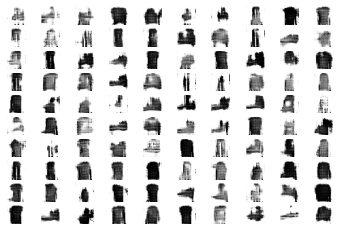

In [90]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, np.hstack((labels, labels)).reshape(n_samples, 2)]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()
# load model
model = load_model('model_18750.h5')
latent_dim = 100
n_examples = 100 # must be a square
n_class = 2 # sneaker
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_examples)